In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn

from train_evaluate_attention import NMR_prediction
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import torch.nn as nn
from dgl import AddSelfLoop
from model_zoo.NMR_gcn_attention import NMR_GCN
from create_graph_data_experiment import create_graph_experiment
from node_embeddings_experiment import create_node_embeddings
from create_adjaency_matrix_from_labeled_pdb import build_adjacency_matrix
from tqdm import tqdm

In [2]:
num_test = 60
atom_dim=256

residual_dim=128

mono_dim=64

ab_dim = 64
dl_dim = 64
pf_dim = 64

in_size = atom_dim + mono_dim + ab_dim + dl_dim + pf_dim
hidden_size_1 = int(in_size / 2)
hidden_size_2 = 256
hidden_size_3 = 128
hidden_size_4 = 32

num_epoch = 2000
lr = 1e-2
seed=9721

In [3]:
C = create_node_embeddings(data_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled_combined_add_temperature_reformulate_pdb_outlier_removal_second_round/', 
                           out_atom_embed='experimental_data_combined/graph_combined/embedding/atom_embed.csv',
                           out_residual_embed='experimental_data_combined/graph_combined/embedding/residual_embed.csv', 
                           out_monosaccharide_embed='experimental_data_combined/graph_combined/embedding/monosaccharide_embed.csv',
                           out_bound_AB_embed = 'experimental_data_combined/graph_combined/embedding/ab_embed.csv',
                           out_DL_embed = 'experimental_data_combined/graph_combined/embedding/dl_embed.csv',
                           out_PF_embed = 'experimental_data_combined/graph_combined/embedding/pf_embed.csv',
                           seed=seed)

In [4]:
df_atom_embedding, df_residual_embedding, df_monosaccharide_embedding, df_ab_embedding, df_dl_embedding, df_pf_embedding =\
C.create_all_embeddings(atom_dim=atom_dim, residual_dim=residual_dim, mono_dim=mono_dim, 
                       ab_dim=ab_dim, dl_dim=dl_dim, pf_dim=pf_dim)

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 704.26it/s]


In [5]:
df_atom_embedding.to_csv(C.out_atom_embed, index=False)
df_residual_embedding.to_csv(C.out_residual_embed, index=False)
df_monosaccharide_embedding.to_csv(C.out_monosaccharide_embed, index=False)

df_ab_embedding.to_csv(C.out_bound_ab, index = False) 
df_dl_embedding.to_csv(C.out_bound_dl, index = False) 
df_pf_embedding.to_csv(C.out_carbon_pf, index = False) 

In [6]:
df_ab_embedding

,a,b,missing_a_b
0,0.219438,2.218174,-0.466984
1,-0.204763,-1.090314,-1.128612
2,0.196748,-0.273270,-1.913457
3,-0.154786,-0.315297,-0.476448
4,1.560064,-1.302807,0.240454
...,...,...,...
59,-2.463559,0.569751,1.046241
60,0.482150,1.235748,0.561160
61,-0.713032,-0.529922,-0.668505
62,-1.017655,-0.353489,-1.285241


##### Create adjaency matrix

In [7]:
B = build_adjacency_matrix(labeled_pdb_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled_combined_add_temperature_reformulate_pdb_outlier_removal_second_round/',
                           out_adjacency_dir='experimental_data_combined/graph_combined/directory_graph_connection/',
                           out_interaction_dir='experimental_data_combined/graph_combined/directory_graph_interaction/')

In [8]:
B.calculate_all_matrix()

100%|█████████████████████████████████████████| 300/300 [00:04<00:00, 67.54it/s]


##### Train evaluate

In [9]:
# atom_embed_dir='experimental_data/graph/atom_embed_simplify.csv',
Create = create_graph_experiment(data_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled_combined_add_temperature_reformulate_pdb_outlier_removal_second_round/', 
                                 adj_dir='experimental_data_combined/graph_combined/directory_graph_connection/',
                                 interaction_dir='experimental_data_combined/graph_combined/directory_graph_interaction/', 
                                 atom_embed_dir='experimental_data_combined/graph_combined/embedding/atom_embed.csv',
                                 residual_embed_dir='experimental_data_combined/graph_combined/embedding/residual_embed.csv', 
                                 mono_embed_dir='experimental_data_combined/graph_combined/embedding/monosaccharide_embed.csv', 
                                num_test=num_test, seed=seed)

In [10]:
g, test_index = Create.create_all_graph()

--------------------------loading NMR Graph-------------------------------


100%|█████████████████████████████████████████| 300/300 [00:04<00:00, 61.60it/s]


In [11]:
g.ndata['feat'].shape, g.ndata['feat1_atom'].shape, g.ndata['feat2_mono'].shape

(torch.Size([27360, 512]), torch.Size([27360, 256]), torch.Size([27360, 64]))

In [12]:
g.ndata

{'feat': tensor([[ 0.4083, -0.2048,  1.0857,  ...,  0.0778, -0.2019, -1.0187],
        [-0.9756,  3.1470,  0.5156,  ...,  0.0778, -0.2019, -1.0187],
        [-0.1893, -1.0380,  1.8419,  ...,  0.0778, -0.2019, -1.0187],
        ...,
        [ 0.7471,  1.5885, -0.2417,  ...,  0.0778, -0.2019, -1.0187],
        [ 0.1367,  0.4548, -0.4433,  ...,  0.0778, -0.2019, -1.0187],
        [-1.1838, -0.8032,  0.3539,  ...,  0.0778, -0.2019, -1.0187]]), 'shift_value': tensor([102.4000,  51.6000,  76.4000,  ...,   3.6400,   3.8200,   4.0300]), 'Carbon_Hydrogen_mask': tensor([True, True, True,  ..., True, True, True]), 'train_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'test_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'train_carbon_mask': tensor([False, False, False,  ..., False, False, False]), 'test_carbon_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'train_hydrogen_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'test_hy

In [13]:
# shift_v = g.ndata['shift_value'].numpy()
# c_m = g.ndata['test_carbon_mask'].numpy()

In [14]:
# shift_v[np.where(c_m == 1)[0]].min()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.DataFrame(test_index).to_csv('experimental_data_combined/graph_combined/test_index_experiment.csv', index=False)

g = g.int()
g = g.to(device)
features1 = g.ndata["feat1_atom"]
features2 = g.ndata["feat2_mono"]
features3 = g.ndata["feat3_ab"]
features4 = g.ndata["feat4_dl"]
features5 = g.ndata["feat5_pf"]


labels = g.ndata["shift_value"]
# masks = g.ndata['train_mask'], g.ndata['test_mask']


# masks = g.ndata['train_hydrogen_mask'], g.ndata['test_hydrogen_mask']
masks = g.ndata['train_carbon_mask'], g.ndata['test_carbon_mask']


print(features1.dtype)
print(labels.dtype)
# model = NMR_GCN(in_size=576, hid_size=[256, 128, 64, 32], out_size=1).to(device)
model = NMR_GCN(in_size1=atom_dim, in_size2=mono_dim, in_size3=ab_dim, in_size4=dl_dim, in_size5=pf_dim,
                hid_size=[hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4], out_size=1).to(device)
# model training

# NMR_prediction = NMR_prediction(results_dir='experimental_data_combined/graph_combined/experimental_results_all_hydrogen.csv',
#                                 model_dir='experimental_data_combined/graph_combined/Model_hydrogen_experiment_training.pt',
#                                num_epoch = num_epoch, 
#                                lr = lr)


NMR_prediction = NMR_prediction(results_dir='experimental_data_combined/graph_combined/experimental_results_all_carbon_simplify_training.csv',
                                model_dir='experimental_data_combined/graph_combined/Model_carbon_experiment_simplify_training.pt', 
                               num_epoch = num_epoch, 
                               lr = lr)


print("Training...")
NMR_prediction.train(g, features1, features2, features3, features4, features5, labels, masks, model)

# test the model
print("Testing...")
saved_model = NMR_GCN(in_size1=atom_dim, in_size2=mono_dim, in_size3=ab_dim, in_size4=dl_dim, in_size5=pf_dim,
                      hid_size=[hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4], out_size=1).to(device)
saved_model.load_state_dict(torch.load(NMR_prediction.model_dir))

# acc = NMR_prediction.evaluate(g, features, labels, masks[0], saved_model, print_out=True)
acc = NMR_prediction.evaluate(g, features1, features2, features3, features4, features5, labels, masks[1], saved_model, print_out=True)


print("MSE {:.4f}".format(acc))

torch.float32
torch.float32
Training...


  0%|▏                                         | 8/2000 [00:00<02:42, 12.26it/s]

1333
5122
Epoch 00000 | Loss 6121.3813 | train_RMSE 34.3830 | test_RMSE 33.2677 
1333
5122
Epoch 00001 | Loss 1197.0817 | train_RMSE 305.1038 | test_RMSE 307.9051 
1333
5122
Epoch 00002 | Loss 93393.9219 | train_RMSE 25.4358 | test_RMSE 25.0990 
1333
5122
Epoch 00003 | Loss 677.7122 | train_RMSE 62.6424 | test_RMSE 61.8882 
1333
5122
Epoch 00004 | Loss 3924.2234 | train_RMSE 73.6690 | test_RMSE 73.1391 
1333
5122
Epoch 00005 | Loss 5427.4590 | train_RMSE 71.0920 | test_RMSE 70.5891 
1333
5122
Epoch 00006 | Loss 5054.8179 | train_RMSE 61.8088 | test_RMSE 61.1623 
1333
5122
Epoch 00007 | Loss 3823.7935 | train_RMSE 37.1892 | test_RMSE 35.9538 
1333
5122
Epoch 00008 | Loss 1391.2205 | train_RMSE 54.9039 | test_RMSE 53.6334 
1333
5122
Epoch 00009 | Loss 3040.1145 | train_RMSE 26.3042 | test_RMSE 24.6186 
1333
5122
Epoch 00010 | Loss 705.6089 | train_RMSE 50.0042 | test_RMSE 48.9272 
1333
5122
Epoch 00011 | Loss 2512.9324 | train_RMSE 24.9134 | test_RMSE 23.2952 
1333
5122
Epoch 00012 | Los

  1%|▍                                        | 21/2000 [00:01<01:04, 30.61it/s]

1333
5122
Epoch 00013 | Loss 2881.3496 | train_RMSE 30.0258 | test_RMSE 29.4602 
1333
5122
Epoch 00014 | Loss 930.3093 | train_RMSE 38.7088 | test_RMSE 37.5299 
1333
5122
Epoch 00015 | Loss 1549.2893 | train_RMSE 31.4625 | test_RMSE 30.2009 
1333
5122
Epoch 00016 | Loss 1024.9486 | train_RMSE 30.8013 | test_RMSE 30.7708 
1333
5122
Epoch 00017 | Loss 995.3506 | train_RMSE 36.7090 | test_RMSE 37.0227 
1333
5122
Epoch 00018 | Loss 1421.1436 | train_RMSE 20.4840 | test_RMSE 19.4833 
1333
5122
Epoch 00019 | Loss 456.6367 | train_RMSE 34.3511 | test_RMSE 33.3675 
1333
5122
Epoch 00020 | Loss 1214.0189 | train_RMSE 24.2658 | test_RMSE 23.2826 
1333
5122
Epoch 00021 | Loss 618.1381 | train_RMSE 22.7838 | test_RMSE 22.8919 
1333
5122
Epoch 00022 | Loss 553.0084 | train_RMSE 28.7021 | test_RMSE 29.1566 
1333
5122
Epoch 00023 | Loss 859.6516 | train_RMSE 18.7243 | test_RMSE 18.4858 
1333
5122
Epoch 00024 | Loss 379.6562 | train_RMSE 23.1050 | test_RMSE 22.3025 
1333
5122
Epoch 00025 | Loss 551.71

  2%|▋                                        | 35/2000 [00:01<00:44, 44.43it/s]

1333
5122
Epoch 00026 | Loss 674.3658 | train_RMSE 19.1557 | test_RMSE 18.5213 
1333
5122
Epoch 00027 | Loss 387.7946 | train_RMSE 19.0118 | test_RMSE 19.0806 
1333
5122
Epoch 00028 | Loss 384.2718 | train_RMSE 22.7092 | test_RMSE 23.0515 
1333
5122
Epoch 00029 | Loss 543.3116 | train_RMSE 17.9474 | test_RMSE 18.0016 
1333
5122
Epoch 00030 | Loss 342.3803 | train_RMSE 17.8154 | test_RMSE 17.3878 
1333
5122
Epoch 00031 | Loss 336.2493 | train_RMSE 20.8684 | test_RMSE 20.3750 
1333
5122
Epoch 00032 | Loss 444.1456 | train_RMSE 18.7317 | test_RMSE 18.3518 
1333
5122
Epoch 00033 | Loss 366.1222 | train_RMSE 15.9358 | test_RMSE 15.9236 
1333
5122
Epoch 00034 | Loss 265.9356 | train_RMSE 18.5144 | test_RMSE 18.8203 
1333
5122
Epoch 00035 | Loss 364.9530 | train_RMSE 17.9777 | test_RMSE 18.2785 
1333
5122
Epoch 00036 | Loss 339.5642 | train_RMSE 15.4629 | test_RMSE 15.5593 
1333
5122
Epoch 00037 | Loss 253.8359 | train_RMSE 17.1050 | test_RMSE 17.0448 
1333


  2%|█                                        | 49/2000 [00:01<00:37, 52.71it/s]

5122
Epoch 00038 | Loss 306.3424 | train_RMSE 17.7407 | test_RMSE 17.6982 
1333
5122
Epoch 00039 | Loss 325.0982 | train_RMSE 15.6502 | test_RMSE 15.7417 
1333
5122
Epoch 00040 | Loss 257.0151 | train_RMSE 15.5235 | test_RMSE 15.7662 
1333
5122
Epoch 00041 | Loss 253.4394 | train_RMSE 16.9278 | test_RMSE 17.2005 
1333
5122
Epoch 00042 | Loss 300.3234 | train_RMSE 15.5059 | test_RMSE 15.7520 
1333
5122
Epoch 00043 | Loss 256.9189 | train_RMSE 14.9558 | test_RMSE 15.1454 
1333
5122
Epoch 00044 | Loss 236.4623 | train_RMSE 16.0968 | test_RMSE 16.2514 
1333
5122
Epoch 00045 | Loss 272.7257 | train_RMSE 15.5243 | test_RMSE 15.6974 
1333
5122
Epoch 00046 | Loss 251.2810 | train_RMSE 14.3981 | test_RMSE 14.6126 
1333
5122
Epoch 00047 | Loss 219.6198 | train_RMSE 15.0172 | test_RMSE 15.2429 
1333
5122
Epoch 00048 | Loss 242.4530 | train_RMSE 14.9137 | test_RMSE 15.1388 
1333
5122
Epoch 00049 | Loss 236.7606 | train_RMSE 14.0218 | test_RMSE 14.2283 
1333
5122
Epoch 00050 | Loss 210.5097 | train

  3%|█▎                                       | 63/2000 [00:01<00:33, 57.20it/s]

1333
5122
Epoch 00051 | Loss 220.9388 | train_RMSE 14.5531 | test_RMSE 14.6916 
1333
5122
Epoch 00052 | Loss 222.0972 | train_RMSE 13.7313 | test_RMSE 13.9035 
1333
5122
Epoch 00053 | Loss 200.8459 | train_RMSE 13.7820 | test_RMSE 14.0052 
1333
5122
Epoch 00054 | Loss 203.1061 | train_RMSE 13.9466 | test_RMSE 14.1877 
1333
5122
Epoch 00055 | Loss 209.0244 | train_RMSE 13.3469 | test_RMSE 13.5575 
1333
5122
Epoch 00056 | Loss 188.0570 | train_RMSE 13.3772 | test_RMSE 13.5310 
1333
5122
Epoch 00057 | Loss 191.6776 | train_RMSE 13.5130 | test_RMSE 13.6488 
1333
5122
Epoch 00058 | Loss 194.7431 | train_RMSE 13.0394 | test_RMSE 13.2192 
1333
5122
Epoch 00059 | Loss 182.6026 | train_RMSE 12.9090 | test_RMSE 13.1551 
1333
5122
Epoch 00060 | Loss 182.7920 | train_RMSE 12.9623 | test_RMSE 13.2368 
1333
5122
Epoch 00061 | Loss 183.1521 | train_RMSE 12.6010 | test_RMSE 12.8609 
1333
5122
Epoch 00062 | Loss 173.3598 | train_RMSE 12.5527 | test_RMSE 12.7818 
1333
5122
Epoch 00063 | Loss 167.7790 | 

  4%|█▍                                       | 70/2000 [00:01<00:33, 57.37it/s]

1333
5122
Epoch 00064 | Loss 172.3344 | train_RMSE 12.2392 | test_RMSE 12.5079 
1333
5122
Epoch 00065 | Loss 161.7732 | train_RMSE 12.1110 | test_RMSE 12.4282 
1333
5122
Epoch 00066 | Loss 161.1252 | train_RMSE 12.0632 | test_RMSE 12.3996 
1333
5122
Epoch 00067 | Loss 158.8839 | train_RMSE 11.7951 | test_RMSE 12.1271 
1333
5122
Epoch 00068 | Loss 152.2167 | train_RMSE 11.7551 | test_RMSE 12.0726 
1333
5122
Epoch 00069 | Loss 149.9987 | train_RMSE 11.6932 | test_RMSE 12.0137 
1333
5122
Epoch 00070 | Loss 148.7434 | train_RMSE 11.4122 | test_RMSE 11.7589 
1333
5122
Epoch 00071 | Loss 142.8682 | train_RMSE 11.3454 | test_RMSE 11.7138 
1333
5122
Epoch 00072 | Loss 144.4849 | train_RMSE 11.2131 | test_RMSE 11.5829 
1333
5122
Epoch 00073 | Loss 139.0563 | train_RMSE 11.0252 | test_RMSE 11.3843 
1333
5122
Epoch 00074 | Loss 133.6827 | train_RMSE 10.9975 | test_RMSE 11.3457 
1333
5122
Epoch 00075 | Loss 135.9386 | train_RMSE 10.8380 | test_RMSE 11.1898 


  4%|█▋                                       | 83/2000 [00:02<00:33, 57.61it/s]

1333
5122
Epoch 00076 | Loss 128.1973 | train_RMSE 10.6629 | test_RMSE 11.0230 
1333
5122
Epoch 00077 | Loss 126.9121 | train_RMSE 10.5995 | test_RMSE 10.9565 
1333
5122
Epoch 00078 | Loss 126.1447 | train_RMSE 10.4267 | test_RMSE 10.7767 
1333
5122
Epoch 00079 | Loss 122.3210 | train_RMSE 10.3558 | test_RMSE 10.6970 
1333
5122
Epoch 00080 | Loss 118.5269 | train_RMSE 10.2551 | test_RMSE 10.5872 
1333
5122
Epoch 00081 | Loss 115.6794 | train_RMSE 10.0876 | test_RMSE 10.4093 
1333
5122
Epoch 00082 | Loss 114.2829 | train_RMSE 10.0144 | test_RMSE 10.3228 
1333
5122
Epoch 00083 | Loss 114.0511 | train_RMSE 9.8820 | test_RMSE 10.1824 
1333
5122
Epoch 00084 | Loss 110.7903 | train_RMSE 9.8192 | test_RMSE 10.1132 
1333
5122
Epoch 00085 | Loss 109.8075 | train_RMSE 9.7377 | test_RMSE 10.0256 
1333
5122
Epoch 00086 | Loss 106.7169 | train_RMSE 9.5993 | test_RMSE 9.8764 
1333
5122
Epoch 00087 | Loss 104.3586 | train_RMSE 9.5421 | test_RMSE 9.8059 


  5%|█▉                                       | 95/2000 [00:02<00:33, 57.52it/s]

1333
5122
Epoch 00088 | Loss 104.7973 | train_RMSE 9.4324 | test_RMSE 9.6951 
1333
5122
Epoch 00089 | Loss 101.4879 | train_RMSE 9.3756 | test_RMSE 9.6415 
1333
5122
Epoch 00090 | Loss 101.1418 | train_RMSE 9.3023 | test_RMSE 9.5594 
1333
5122
Epoch 00091 | Loss 100.4293 | train_RMSE 9.2079 | test_RMSE 9.4421 
1333
5122
Epoch 00092 | Loss 98.3484 | train_RMSE 9.1466 | test_RMSE 9.3609 
1333
5122
Epoch 00093 | Loss 97.3641 | train_RMSE 9.0789 | test_RMSE 9.2855 
1333
5122
Epoch 00094 | Loss 95.1880 | train_RMSE 9.0301 | test_RMSE 9.2312 
1333
5122
Epoch 00095 | Loss 92.7533 | train_RMSE 8.9678 | test_RMSE 9.1544 
1333
5122
Epoch 00096 | Loss 93.0973 | train_RMSE 8.9102 | test_RMSE 9.0748 
1333
5122
Epoch 00097 | Loss 91.6728 | train_RMSE 8.8589 | test_RMSE 9.0147 
1333
5122
Epoch 00098 | Loss 92.8581 | train_RMSE 8.8139 | test_RMSE 8.9681 
1333
5122
Epoch 00099 | Loss 93.3378 | train_RMSE 8.7729 | test_RMSE 8.9199 


  5%|██▏                                     | 108/2000 [00:02<00:32, 58.71it/s]

1333
5122
Epoch 00100 | Loss 90.9251 | train_RMSE 8.7213 | test_RMSE 8.8467 
1333
5122
Epoch 00101 | Loss 89.4867 | train_RMSE 8.6835 | test_RMSE 8.7993 
1333
5122
Epoch 00102 | Loss 86.7242 | train_RMSE 8.6391 | test_RMSE 8.7657 
1333
5122
Epoch 00103 | Loss 88.0307 | train_RMSE 8.6150 | test_RMSE 8.7457 
1333
5122
Epoch 00104 | Loss 86.0898 | train_RMSE 8.5585 | test_RMSE 8.6797 
1333
5122
Epoch 00105 | Loss 85.4989 | train_RMSE 8.5151 | test_RMSE 8.6281 
1333
5122
Epoch 00106 | Loss 86.3620 | train_RMSE 8.4770 | test_RMSE 8.6010 
1333
5122
Epoch 00107 | Loss 83.7826 | train_RMSE 8.4495 | test_RMSE 8.5814 
1333
5122
Epoch 00108 | Loss 84.0654 | train_RMSE 8.4044 | test_RMSE 8.5306 
1333
5122
Epoch 00109 | Loss 82.3814 | train_RMSE 8.3741 | test_RMSE 8.4884 
1333
5122
Epoch 00110 | Loss 83.0244 | train_RMSE 8.3320 | test_RMSE 8.4535 
1333
5122
Epoch 00111 | Loss 82.3762 | train_RMSE 8.3094 | test_RMSE 8.4394 


  6%|██▍                                     | 121/2000 [00:02<00:31, 59.35it/s]

1333
5122
Epoch 00112 | Loss 81.0300 | train_RMSE 8.2637 | test_RMSE 8.3862 
1333
5122
Epoch 00113 | Loss 81.5945 | train_RMSE 8.2312 | test_RMSE 8.3506 
1333
5122
Epoch 00114 | Loss 81.4573 | train_RMSE 8.1966 | test_RMSE 8.3293 
1333
5122
Epoch 00115 | Loss 80.1857 | train_RMSE 8.1836 | test_RMSE 8.3254 
1333
5122
Epoch 00116 | Loss 78.2063 | train_RMSE 8.1341 | test_RMSE 8.2636 
1333
5122
Epoch 00117 | Loss 78.3052 | train_RMSE 8.1080 | test_RMSE 8.2290 
1333
5122
Epoch 00118 | Loss 78.1791 | train_RMSE 8.0773 | test_RMSE 8.2027 
1333
5122
Epoch 00119 | Loss 77.5691 | train_RMSE 8.0568 | test_RMSE 8.1880 
1333
5122
Epoch 00120 | Loss 77.0379 | train_RMSE 8.0236 | test_RMSE 8.1508 
1333
5122
Epoch 00121 | Loss 76.7234 | train_RMSE 8.0002 | test_RMSE 8.1321 
1333
5122
Epoch 00122 | Loss 75.7322 | train_RMSE 7.9796 | test_RMSE 8.1123 
1333
5122
Epoch 00123 | Loss 76.7650 | train_RMSE 7.9553 | test_RMSE 8.0844 
1333


  7%|██▋                                     | 135/2000 [00:02<00:30, 60.71it/s]

5122
Epoch 00124 | Loss 75.9289 | train_RMSE 7.9305 | test_RMSE 8.0555 
1333
5122
Epoch 00125 | Loss 75.7960 | train_RMSE 7.9135 | test_RMSE 8.0394 
1333
5122
Epoch 00126 | Loss 75.1797 | train_RMSE 7.8898 | test_RMSE 8.0192 
1333
5122
Epoch 00127 | Loss 74.3190 | train_RMSE 7.8680 | test_RMSE 8.0054 
1333
5122
Epoch 00128 | Loss 75.6305 | train_RMSE 7.8487 | test_RMSE 7.9993 
1333
5122
Epoch 00129 | Loss 74.7568 | train_RMSE 7.8315 | test_RMSE 7.9904 
1333
5122
Epoch 00130 | Loss 72.6176 | train_RMSE 7.8100 | test_RMSE 7.9657 
1333
5122
Epoch 00131 | Loss 72.9494 | train_RMSE 7.7871 | test_RMSE 7.9350 
1333
5122
Epoch 00132 | Loss 72.0407 | train_RMSE 7.7729 | test_RMSE 7.9231 
1333
5122
Epoch 00133 | Loss 73.7369 | train_RMSE 7.7424 | test_RMSE 7.8814 
1333
5122
Epoch 00134 | Loss 72.3414 | train_RMSE 7.7256 | test_RMSE 7.8581 
1333
5122
Epoch 00135 | Loss 72.6633 | train_RMSE 7.7141 | test_RMSE 7.8494 
1333
5122
Epoch 00136 | Loss 71.0050 | train_RMSE 7.6883 | test_RMSE 7.8202 


  7%|██▉                                     | 149/2000 [00:03<00:30, 61.39it/s]

1333
5122
Epoch 00137 | Loss 70.8096 | train_RMSE 7.6688 | test_RMSE 7.7995 
1333
5122
Epoch 00138 | Loss 71.6958 | train_RMSE 7.6515 | test_RMSE 7.7852 
1333
5122
Epoch 00139 | Loss 70.9969 | train_RMSE 7.6360 | test_RMSE 7.7748 
1333
5122
Epoch 00140 | Loss 70.6171 | train_RMSE 7.6258 | test_RMSE 7.7717 
1333
5122
Epoch 00141 | Loss 70.1424 | train_RMSE 7.6072 | test_RMSE 7.7522 
1333
5122
Epoch 00142 | Loss 70.1754 | train_RMSE 7.5934 | test_RMSE 7.7397 
1333
5122
Epoch 00143 | Loss 70.3616 | train_RMSE 7.5753 | test_RMSE 7.7187 
1333
5122
Epoch 00144 | Loss 68.9652 | train_RMSE 7.5622 | test_RMSE 7.7022 
1333
5122
Epoch 00145 | Loss 69.7746 | train_RMSE 7.5494 | test_RMSE 7.6914 
1333
5122
Epoch 00146 | Loss 69.5505 | train_RMSE 7.5441 | test_RMSE 7.6868 
1333
5122
Epoch 00147 | Loss 71.5473 | train_RMSE 7.5255 | test_RMSE 7.6698 
1333
5122
Epoch 00148 | Loss 67.7297 | train_RMSE 7.5096 | test_RMSE 7.6604 
1333
5122
Epoch 00149 | Loss 69.8865 | train_RMSE 7.5128 | test_RMSE 7.6678 

  8%|███▎                                    | 163/2000 [00:03<00:29, 62.31it/s]

1333
5122
Epoch 00150 | Loss 68.7158 | train_RMSE 7.4835 | test_RMSE 7.6336 
1333
5122
Epoch 00151 | Loss 68.9225 | train_RMSE 7.4739 | test_RMSE 7.6171 
1333
5122
Epoch 00152 | Loss 66.9948 | train_RMSE 7.4638 | test_RMSE 7.6073 
1333
5122
Epoch 00153 | Loss 67.9335 | train_RMSE 7.4511 | test_RMSE 7.5922 
1333
5122
Epoch 00154 | Loss 67.0893 | train_RMSE 7.4473 | test_RMSE 7.5850 
1333
5122
Epoch 00155 | Loss 69.2197 | train_RMSE 7.4398 | test_RMSE 7.5843 
1333
5122
Epoch 00156 | Loss 68.3508 | train_RMSE 7.4201 | test_RMSE 7.5681 
1333
5122
Epoch 00157 | Loss 67.8337 | train_RMSE 7.4078 | test_RMSE 7.5573 
1333
5122
Epoch 00158 | Loss 66.4646 | train_RMSE 7.3981 | test_RMSE 7.5473 
1333
5122
Epoch 00159 | Loss 65.4797 | train_RMSE 7.3953 | test_RMSE 7.5448 
1333
5122
Epoch 00160 | Loss 68.0053 | train_RMSE 7.3836 | test_RMSE 7.5273 
1333
5122
Epoch 00161 | Loss 67.2269 | train_RMSE 7.3721 | test_RMSE 7.5185 
1333
5122
Epoch 00162 | Loss 66.3344 | train_RMSE 7.3840 | test_RMSE 7.5339 

  8%|███▍                                    | 170/2000 [00:03<00:29, 62.75it/s]

1333
5122
Epoch 00163 | Loss 66.4968 | train_RMSE 7.3550 | test_RMSE 7.5050 
1333
5122
Epoch 00164 | Loss 64.0156 | train_RMSE 7.3428 | test_RMSE 7.4990 
1333
5122
Epoch 00165 | Loss 66.1792 | train_RMSE 7.3574 | test_RMSE 7.5193 
1333
5122
Epoch 00166 | Loss 66.8056 | train_RMSE 7.3284 | test_RMSE 7.4981 
1333
5122
Epoch 00167 | Loss 65.3611 | train_RMSE 7.3284 | test_RMSE 7.5020 
1333
5122
Epoch 00168 | Loss 65.9248 | train_RMSE 7.3470 | test_RMSE 7.5262 
1333
5122
Epoch 00169 | Loss 64.9121 | train_RMSE 7.3070 | test_RMSE 7.4837 
1333
5122
Epoch 00170 | Loss 64.4314 | train_RMSE 7.3067 | test_RMSE 7.4763 
1333
5122
Epoch 00171 | Loss 64.7923 | train_RMSE 7.2948 | test_RMSE 7.4647 
1333
5122
Epoch 00172 | Loss 64.7474 | train_RMSE 7.2859 | test_RMSE 7.4505 
1333
5122
Epoch 00173 | Loss 63.7319 | train_RMSE 7.2705 | test_RMSE 7.4335 
1333
5122
Epoch 00174 | Loss 65.1981 | train_RMSE 7.2649 | test_RMSE 7.4291 
1333
5122
Epoch 00175 | Loss 64.8242 | train_RMSE 7.2611 | test_RMSE 7.4322 

  9%|███▋                                    | 184/2000 [00:03<00:28, 63.42it/s]

1333
5122
Epoch 00176 | Loss 64.2248 | train_RMSE 7.2462 | test_RMSE 7.4198 
1333
5122
Epoch 00177 | Loss 65.2277 | train_RMSE 7.2531 | test_RMSE 7.4259 
1333
5122
Epoch 00178 | Loss 65.0686 | train_RMSE 7.2574 | test_RMSE 7.4357 
1333
5122
Epoch 00179 | Loss 63.0917 | train_RMSE 7.2361 | test_RMSE 7.4123 
1333
5122
Epoch 00180 | Loss 64.6302 | train_RMSE 7.2336 | test_RMSE 7.4106 
1333
5122
Epoch 00181 | Loss 64.4681 | train_RMSE 7.2376 | test_RMSE 7.4102 
1333
5122
Epoch 00182 | Loss 64.2455 | train_RMSE 7.2054 | test_RMSE 7.3798 
1333
5122
Epoch 00183 | Loss 65.3591 | train_RMSE 7.1979 | test_RMSE 7.3755 
1333
5122
Epoch 00184 | Loss 64.7831 | train_RMSE 7.1949 | test_RMSE 7.3780 
1333
5122
Epoch 00185 | Loss 61.8210 | train_RMSE 7.1852 | test_RMSE 7.3699 
1333
5122
Epoch 00186 | Loss 64.3270 | train_RMSE 7.1774 | test_RMSE 7.3604 
1333
5122
Epoch 00187 | Loss 63.1031 | train_RMSE 7.1825 | test_RMSE 7.3649 
1333
5122
Epoch 00188 | Loss 62.3556 | train_RMSE 7.1640 | test_RMSE 7.3442 

 10%|███▉                                    | 198/2000 [00:03<00:28, 64.18it/s]

1333
5122
Epoch 00189 | Loss 63.3869 | train_RMSE 7.1553 | test_RMSE 7.3377 
1333
5122
Epoch 00190 | Loss 64.4859 | train_RMSE 7.1536 | test_RMSE 7.3392 
1333
5122
Epoch 00191 | Loss 63.2445 | train_RMSE 7.1431 | test_RMSE 7.3369 
1333
5122
Epoch 00192 | Loss 63.8952 | train_RMSE 7.1426 | test_RMSE 7.3417 
1333
5122
Epoch 00193 | Loss 62.7109 | train_RMSE 7.1390 | test_RMSE 7.3414 
1333
5122
Epoch 00194 | Loss 61.8935 | train_RMSE 7.1284 | test_RMSE 7.3325 
1333
5122
Epoch 00195 | Loss 62.9922 | train_RMSE 7.1230 | test_RMSE 7.3220 
1333
5122
Epoch 00196 | Loss 63.3868 | train_RMSE 7.1216 | test_RMSE 7.3172 
1333
5122
Epoch 00197 | Loss 62.7584 | train_RMSE 7.1095 | test_RMSE 7.3008 
1333
5122
Epoch 00198 | Loss 62.4462 | train_RMSE 7.1022 | test_RMSE 7.2897 
1333
5122
Epoch 00199 | Loss 63.2811 | train_RMSE 7.1052 | test_RMSE 7.2881 
1333
5122
Epoch 00200 | Loss 62.0252 | train_RMSE 7.1024 | test_RMSE 7.2886 
1333
5122
Epoch 00201 | Loss 65.1168 | train_RMSE 7.1209 | test_RMSE 7.3062 

 11%|████▏                                   | 212/2000 [00:04<00:27, 64.23it/s]

5122
Epoch 00202 | Loss 60.8809 | train_RMSE 7.0756 | test_RMSE 7.2632 
1333
5122
Epoch 00203 | Loss 59.7685 | train_RMSE 7.0829 | test_RMSE 7.2730 
1333
5122
Epoch 00204 | Loss 63.1729 | train_RMSE 7.0899 | test_RMSE 7.2830 
1333
5122
Epoch 00205 | Loss 62.0073 | train_RMSE 7.0583 | test_RMSE 7.2522 
1333
5122
Epoch 00206 | Loss 61.6494 | train_RMSE 7.0662 | test_RMSE 7.2620 
1333
5122
Epoch 00207 | Loss 62.3387 | train_RMSE 7.0660 | test_RMSE 7.2567 
1333
5122
Epoch 00208 | Loss 61.7658 | train_RMSE 7.0393 | test_RMSE 7.2348 
1333
5122
Epoch 00209 | Loss 62.4428 | train_RMSE 7.0465 | test_RMSE 7.2437 
1333
5122
Epoch 00210 | Loss 60.8825 | train_RMSE 7.0621 | test_RMSE 7.2693 
1333
5122
Epoch 00211 | Loss 61.5229 | train_RMSE 7.0240 | test_RMSE 7.2353 
1333
5122
Epoch 00212 | Loss 60.4196 | train_RMSE 7.0189 | test_RMSE 7.2296 
1333
5122
Epoch 00213 | Loss 61.3132 | train_RMSE 7.0094 | test_RMSE 7.2180 
1333
5122
Epoch 00214 | Loss 62.6978 | train_RMSE 7.0093 | test_RMSE 7.2090 
1333

 11%|████▌                                   | 226/2000 [00:04<00:27, 64.56it/s]

5122
Epoch 00215 | Loss 59.8061 | train_RMSE 7.0055 | test_RMSE 7.2061 
1333
5122
Epoch 00216 | Loss 60.8422 | train_RMSE 6.9981 | test_RMSE 7.1957 
1333
5122
Epoch 00217 | Loss 60.7331 | train_RMSE 7.0178 | test_RMSE 7.2158 
1333
5122
Epoch 00218 | Loss 59.5521 | train_RMSE 7.0016 | test_RMSE 7.2096 
1333
5122
Epoch 00219 | Loss 59.9920 | train_RMSE 6.9904 | test_RMSE 7.1990 
1333
5122
Epoch 00220 | Loss 61.5847 | train_RMSE 6.9900 | test_RMSE 7.1988 
1333
5122
Epoch 00221 | Loss 61.6483 | train_RMSE 7.0332 | test_RMSE 7.2416 
1333
5122
Epoch 00222 | Loss 62.8558 | train_RMSE 7.0247 | test_RMSE 7.2238 
1333
5122
Epoch 00223 | Loss 61.9206 | train_RMSE 6.9609 | test_RMSE 7.1659 
1333
5122
Epoch 00224 | Loss 60.4415 | train_RMSE 6.9923 | test_RMSE 7.2109 
1333
5122
Epoch 00225 | Loss 61.1772 | train_RMSE 7.0705 | test_RMSE 7.2808 
1333
5122
Epoch 00226 | Loss 61.5757 | train_RMSE 6.9568 | test_RMSE 7.1800 
1333
5122
Epoch 00227 | Loss 61.1361 | train_RMSE 6.9509 | test_RMSE 7.1701 
1333

 12%|████▊                                   | 240/2000 [00:04<00:27, 64.71it/s]

5122
Epoch 00228 | Loss 60.0858 | train_RMSE 7.1049 | test_RMSE 7.3185 
1333
5122
Epoch 00229 | Loss 60.2745 | train_RMSE 6.9833 | test_RMSE 7.1947 
1333
5122
Epoch 00230 | Loss 61.2280 | train_RMSE 6.9237 | test_RMSE 7.1359 
1333
5122
Epoch 00231 | Loss 58.5075 | train_RMSE 6.9804 | test_RMSE 7.1897 
1333
5122
Epoch 00232 | Loss 60.8823 | train_RMSE 6.9903 | test_RMSE 7.2211 
1333
5122
Epoch 00233 | Loss 60.9896 | train_RMSE 6.9409 | test_RMSE 7.1600 
1333
5122
Epoch 00234 | Loss 58.9723 | train_RMSE 6.9126 | test_RMSE 7.1290 
1333
5122
Epoch 00235 | Loss 59.1610 | train_RMSE 6.9094 | test_RMSE 7.1295 
1333
5122
Epoch 00236 | Loss 59.0805 | train_RMSE 6.9043 | test_RMSE 7.1219 
1333
5122
Epoch 00237 | Loss 58.5736 | train_RMSE 6.8973 | test_RMSE 7.1222 
1333
5122
Epoch 00238 | Loss 59.8307 | train_RMSE 6.8868 | test_RMSE 7.1178 
1333
5122
Epoch 00239 | Loss 59.2263 | train_RMSE 6.8919 | test_RMSE 7.1235 
1333
5122
Epoch 00240 | Loss 59.7899 | train_RMSE 6.8889 | test_RMSE 7.1177 
1333

 13%|█████                                   | 254/2000 [00:04<00:27, 63.93it/s]

5122
Epoch 00241 | Loss 59.2979 | train_RMSE 6.8816 | test_RMSE 7.1050 
1333
5122
Epoch 00242 | Loss 58.7677 | train_RMSE 6.8651 | test_RMSE 7.0869 
1333
5122
Epoch 00243 | Loss 58.3797 | train_RMSE 6.8708 | test_RMSE 7.0931 
1333
5122
Epoch 00244 | Loss 60.7835 | train_RMSE 6.8690 | test_RMSE 7.0963 
1333
5122
Epoch 00245 | Loss 59.6583 | train_RMSE 6.8725 | test_RMSE 7.1025 
1333
5122
Epoch 00246 | Loss 59.1564 | train_RMSE 6.8614 | test_RMSE 7.0989 
1333
5122
Epoch 00247 | Loss 58.0082 | train_RMSE 6.8494 | test_RMSE 7.0824 
1333
5122
Epoch 00248 | Loss 57.9003 | train_RMSE 6.8476 | test_RMSE 7.0798 
1333
5122
Epoch 00249 | Loss 60.2264 | train_RMSE 6.8490 | test_RMSE 7.0892 
1333
5122
Epoch 00250 | Loss 59.4184 | train_RMSE 6.8429 | test_RMSE 7.0741 
1333
5122
Epoch 00251 | Loss 59.1372 | train_RMSE 6.8231 | test_RMSE 7.0620 
1333
5122
Epoch 00252 | Loss 59.5074 | train_RMSE 6.8162 | test_RMSE 7.0561 
1333
5122
Epoch 00253 | Loss 59.2413 | train_RMSE 6.8227 | test_RMSE 7.0566 


 13%|█████▏                                  | 261/2000 [00:04<00:27, 63.92it/s]

1333
5122
Epoch 00254 | Loss 57.7084 | train_RMSE 6.8377 | test_RMSE 7.0720 
1333
5122
Epoch 00255 | Loss 59.0837 | train_RMSE 6.8794 | test_RMSE 7.1084 
1333
5122
Epoch 00256 | Loss 58.6557 | train_RMSE 6.8111 | test_RMSE 7.0441 
1333
5122
Epoch 00257 | Loss 58.7503 | train_RMSE 6.8155 | test_RMSE 7.0510 
1333
5122
Epoch 00258 | Loss 57.8438 | train_RMSE 6.7971 | test_RMSE 7.0409 
1333
5122
Epoch 00259 | Loss 57.9439 | train_RMSE 6.7964 | test_RMSE 7.0440 
1333
5122
Epoch 00260 | Loss 58.3409 | train_RMSE 6.7945 | test_RMSE 7.0444 
1333
5122
Epoch 00261 | Loss 58.7011 | train_RMSE 6.8149 | test_RMSE 7.0654 
1333
5122
Epoch 00262 | Loss 58.6879 | train_RMSE 6.8457 | test_RMSE 7.0839 
1333
5122
Epoch 00263 | Loss 57.2878 | train_RMSE 6.7933 | test_RMSE 7.0402 
1333
5122
Epoch 00264 | Loss 59.7837 | train_RMSE 6.7877 | test_RMSE 7.0222 
1333
5122
Epoch 00265 | Loss 57.4485 | train_RMSE 6.7727 | test_RMSE 7.0196 
1333
5122
Epoch 00266 | Loss 58.1551 | train_RMSE 6.8043 | test_RMSE 7.0617 

 14%|█████▌                                  | 275/2000 [00:05<00:26, 63.97it/s]

1333
5122
Epoch 00267 | Loss 58.0145 | train_RMSE 6.9875 | test_RMSE 7.2425 
1333
5122
Epoch 00268 | Loss 60.8622 | train_RMSE 7.0588 | test_RMSE 7.3282 
1333
5122
Epoch 00269 | Loss 62.1781 | train_RMSE 7.1004 | test_RMSE 7.3028 
1333
5122
Epoch 00270 | Loss 61.2791 | train_RMSE 6.8791 | test_RMSE 7.1504 
1333
5122
Epoch 00271 | Loss 60.1120 | train_RMSE 6.7667 | test_RMSE 7.0115 
1333
5122
Epoch 00272 | Loss 56.9323 | train_RMSE 6.8378 | test_RMSE 7.0832 
1333
5122
Epoch 00273 | Loss 57.4833 | train_RMSE 6.8597 | test_RMSE 7.0939 
1333
5122
Epoch 00274 | Loss 57.7920 | train_RMSE 6.9333 | test_RMSE 7.1777 
1333
5122
Epoch 00275 | Loss 60.3705 | train_RMSE 6.8070 | test_RMSE 7.0562 
1333
5122
Epoch 00276 | Loss 56.7021 | train_RMSE 6.7896 | test_RMSE 7.0143 
1333
5122
Epoch 00277 | Loss 57.8090 | train_RMSE 6.7520 | test_RMSE 6.9903 
1333
5122
Epoch 00278 | Loss 58.0426 | train_RMSE 6.7881 | test_RMSE 7.0520 
1333
5122
Epoch 00279 | Loss 58.9224 | train_RMSE 6.8796 | test_RMSE 7.1322 

 14%|█████▊                                  | 289/2000 [00:05<00:26, 64.47it/s]

1333
5122
Epoch 00280 | Loss 58.5437 | train_RMSE 6.8168 | test_RMSE 7.0816 
1333
5122
Epoch 00281 | Loss 57.9929 | train_RMSE 6.7675 | test_RMSE 7.0321 
1333
5122
Epoch 00282 | Loss 57.4196 | train_RMSE 6.7389 | test_RMSE 6.9853 
1333
5122
Epoch 00283 | Loss 57.0944 | train_RMSE 6.8264 | test_RMSE 7.0884 
1333
5122
Epoch 00284 | Loss 57.3183 | train_RMSE 7.0271 | test_RMSE 7.2432 
1333
5122
Epoch 00285 | Loss 60.9501 | train_RMSE 7.1612 | test_RMSE 7.4391 
1333
5122
Epoch 00286 | Loss 64.7411 | train_RMSE 7.4692 | test_RMSE 7.7055 
1333
5122
Epoch 00287 | Loss 67.3974 | train_RMSE 7.3343 | test_RMSE 7.6278 
1333
5122
Epoch 00288 | Loss 67.0272 | train_RMSE 7.1930 | test_RMSE 7.4140 
1333
5122
Epoch 00289 | Loss 61.1867 | train_RMSE 6.8193 | test_RMSE 7.0901 
1333
5122
Epoch 00290 | Loss 58.7895 | train_RMSE 6.7179 | test_RMSE 6.9767 
1333
5122
Epoch 00291 | Loss 57.0020 | train_RMSE 6.9532 | test_RMSE 7.1949 
1333
5122
Epoch 00292 | Loss 59.6726 | train_RMSE 7.1222 | test_RMSE 7.4050 

 15%|██████                                  | 303/2000 [00:05<00:26, 64.62it/s]

5122
Epoch 00293 | Loss 63.0693 | train_RMSE 7.2435 | test_RMSE 7.4780 
1333
5122
Epoch 00294 | Loss 64.8671 | train_RMSE 6.9616 | test_RMSE 7.2365 
1333
5122
Epoch 00295 | Loss 61.7776 | train_RMSE 6.7843 | test_RMSE 7.0224 
1333
5122
Epoch 00296 | Loss 57.7096 | train_RMSE 6.6927 | test_RMSE 6.9437 
1333
5122
Epoch 00297 | Loss 56.2915 | train_RMSE 6.7668 | test_RMSE 7.0457 
1333
5122
Epoch 00298 | Loss 56.8407 | train_RMSE 6.9741 | test_RMSE 7.2482 
1333
5122
Epoch 00299 | Loss 58.2254 | train_RMSE 6.8805 | test_RMSE 7.1834 
1333
5122
Epoch 00300 | Loss 58.9186 | train_RMSE 6.7973 | test_RMSE 7.0758 
1333
5122
Epoch 00301 | Loss 58.9464 | train_RMSE 6.7037 | test_RMSE 6.9972 
1333
5122
Epoch 00302 | Loss 58.4169 | train_RMSE 6.6829 | test_RMSE 6.9498 
1333
5122
Epoch 00303 | Loss 55.2485 | train_RMSE 6.6458 | test_RMSE 6.9170 
1333
5122
Epoch 00304 | Loss 55.5243 | train_RMSE 6.6427 | test_RMSE 6.9268 
1333
5122
Epoch 00305 | Loss 57.0753 | train_RMSE 6.6739 | test_RMSE 6.9510 
1333

 16%|██████▎                                 | 317/2000 [00:05<00:26, 64.46it/s]

5122
Epoch 00306 | Loss 55.5352 | train_RMSE 6.6328 | test_RMSE 6.9117 
1333
5122
Epoch 00307 | Loss 55.8436 | train_RMSE 6.6252 | test_RMSE 6.8921 
1333
5122
Epoch 00308 | Loss 53.6848 | train_RMSE 6.6254 | test_RMSE 6.8908 
1333
5122
Epoch 00309 | Loss 55.3572 | train_RMSE 6.6273 | test_RMSE 6.8974 
1333
5122
Epoch 00310 | Loss 56.7430 | train_RMSE 6.6493 | test_RMSE 6.9286 
1333
5122
Epoch 00311 | Loss 56.4019 | train_RMSE 6.6852 | test_RMSE 6.9536 
1333
5122
Epoch 00312 | Loss 56.5055 | train_RMSE 6.6853 | test_RMSE 6.9594 
1333
5122
Epoch 00313 | Loss 56.8056 | train_RMSE 6.7366 | test_RMSE 6.9792 
1333
5122
Epoch 00314 | Loss 57.6431 | train_RMSE 6.8058 | test_RMSE 7.0863 
1333
5122
Epoch 00315 | Loss 58.9312 | train_RMSE 6.9601 | test_RMSE 7.2003 
1333
5122
Epoch 00316 | Loss 59.4288 | train_RMSE 6.9657 | test_RMSE 7.2707 
1333
5122
Epoch 00317 | Loss 61.1508 | train_RMSE 7.2491 | test_RMSE 7.4959 
1333
5122
Epoch 00318 | Loss 63.6416 | train_RMSE 7.2675 | test_RMSE 7.5763 
1333

 17%|██████▌                                 | 331/2000 [00:06<00:25, 64.23it/s]

5122
Epoch 00319 | Loss 65.7373 | train_RMSE 7.7431 | test_RMSE 7.9612 
1333
5122
Epoch 00320 | Loss 71.4332 | train_RMSE 7.8691 | test_RMSE 8.1859 
1333
5122
Epoch 00321 | Loss 72.8147 | train_RMSE 8.0943 | test_RMSE 8.2866 
1333
5122
Epoch 00322 | Loss 75.4902 | train_RMSE 7.8007 | test_RMSE 8.1058 
1333
5122
Epoch 00323 | Loss 73.4029 | train_RMSE 7.6184 | test_RMSE 7.8258 
1333
5122
Epoch 00324 | Loss 69.1477 | train_RMSE 7.0001 | test_RMSE 7.2874 
1333
5122
Epoch 00325 | Loss 61.6308 | train_RMSE 6.7391 | test_RMSE 7.0115 
1333
5122
Epoch 00326 | Loss 56.6669 | train_RMSE 6.7351 | test_RMSE 7.0070 
1333
5122
Epoch 00327 | Loss 56.4809 | train_RMSE 6.8591 | test_RMSE 7.1772 
1333
5122
Epoch 00328 | Loss 59.3177 | train_RMSE 7.2303 | test_RMSE 7.4368 
1333
5122
Epoch 00329 | Loss 63.0238 | train_RMSE 7.0670 | test_RMSE 7.3874 
1333
5122
Epoch 00330 | Loss 61.2081 | train_RMSE 6.8594 | test_RMSE 7.1049 
1333
5122
Epoch 00331 | Loss 58.5516 | train_RMSE 6.6303 | test_RMSE 6.9163 
1333

 17%|██████▉                                 | 345/2000 [00:06<00:25, 64.77it/s]

5122
Epoch 00332 | Loss 55.3981 | train_RMSE 6.6273 | test_RMSE 6.9267 
1333
5122
Epoch 00333 | Loss 56.3356 | train_RMSE 6.8788 | test_RMSE 7.1507 
1333
5122
Epoch 00334 | Loss 60.0936 | train_RMSE 7.0348 | test_RMSE 7.3676 
1333
5122
Epoch 00335 | Loss 61.4995 | train_RMSE 7.2673 | test_RMSE 7.5007 
1333
5122
Epoch 00336 | Loss 64.6341 | train_RMSE 7.1606 | test_RMSE 7.4815 
1333
5122
Epoch 00337 | Loss 64.0599 | train_RMSE 7.2109 | test_RMSE 7.4649 
1333
5122
Epoch 00338 | Loss 63.0125 | train_RMSE 6.9585 | test_RMSE 7.2609 
1333
5122
Epoch 00339 | Loss 62.2732 | train_RMSE 6.8998 | test_RMSE 7.1660 
1333
5122
Epoch 00340 | Loss 57.8460 | train_RMSE 6.6780 | test_RMSE 6.9759 
1333
5122
Epoch 00341 | Loss 57.3843 | train_RMSE 6.6536 | test_RMSE 6.9098 
1333
5122
Epoch 00342 | Loss 56.6037 | train_RMSE 6.5783 | test_RMSE 6.8667 
1333
5122
Epoch 00343 | Loss 53.9696 | train_RMSE 6.5679 | test_RMSE 6.8527 
1333
5122
Epoch 00344 | Loss 55.4768 | train_RMSE 6.5511 | test_RMSE 6.8491 
1333

 18%|███████▏                                | 359/2000 [00:06<00:25, 65.14it/s]

1333
5122
Epoch 00346 | Loss 55.8762 | train_RMSE 6.7097 | test_RMSE 6.9891 
1333
5122
Epoch 00347 | Loss 56.5854 | train_RMSE 6.8230 | test_RMSE 7.1538 
1333
5122
Epoch 00348 | Loss 59.8161 | train_RMSE 7.0051 | test_RMSE 7.2523 
1333
5122
Epoch 00349 | Loss 60.3457 | train_RMSE 6.9133 | test_RMSE 7.2409 
1333
5122
Epoch 00350 | Loss 60.7781 | train_RMSE 7.0124 | test_RMSE 7.2925 
1333
5122
Epoch 00351 | Loss 62.4004 | train_RMSE 6.8849 | test_RMSE 7.1786 
1333
5122
Epoch 00352 | Loss 58.5021 | train_RMSE 6.9225 | test_RMSE 7.1812 
1333
5122
Epoch 00353 | Loss 61.1138 | train_RMSE 6.6971 | test_RMSE 6.9879 
1333
5122
Epoch 00354 | Loss 57.3336 | train_RMSE 6.6631 | test_RMSE 6.9289 
1333
5122
Epoch 00355 | Loss 55.4261 | train_RMSE 6.5906 | test_RMSE 6.9014 
1333
5122
Epoch 00356 | Loss 54.2337 | train_RMSE 6.5653 | test_RMSE 6.8662 
1333
5122
Epoch 00357 | Loss 55.3498 | train_RMSE 6.5279 | test_RMSE 6.8566 
1333
5122
Epoch 00358 | Loss 53.9210 | train_RMSE 6.5464 | test_RMSE 6.8573 

 19%|███████▍                                | 373/2000 [00:06<00:24, 65.25it/s]

5122
Epoch 00359 | Loss 53.8954 | train_RMSE 6.5467 | test_RMSE 6.8687 
1333
5122
Epoch 00360 | Loss 55.4967 | train_RMSE 6.6341 | test_RMSE 6.9271 
1333
5122
Epoch 00361 | Loss 56.1136 | train_RMSE 6.6632 | test_RMSE 6.9890 
1333
5122
Epoch 00362 | Loss 58.0303 | train_RMSE 6.9931 | test_RMSE 7.2708 
1333
5122
Epoch 00363 | Loss 59.6361 | train_RMSE 7.1101 | test_RMSE 7.4370 
1333
5122
Epoch 00364 | Loss 63.8165 | train_RMSE 7.5676 | test_RMSE 7.8053 
1333
5122
Epoch 00365 | Loss 68.1947 | train_RMSE 7.8147 | test_RMSE 8.1291 
1333
5122
Epoch 00366 | Loss 73.7511 | train_RMSE 8.3694 | test_RMSE 8.5897 
1333
5122
Epoch 00367 | Loss 82.4150 | train_RMSE 8.2692 | test_RMSE 8.5845 
1333
5122
Epoch 00368 | Loss 80.5720 | train_RMSE 8.3592 | test_RMSE 8.5898 
1333
5122
Epoch 00369 | Loss 79.9569 | train_RMSE 7.4274 | test_RMSE 7.7491 
1333
5122
Epoch 00370 | Loss 67.2126 | train_RMSE 6.6962 | test_RMSE 6.9801 
1333
5122
Epoch 00371 | Loss 56.5584 | train_RMSE 6.6329 | test_RMSE 6.9161 
1333

 19%|███████▌                                | 380/2000 [00:06<00:24, 65.32it/s]

1333
5122
Epoch 00373 | Loss 60.2136 | train_RMSE 7.3361 | test_RMSE 7.5687 
1333
5122
Epoch 00374 | Loss 65.2674 | train_RMSE 7.1650 | test_RMSE 7.4981 
1333
5122
Epoch 00375 | Loss 63.6303 | train_RMSE 6.9862 | test_RMSE 7.2430 
1333
5122
Epoch 00376 | Loss 59.9621 | train_RMSE 6.5584 | test_RMSE 6.8726 
1333
5122
Epoch 00377 | Loss 55.2870 | train_RMSE 6.5549 | test_RMSE 6.8696 
1333
5122
Epoch 00378 | Loss 54.3958 | train_RMSE 6.8568 | test_RMSE 7.1415 
1333
5122
Epoch 00379 | Loss 58.3806 | train_RMSE 6.9519 | test_RMSE 7.2784 
1333
5122
Epoch 00380 | Loss 61.3865 | train_RMSE 6.9926 | test_RMSE 7.2818 
1333
5122
Epoch 00381 | Loss 60.0011 | train_RMSE 6.6920 | test_RMSE 7.0183 
1333
5122
Epoch 00382 | Loss 56.4214 | train_RMSE 6.5725 | test_RMSE 6.8850 
1333
5122
Epoch 00383 | Loss 54.1798 | train_RMSE 6.4887 | test_RMSE 6.8048 
1333
5122
Epoch 00384 | Loss 54.4378 | train_RMSE 6.5276 | test_RMSE 6.8450 
1333
5122
Epoch 00385 | Loss 53.9932 | train_RMSE 6.6619 | test_RMSE 6.9549 

 20%|███████▉                                | 394/2000 [00:06<00:24, 64.79it/s]

5122
Epoch 00386 | Loss 56.4648 | train_RMSE 6.6715 | test_RMSE 7.0040 
1333
5122
Epoch 00387 | Loss 57.0941 | train_RMSE 6.7689 | test_RMSE 7.0478 
1333
5122
Epoch 00388 | Loss 57.4543 | train_RMSE 6.6249 | test_RMSE 6.9539 
1333
5122
Epoch 00389 | Loss 56.1729 | train_RMSE 6.5553 | test_RMSE 6.8470 
1333
5122
Epoch 00390 | Loss 54.6069 | train_RMSE 6.4679 | test_RMSE 6.7745 
1333
5122
Epoch 00391 | Loss 53.8341 | train_RMSE 6.4505 | test_RMSE 6.7656 
1333
5122
Epoch 00392 | Loss 52.9609 | train_RMSE 6.5450 | test_RMSE 6.8552 
1333
5122
Epoch 00393 | Loss 54.1589 | train_RMSE 6.5725 | test_RMSE 6.9060 
1333
5122
Epoch 00394 | Loss 55.9256 | train_RMSE 6.6541 | test_RMSE 6.9535 
1333
5122
Epoch 00395 | Loss 57.0991 | train_RMSE 6.7219 | test_RMSE 7.0327 
1333
5122
Epoch 00396 | Loss 57.2486 | train_RMSE 6.8375 | test_RMSE 7.1237 
1333
5122
Epoch 00397 | Loss 59.4598 | train_RMSE 6.7771 | test_RMSE 7.1152 
1333
5122
Epoch 00398 | Loss 58.4458 | train_RMSE 6.8237 | test_RMSE 7.1101 


 20%|████████▏                               | 408/2000 [00:07<00:24, 64.02it/s]

1333
5122
Epoch 00399 | Loss 56.5542 | train_RMSE 6.6043 | test_RMSE 6.9552 
1333
5122
Epoch 00400 | Loss 55.4706 | train_RMSE 6.4896 | test_RMSE 6.8159 
1333
5122
Epoch 00401 | Loss 54.1029 | train_RMSE 6.5040 | test_RMSE 6.8204 
1333
5122
Epoch 00402 | Loss 52.7747 | train_RMSE 6.5356 | test_RMSE 6.8691 
1333
5122
Epoch 00403 | Loss 53.8993 | train_RMSE 6.8148 | test_RMSE 7.0708 
1333
5122
Epoch 00404 | Loss 59.0894 | train_RMSE 6.8955 | test_RMSE 7.2474 
1333
5122
Epoch 00405 | Loss 59.7045 | train_RMSE 6.9176 | test_RMSE 7.1924 
1333
5122
Epoch 00406 | Loss 58.3716 | train_RMSE 6.8092 | test_RMSE 7.1349 
1333
5122
Epoch 00407 | Loss 57.5094 | train_RMSE 6.7813 | test_RMSE 7.0762 
1333
5122
Epoch 00408 | Loss 57.6574 | train_RMSE 6.5160 | test_RMSE 6.8580 
1333
5122
Epoch 00409 | Loss 54.2489 | train_RMSE 6.4569 | test_RMSE 6.7779 
1333
5122
Epoch 00410 | Loss 53.9204 | train_RMSE 6.4773 | test_RMSE 6.7933 
1333
5122
Epoch 00411 | Loss 53.7668 | train_RMSE 6.5692 | test_RMSE 6.9175 

 21%|████████▍                               | 422/2000 [00:07<00:24, 64.03it/s]

1333
5122
Epoch 00412 | Loss 55.7559 | train_RMSE 6.7262 | test_RMSE 7.0220 
1333
5122
Epoch 00413 | Loss 55.9846 | train_RMSE 6.6616 | test_RMSE 6.9987 
1333
5122
Epoch 00414 | Loss 57.5726 | train_RMSE 6.7149 | test_RMSE 6.9941 
1333
5122
Epoch 00415 | Loss 57.0797 | train_RMSE 6.4272 | test_RMSE 6.7632 
1333
5122
Epoch 00416 | Loss 53.3582 | train_RMSE 6.4207 | test_RMSE 6.7452 
1333
5122
Epoch 00417 | Loss 54.3664 | train_RMSE 6.5581 | test_RMSE 6.8579 
1333
5122
Epoch 00418 | Loss 53.6410 | train_RMSE 6.6116 | test_RMSE 6.9524 
1333
5122
Epoch 00419 | Loss 56.2590 | train_RMSE 6.8617 | test_RMSE 7.1424 
1333
5122
Epoch 00420 | Loss 61.0769 | train_RMSE 7.0023 | test_RMSE 7.3479 
1333
5122
Epoch 00421 | Loss 62.4269 | train_RMSE 7.3975 | test_RMSE 7.6452 
1333
5122
Epoch 00422 | Loss 65.2607 | train_RMSE 7.3369 | test_RMSE 7.6818 
1333
5122
Epoch 00423 | Loss 65.3701 | train_RMSE 7.2617 | test_RMSE 7.4989 
1333
5122
Epoch 00424 | Loss 63.2499 | train_RMSE 6.8790 | test_RMSE 7.2047 

 22%|████████▋                               | 436/2000 [00:07<00:24, 63.58it/s]

1333
5122
Epoch 00425 | Loss 61.2701 | train_RMSE 6.6605 | test_RMSE 6.9394 
1333
5122
Epoch 00426 | Loss 54.5852 | train_RMSE 6.4335 | test_RMSE 6.7790 
1333
5122
Epoch 00427 | Loss 53.6579 | train_RMSE 6.4178 | test_RMSE 6.7483 
1333
5122
Epoch 00428 | Loss 53.2648 | train_RMSE 6.4090 | test_RMSE 6.7292 
1333
5122
Epoch 00429 | Loss 51.8920 | train_RMSE 6.4109 | test_RMSE 6.7429 
1333
5122
Epoch 00430 | Loss 52.8216 | train_RMSE 6.4436 | test_RMSE 6.7572 
1333
5122
Epoch 00431 | Loss 52.7393 | train_RMSE 6.3727 | test_RMSE 6.7001 
1333
5122
Epoch 00432 | Loss 52.1518 | train_RMSE 6.3663 | test_RMSE 6.6957 
1333
5122
Epoch 00433 | Loss 51.5650 | train_RMSE 6.4123 | test_RMSE 6.7354 
1333
5122
Epoch 00434 | Loss 52.1635 | train_RMSE 6.4002 | test_RMSE 6.7371 
1333
5122
Epoch 00435 | Loss 53.7383 | train_RMSE 6.4537 | test_RMSE 6.7579 
1333
5122
Epoch 00436 | Loss 52.5207 | train_RMSE 6.4634 | test_RMSE 6.7897 
1333
5122
Epoch 00437 | Loss 53.5725 | train_RMSE 6.4228 | test_RMSE 6.7383 

 22%|█████████                               | 450/2000 [00:07<00:24, 64.15it/s]

1333
5122
Epoch 00438 | Loss 52.4821 | train_RMSE 6.3616 | test_RMSE 6.7069 
1333
5122
Epoch 00439 | Loss 52.1992 | train_RMSE 6.3540 | test_RMSE 6.6999 
1333
5122
Epoch 00440 | Loss 52.4710 | train_RMSE 6.3892 | test_RMSE 6.7144 
1333
5122
Epoch 00441 | Loss 52.1508 | train_RMSE 6.5037 | test_RMSE 6.8447 
1333
5122
Epoch 00442 | Loss 52.9538 | train_RMSE 6.6949 | test_RMSE 6.9742 
1333
5122
Epoch 00443 | Loss 57.1580 | train_RMSE 6.8939 | test_RMSE 7.2439 
1333
5122
Epoch 00444 | Loss 59.5912 | train_RMSE 7.3475 | test_RMSE 7.6054 
1333
5122
Epoch 00445 | Loss 64.9141 | train_RMSE 7.6086 | test_RMSE 7.9333 
1333
5122
Epoch 00446 | Loss 72.2480 | train_RMSE 8.2577 | test_RMSE 8.4775 
1333
5122
Epoch 00447 | Loss 79.7230 | train_RMSE 8.2891 | test_RMSE 8.5992 
1333
5122
Epoch 00448 | Loss 82.9099 | train_RMSE 8.8368 | test_RMSE 9.0399 
1333
5122
Epoch 00449 | Loss 88.7695 | train_RMSE 8.1924 | test_RMSE 8.5212 
1333
5122
Epoch 00450 | Loss 79.8546 | train_RMSE 7.7422 | test_RMSE 7.9763 

 23%|█████████▎                              | 464/2000 [00:08<00:23, 64.29it/s]

5122
Epoch 00451 | Loss 71.0514 | train_RMSE 6.7916 | test_RMSE 7.1569 
1333
5122
Epoch 00452 | Loss 57.3152 | train_RMSE 6.3962 | test_RMSE 6.7099 
1333
5122
Epoch 00453 | Loss 51.5149 | train_RMSE 6.6261 | test_RMSE 6.9043 
1333
5122
Epoch 00454 | Loss 55.2517 | train_RMSE 7.1313 | test_RMSE 7.4667 
1333
5122
Epoch 00455 | Loss 63.2176 | train_RMSE 7.6756 | test_RMSE 7.9039 
1333
5122
Epoch 00456 | Loss 67.4798 | train_RMSE 7.0275 | test_RMSE 7.3907 
1333
5122
Epoch 00457 | Loss 62.3797 | train_RMSE 6.5494 | test_RMSE 6.8690 
1333
5122
Epoch 00458 | Loss 55.0713 | train_RMSE 6.4077 | test_RMSE 6.7398 
1333
5122
Epoch 00459 | Loss 51.5721 | train_RMSE 6.6177 | test_RMSE 6.9703 
1333
5122
Epoch 00460 | Loss 57.0457 | train_RMSE 6.9128 | test_RMSE 7.1733 
1333
5122
Epoch 00461 | Loss 58.8082 | train_RMSE 6.8075 | test_RMSE 7.1675 
1333
5122
Epoch 00462 | Loss 59.1492 | train_RMSE 6.6091 | test_RMSE 6.9244 
1333
5122
Epoch 00463 | Loss 54.5707 | train_RMSE 6.3499 | test_RMSE 6.7010 
1333

 24%|█████████▍                              | 471/2000 [00:08<00:23, 64.07it/s]

5122
Epoch 00464 | Loss 52.0739 | train_RMSE 6.3232 | test_RMSE 6.6666 
1333
5122
Epoch 00465 | Loss 53.6061 | train_RMSE 6.3504 | test_RMSE 6.6734 
1333
5122
Epoch 00466 | Loss 51.5829 | train_RMSE 6.3336 | test_RMSE 6.6659 
1333
5122
Epoch 00467 | Loss 51.8448 | train_RMSE 6.3272 | test_RMSE 6.6368 
1333
5122
Epoch 00468 | Loss 51.7829 | train_RMSE 6.2918 | test_RMSE 6.6164 
1333
5122
Epoch 00469 | Loss 51.8180 | train_RMSE 6.2921 | test_RMSE 6.6271 
1333
5122
Epoch 00470 | Loss 52.7760 | train_RMSE 6.3755 | test_RMSE 6.7053 
1333
5122
Epoch 00471 | Loss 52.6277 | train_RMSE 6.4445 | test_RMSE 6.7842 
1333
5122
Epoch 00472 | Loss 54.4372 | train_RMSE 6.5541 | test_RMSE 6.8703 
1333
5122
Epoch 00473 | Loss 55.6768 | train_RMSE 6.4269 | test_RMSE 6.7839 
1333
5122
Epoch 00474 | Loss 53.8029 | train_RMSE 6.3777 | test_RMSE 6.6926 
1333
5122
Epoch 00475 | Loss 51.7016 | train_RMSE 6.3114 | test_RMSE 6.6650 
1333
5122
Epoch 00476 | Loss 51.8697 | train_RMSE 6.3373 | test_RMSE 6.6700 
1333

 24%|█████████▋                              | 485/2000 [00:08<00:23, 63.51it/s]

5122
Epoch 00477 | Loss 52.1528 | train_RMSE 6.2819 | test_RMSE 6.6231 
1333
5122
Epoch 00478 | Loss 51.8302 | train_RMSE 6.2784 | test_RMSE 6.6138 
1333
5122
Epoch 00479 | Loss 52.2528 | train_RMSE 6.2827 | test_RMSE 6.6063 
1333
5122
Epoch 00480 | Loss 51.3598 | train_RMSE 6.3359 | test_RMSE 6.6692 
1333
5122
Epoch 00481 | Loss 52.2118 | train_RMSE 6.3723 | test_RMSE 6.6651 
1333
5122
Epoch 00482 | Loss 52.7364 | train_RMSE 6.2629 | test_RMSE 6.6060 
1333
5122
Epoch 00483 | Loss 50.5515 | train_RMSE 6.2708 | test_RMSE 6.6234 
1333
5122
Epoch 00484 | Loss 51.7647 | train_RMSE 6.3598 | test_RMSE 6.6956 
1333
5122
Epoch 00485 | Loss 52.0029 | train_RMSE 6.3578 | test_RMSE 6.7177 
1333
5122
Epoch 00486 | Loss 52.6746 | train_RMSE 6.4744 | test_RMSE 6.7549 
1333
5122
Epoch 00487 | Loss 53.5248 | train_RMSE 6.3680 | test_RMSE 6.7165 
1333
5122
Epoch 00488 | Loss 53.0816 | train_RMSE 6.3742 | test_RMSE 6.6935 
1333
5122
Epoch 00489 | Loss 51.9750 | train_RMSE 6.2873 | test_RMSE 6.6445 
1333

 25%|█████████▉                              | 499/2000 [00:08<00:23, 64.15it/s]

5122
Epoch 00490 | Loss 52.0103 | train_RMSE 6.3031 | test_RMSE 6.6434 
1333
5122
Epoch 00491 | Loss 50.0479 | train_RMSE 6.2379 | test_RMSE 6.5872 
1333
5122
Epoch 00492 | Loss 51.0940 | train_RMSE 6.2370 | test_RMSE 6.5809 
1333
5122
Epoch 00493 | Loss 50.1128 | train_RMSE 6.3121 | test_RMSE 6.6239 
1333
5122
Epoch 00494 | Loss 51.3136 | train_RMSE 6.2787 | test_RMSE 6.6234 
1333
5122
Epoch 00495 | Loss 50.7724 | train_RMSE 6.3189 | test_RMSE 6.6476 
1333
5122
Epoch 00496 | Loss 51.5453 | train_RMSE 6.2747 | test_RMSE 6.6282 
1333
5122
Epoch 00497 | Loss 50.6238 | train_RMSE 6.3539 | test_RMSE 6.6795 
1333
5122
Epoch 00498 | Loss 53.3302 | train_RMSE 6.2917 | test_RMSE 6.6532 
1333
5122
Epoch 00499 | Loss 51.4208 | train_RMSE 6.4031 | test_RMSE 6.7115 
1333
5122
Epoch 00500 | Loss 52.5259 | train_RMSE 6.3403 | test_RMSE 6.7004 
1333
5122
Epoch 00501 | Loss 52.8597 | train_RMSE 6.4174 | test_RMSE 6.7353 
1333
5122
Epoch 00502 | Loss 53.3266 | train_RMSE 6.3517 | test_RMSE 6.6963 
1333

 26%|██████████▎                             | 513/2000 [00:08<00:23, 64.21it/s]

5122
Epoch 00503 | Loss 52.8077 | train_RMSE 6.5147 | test_RMSE 6.8203 
1333
5122
Epoch 00504 | Loss 54.0375 | train_RMSE 6.5399 | test_RMSE 6.8830 
1333
5122
Epoch 00505 | Loss 54.4406 | train_RMSE 6.5859 | test_RMSE 6.8878 
1333
5122
Epoch 00506 | Loss 53.3609 | train_RMSE 6.4920 | test_RMSE 6.8603 
1333
5122
Epoch 00507 | Loss 55.9034 | train_RMSE 6.7886 | test_RMSE 7.0805 
1333
5122
Epoch 00508 | Loss 56.3875 | train_RMSE 6.7288 | test_RMSE 7.0879 
1333
5122
Epoch 00509 | Loss 56.8823 | train_RMSE 6.7948 | test_RMSE 7.0844 
1333
5122
Epoch 00510 | Loss 57.5396 | train_RMSE 6.6126 | test_RMSE 6.9693 
1333
5122
Epoch 00511 | Loss 56.9089 | train_RMSE 6.6984 | test_RMSE 6.9715 
1333
5122
Epoch 00512 | Loss 55.9211 | train_RMSE 6.6315 | test_RMSE 6.9924 
1333
5122
Epoch 00513 | Loss 56.3091 | train_RMSE 6.7697 | test_RMSE 7.0448 
1333
5122
Epoch 00514 | Loss 56.8142 | train_RMSE 6.5372 | test_RMSE 6.8861 
1333
5122
Epoch 00515 | Loss 54.0732 | train_RMSE 6.3901 | test_RMSE 6.7016 
1333

 26%|██████████▌                             | 527/2000 [00:09<00:23, 63.23it/s]

5122
Epoch 00516 | Loss 52.3282 | train_RMSE 6.2467 | test_RMSE 6.5990 
1333
5122
Epoch 00517 | Loss 51.4585 | train_RMSE 6.2378 | test_RMSE 6.5715 
1333
5122
Epoch 00518 | Loss 49.9846 | train_RMSE 6.1678 | test_RMSE 6.5250 
1333
5122
Epoch 00519 | Loss 49.3161 | train_RMSE 6.1525 | test_RMSE 6.5045 
1333
5122
Epoch 00520 | Loss 48.7249 | train_RMSE 6.2075 | test_RMSE 6.5372 
1333
5122
Epoch 00521 | Loss 49.6463 | train_RMSE 6.3088 | test_RMSE 6.6612 
1333
5122
Epoch 00522 | Loss 52.5979 | train_RMSE 6.7024 | test_RMSE 7.0005 
1333
5122
Epoch 00523 | Loss 54.9465 | train_RMSE 6.9051 | test_RMSE 7.2557 
1333
5122
Epoch 00524 | Loss 62.1647 | train_RMSE 7.7051 | test_RMSE 7.9517 
1333
5122
Epoch 00525 | Loss 70.5053 | train_RMSE 7.8906 | test_RMSE 8.2410 
1333
5122
Epoch 00526 | Loss 74.6565 | train_RMSE 9.0183 | test_RMSE 9.1926 
1333
5122
Epoch 00527 | Loss 91.1954 | train_RMSE 9.0365 | test_RMSE 9.3732 
1333
5122
Epoch 00528 | Loss 97.2916 | train_RMSE 10.2477 | test_RMSE 10.4127 


 27%|██████████▊                             | 541/2000 [00:09<00:22, 63.88it/s]

1333
5122
Epoch 00529 | Loss 115.7965 | train_RMSE 9.4041 | test_RMSE 9.7190 
1333
5122
Epoch 00530 | Loss 101.3892 | train_RMSE 8.9348 | test_RMSE 9.1503 
1333
5122
Epoch 00531 | Loss 88.3517 | train_RMSE 6.9246 | test_RMSE 7.2754 
1333
5122
Epoch 00532 | Loss 61.1568 | train_RMSE 6.2179 | test_RMSE 6.5552 
1333
5122
Epoch 00533 | Loss 50.5427 | train_RMSE 6.8380 | test_RMSE 7.1075 
1333
5122
Epoch 00534 | Loss 57.4906 | train_RMSE 7.3485 | test_RMSE 7.7079 
1333
5122
Epoch 00535 | Loss 67.5454 | train_RMSE 7.6580 | test_RMSE 7.9110 
1333
5122
Epoch 00536 | Loss 67.6605 | train_RMSE 6.5255 | test_RMSE 6.8689 
1333
5122
Epoch 00537 | Loss 56.0440 | train_RMSE 6.1910 | test_RMSE 6.5378 
1333
5122
Epoch 00538 | Loss 50.8366 | train_RMSE 6.4943 | test_RMSE 6.8038 
1333
5122
Epoch 00539 | Loss 52.0834 | train_RMSE 6.5778 | test_RMSE 6.9426 
1333
5122
Epoch 00540 | Loss 56.5318 | train_RMSE 6.7658 | test_RMSE 7.0660 
1333
5122
Epoch 00541 | Loss 56.6221 | train_RMSE 6.2780 | test_RMSE 6.636

 28%|███████████                             | 555/2000 [00:09<00:22, 63.55it/s]

1333
5122
Epoch 00542 | Loss 51.5681 | train_RMSE 6.1333 | test_RMSE 6.4871 
1333
5122
Epoch 00543 | Loss 48.7287 | train_RMSE 6.3041 | test_RMSE 6.6351 
1333
5122
Epoch 00544 | Loss 51.3780 | train_RMSE 6.4319 | test_RMSE 6.7701 
1333
5122
Epoch 00545 | Loss 54.1429 | train_RMSE 6.5160 | test_RMSE 6.8205 
1333
5122
Epoch 00546 | Loss 53.7447 | train_RMSE 6.2311 | test_RMSE 6.5837 
1333
5122
Epoch 00547 | Loss 52.7892 | train_RMSE 6.1250 | test_RMSE 6.4556 
1333
5122
Epoch 00548 | Loss 49.2624 | train_RMSE 6.1714 | test_RMSE 6.4886 
1333
5122
Epoch 00549 | Loss 48.6386 | train_RMSE 6.2524 | test_RMSE 6.5969 
1333
5122
Epoch 00550 | Loss 51.5700 | train_RMSE 6.4031 | test_RMSE 6.6860 
1333
5122
Epoch 00551 | Loss 53.0054 | train_RMSE 6.2729 | test_RMSE 6.6048 
1333
5122
Epoch 00552 | Loss 51.1052 | train_RMSE 6.1713 | test_RMSE 6.4857 
1333
5122
Epoch 00553 | Loss 49.8920 | train_RMSE 6.1037 | test_RMSE 6.4350 
1333
5122
Epoch 00554 | Loss 48.4322 | train_RMSE 6.1424 | test_RMSE 6.4802 

 28%|███████████▏                            | 562/2000 [00:09<00:22, 64.05it/s]

1333
5122
Epoch 00555 | Loss 48.4811 | train_RMSE 6.2130 | test_RMSE 6.5337 
1333
5122
Epoch 00556 | Loss 52.3644 | train_RMSE 6.1470 | test_RMSE 6.4823 
1333
5122
Epoch 00557 | Loss 51.1806 | train_RMSE 6.1685 | test_RMSE 6.4959 
1333
5122
Epoch 00558 | Loss 50.3038 | train_RMSE 6.1054 | test_RMSE 6.4461 
1333
5122
Epoch 00559 | Loss 49.2432 | train_RMSE 6.1054 | test_RMSE 6.4365 
1333
5122
Epoch 00560 | Loss 49.8644 | train_RMSE 6.0724 | test_RMSE 6.4185 
1333
5122
Epoch 00561 | Loss 49.0359 | train_RMSE 6.0751 | test_RMSE 6.4194 
1333
5122
Epoch 00562 | Loss 49.0253 | train_RMSE 6.0601 | test_RMSE 6.4158 
1333
5122
Epoch 00563 | Loss 48.7557 | train_RMSE 6.0585 | test_RMSE 6.4302 
1333
5122
Epoch 00564 | Loss 48.4200 | train_RMSE 6.0881 | test_RMSE 6.4458 
1333
5122
Epoch 00565 | Loss 47.4757 | train_RMSE 6.0377 | test_RMSE 6.3956 
1333
5122
Epoch 00566 | Loss 47.9912 | train_RMSE 6.0434 | test_RMSE 6.3927 
1333
5122
Epoch 00567 | Loss 48.2472 | train_RMSE 6.1482 | test_RMSE 6.4700 

 29%|███████████▌                            | 576/2000 [00:09<00:22, 64.05it/s]

1333
5122
Epoch 00568 | Loss 49.2558 | train_RMSE 6.1921 | test_RMSE 6.5520 
1333
5122
Epoch 00569 | Loss 50.5842 | train_RMSE 6.3309 | test_RMSE 6.6314 
1333
5122
Epoch 00570 | Loss 52.0814 | train_RMSE 6.1371 | test_RMSE 6.5072 
1333
5122
Epoch 00571 | Loss 49.8905 | train_RMSE 6.0689 | test_RMSE 6.4107 
1333
5122
Epoch 00572 | Loss 48.8671 | train_RMSE 6.0191 | test_RMSE 6.3630 
1333
5122
Epoch 00573 | Loss 49.3635 | train_RMSE 6.0424 | test_RMSE 6.3872 
1333
5122
Epoch 00574 | Loss 48.3073 | train_RMSE 6.1175 | test_RMSE 6.4490 
1333
5122
Epoch 00575 | Loss 48.9008 | train_RMSE 6.1298 | test_RMSE 6.4803 
1333
5122
Epoch 00576 | Loss 48.7174 | train_RMSE 6.1302 | test_RMSE 6.4578 
1333
5122
Epoch 00577 | Loss 49.2483 | train_RMSE 6.0243 | test_RMSE 6.3887 
1333
5122
Epoch 00578 | Loss 50.0195 | train_RMSE 5.9881 | test_RMSE 6.3434 
1333
5122
Epoch 00579 | Loss 47.7121 | train_RMSE 6.0505 | test_RMSE 6.3901 
1333
5122
Epoch 00580 | Loss 48.7993 | train_RMSE 6.1378 | test_RMSE 6.4971 

 30%|███████████▊                            | 590/2000 [00:10<00:21, 64.68it/s]

5122
Epoch 00581 | Loss 50.6339 | train_RMSE 6.2654 | test_RMSE 6.5864 
1333
5122
Epoch 00582 | Loss 50.9725 | train_RMSE 6.2466 | test_RMSE 6.6127 
1333
5122
Epoch 00583 | Loss 50.2604 | train_RMSE 6.2490 | test_RMSE 6.5574 
1333
5122
Epoch 00584 | Loss 51.3339 | train_RMSE 6.1318 | test_RMSE 6.5168 
1333
5122
Epoch 00585 | Loss 51.2007 | train_RMSE 6.1716 | test_RMSE 6.4895 
1333
5122
Epoch 00586 | Loss 51.4186 | train_RMSE 6.1373 | test_RMSE 6.4979 
1333
5122
Epoch 00587 | Loss 49.8560 | train_RMSE 6.2703 | test_RMSE 6.5944 
1333
5122
Epoch 00588 | Loss 52.6106 | train_RMSE 6.2591 | test_RMSE 6.6091 
1333
5122
Epoch 00589 | Loss 52.0572 | train_RMSE 6.3425 | test_RMSE 6.6299 
1333
5122
Epoch 00590 | Loss 53.0201 | train_RMSE 6.1997 | test_RMSE 6.5624 
1333
5122
Epoch 00591 | Loss 52.0889 | train_RMSE 6.1467 | test_RMSE 6.4605 
1333
5122
Epoch 00592 | Loss 49.0327 | train_RMSE 5.9555 | test_RMSE 6.3100 
1333
5122
Epoch 00593 | Loss 47.3443 | train_RMSE 5.9457 | test_RMSE 6.2920 
1333

 30%|████████████                            | 604/2000 [00:10<00:21, 63.75it/s]

5122
Epoch 00594 | Loss 48.0438 | train_RMSE 5.9245 | test_RMSE 6.2798 
1333
5122
Epoch 00595 | Loss 46.5528 | train_RMSE 5.9268 | test_RMSE 6.2887 
1333
5122
Epoch 00596 | Loss 46.2306 | train_RMSE 5.9166 | test_RMSE 6.2854 
1333
5122
Epoch 00597 | Loss 47.9240 | train_RMSE 5.9126 | test_RMSE 6.2738 
1333
5122
Epoch 00598 | Loss 45.5531 | train_RMSE 5.9048 | test_RMSE 6.2587 
1333
5122
Epoch 00599 | Loss 46.4468 | train_RMSE 5.9004 | test_RMSE 6.2473 
1333
5122
Epoch 00600 | Loss 47.0014 | train_RMSE 5.9003 | test_RMSE 6.2409 
1333
5122
Epoch 00601 | Loss 47.0481 | train_RMSE 5.8967 | test_RMSE 6.2377 
1333
5122
Epoch 00602 | Loss 47.4455 | train_RMSE 5.8971 | test_RMSE 6.2392 
1333
5122
Epoch 00603 | Loss 46.0850 | train_RMSE 5.8907 | test_RMSE 6.2521 
1333
5122
Epoch 00604 | Loss 46.6953 | train_RMSE 5.9586 | test_RMSE 6.3057 
1333
5122
Epoch 00605 | Loss 47.5275 | train_RMSE 5.9420 | test_RMSE 6.3131 
1333
5122
Epoch 00606 | Loss 48.0638 | train_RMSE 5.9744 | test_RMSE 6.3286 


 31%|████████████▎                           | 618/2000 [00:10<00:21, 64.39it/s]

1333
5122
Epoch 00607 | Loss 47.6873 | train_RMSE 5.9376 | test_RMSE 6.3067 
1333
5122
Epoch 00608 | Loss 46.8310 | train_RMSE 5.9835 | test_RMSE 6.3118 
1333
5122
Epoch 00609 | Loss 46.8655 | train_RMSE 5.9251 | test_RMSE 6.2820 
1333
5122
Epoch 00610 | Loss 49.0251 | train_RMSE 5.9186 | test_RMSE 6.2460 
1333
5122
Epoch 00611 | Loss 47.2767 | train_RMSE 5.8711 | test_RMSE 6.2157 
1333
5122
Epoch 00612 | Loss 46.8491 | train_RMSE 5.8986 | test_RMSE 6.2412 
1333
5122
Epoch 00613 | Loss 45.9916 | train_RMSE 5.8635 | test_RMSE 6.2191 
1333
5122
Epoch 00614 | Loss 46.7722 | train_RMSE 5.8801 | test_RMSE 6.2219 
1333
5122
Epoch 00615 | Loss 46.7580 | train_RMSE 5.8748 | test_RMSE 6.2411 
1333
5122
Epoch 00616 | Loss 46.3721 | train_RMSE 5.8733 | test_RMSE 6.2155 
1333
5122
Epoch 00617 | Loss 46.6878 | train_RMSE 5.8271 | test_RMSE 6.1959 
1333
5122
Epoch 00618 | Loss 45.7801 | train_RMSE 5.8222 | test_RMSE 6.1994 
1333
5122
Epoch 00619 | Loss 45.4458 | train_RMSE 5.9164 | test_RMSE 6.2682 

 32%|████████████▋                           | 632/2000 [00:10<00:21, 64.06it/s]

1333
5122
Epoch 00620 | Loss 46.0036 | train_RMSE 6.1892 | test_RMSE 6.5788 
1333
5122
Epoch 00621 | Loss 52.7406 | train_RMSE 6.9300 | test_RMSE 7.2040 
1333
5122
Epoch 00622 | Loss 58.9173 | train_RMSE 7.5078 | test_RMSE 7.8387 
1333
5122
Epoch 00623 | Loss 70.0848 | train_RMSE 9.3137 | test_RMSE 9.5046 
1333
5122
Epoch 00624 | Loss 96.3807 | train_RMSE 10.3618 | test_RMSE 10.6547 
1333
5122
Epoch 00625 | Loss 122.2933 | train_RMSE 13.4829 | test_RMSE 13.5546 
1333
5122
Epoch 00626 | Loss 190.1770 | train_RMSE 12.6588 | test_RMSE 12.9592 
1333
5122
Epoch 00627 | Loss 173.7049 | train_RMSE 13.2548 | test_RMSE 13.3307 
1333
5122
Epoch 00628 | Loss 186.3870 | train_RMSE 8.4198 | test_RMSE 8.7650 
1333
5122
Epoch 00629 | Loss 83.6628 | train_RMSE 6.1167 | test_RMSE 6.4806 
1333
5122
Epoch 00630 | Loss 48.9451 | train_RMSE 8.6806 | test_RMSE 8.8371 
1333
5122
Epoch 00631 | Loss 85.2609 | train_RMSE 9.3412 | test_RMSE 9.6995 
1333
5122
Epoch 00632 | Loss 100.3727 | train_RMSE 8.3263 | test

 32%|████████████▉                           | 646/2000 [00:10<00:21, 64.40it/s]

1333
5122
Epoch 00633 | Loss 79.5525 | train_RMSE 6.1288 | test_RMSE 6.4692 
1333
5122
Epoch 00634 | Loss 49.6061 | train_RMSE 7.5042 | test_RMSE 7.8762 
1333
5122
Epoch 00635 | Loss 70.4472 | train_RMSE 8.9225 | test_RMSE 9.0907 
1333
5122
Epoch 00636 | Loss 90.0015 | train_RMSE 6.6708 | test_RMSE 7.0191 
1333
5122
Epoch 00637 | Loss 57.7549 | train_RMSE 6.2535 | test_RMSE 6.6119 
1333
5122
Epoch 00638 | Loss 50.9023 | train_RMSE 7.9815 | test_RMSE 8.2095 
1333
5122
Epoch 00639 | Loss 75.8107 | train_RMSE 7.1548 | test_RMSE 7.4719 
1333
5122
Epoch 00640 | Loss 62.4286 | train_RMSE 5.9407 | test_RMSE 6.2650 
1333
5122
Epoch 00641 | Loss 47.4567 | train_RMSE 6.7094 | test_RMSE 6.9831 
1333
5122
Epoch 00642 | Loss 56.8371 | train_RMSE 7.1768 | test_RMSE 7.4771 
1333
5122
Epoch 00643 | Loss 66.0508 | train_RMSE 6.7087 | test_RMSE 6.9955 
1333
5122
Epoch 00644 | Loss 56.7588 | train_RMSE 5.8865 | test_RMSE 6.2226 
1333
5122
Epoch 00645 | Loss 46.9996 | train_RMSE 6.6016 | test_RMSE 6.9201 

 33%|█████████████                           | 653/2000 [00:11<00:20, 64.55it/s]

5122
Epoch 00646 | Loss 56.9761 | train_RMSE 7.0557 | test_RMSE 7.3060 
1333
5122
Epoch 00647 | Loss 60.6407 | train_RMSE 6.0217 | test_RMSE 6.3472 
1333
5122
Epoch 00648 | Loss 48.1785 | train_RMSE 6.1125 | test_RMSE 6.4337 
1333
5122
Epoch 00649 | Loss 49.8305 | train_RMSE 6.8605 | test_RMSE 7.1054 
1333
5122
Epoch 00650 | Loss 56.8195 | train_RMSE 6.0821 | test_RMSE 6.4248 
1333
5122
Epoch 00651 | Loss 49.5264 | train_RMSE 5.9029 | test_RMSE 6.2532 
1333
5122
Epoch 00652 | Loss 47.3624 | train_RMSE 6.4354 | test_RMSE 6.7179 
1333
5122
Epoch 00653 | Loss 52.6163 | train_RMSE 6.0677 | test_RMSE 6.4133 
1333
5122
Epoch 00654 | Loss 49.4930 | train_RMSE 5.8334 | test_RMSE 6.1727 
1333
5122
Epoch 00655 | Loss 45.5024 | train_RMSE 6.1857 | test_RMSE 6.4867 
1333
5122
Epoch 00656 | Loss 50.6720 | train_RMSE 6.0010 | test_RMSE 6.3296 
1333
5122
Epoch 00657 | Loss 49.5183 | train_RMSE 5.8190 | test_RMSE 6.1450 
1333
5122
Epoch 00658 | Loss 44.8844 | train_RMSE 5.9522 | test_RMSE 6.2638 


 33%|█████████████▎                          | 667/2000 [00:11<00:21, 63.45it/s]

1333
5122
Epoch 00659 | Loss 46.9215 | train_RMSE 5.9162 | test_RMSE 6.2586 
1333
5122
Epoch 00660 | Loss 47.7537 | train_RMSE 5.7909 | test_RMSE 6.1223 
1333
5122
Epoch 00661 | Loss 45.1745 | train_RMSE 5.8614 | test_RMSE 6.1858 
1333
5122
Epoch 00662 | Loss 45.9584 | train_RMSE 5.9130 | test_RMSE 6.2619 
1333
5122
Epoch 00663 | Loss 47.0862 | train_RMSE 5.8591 | test_RMSE 6.1940 
1333
5122
Epoch 00664 | Loss 46.1787 | train_RMSE 5.7495 | test_RMSE 6.0970 
1333
5122
Epoch 00665 | Loss 45.2397 | train_RMSE 5.8048 | test_RMSE 6.1631 
1333
5122
Epoch 00666 | Loss 47.0554 | train_RMSE 5.8812 | test_RMSE 6.2119 
1333
5122
Epoch 00667 | Loss 45.8637 | train_RMSE 5.7328 | test_RMSE 6.0930 
1333
5122
Epoch 00668 | Loss 45.2620 | train_RMSE 5.7575 | test_RMSE 6.1148 
1333
5122
Epoch 00669 | Loss 45.8931 | train_RMSE 5.9317 | test_RMSE 6.2449 
1333
5122
Epoch 00670 | Loss 46.7463 | train_RMSE 5.7400 | test_RMSE 6.0790 
1333
5122
Epoch 00671 | Loss 45.5292 | train_RMSE 5.7069 | test_RMSE 6.0413 

 34%|█████████████▌                          | 681/2000 [00:11<00:20, 63.43it/s]

1333
5122
Epoch 00672 | Loss 44.7612 | train_RMSE 5.9165 | test_RMSE 6.2190 
1333
5122
Epoch 00673 | Loss 48.2762 | train_RMSE 5.8724 | test_RMSE 6.2226 
1333
5122
Epoch 00674 | Loss 46.8184 | train_RMSE 5.7488 | test_RMSE 6.0752 
1333
5122
Epoch 00675 | Loss 45.3075 | train_RMSE 5.6945 | test_RMSE 6.0362 
1333
5122
Epoch 00676 | Loss 45.4318 | train_RMSE 5.7367 | test_RMSE 6.1004 
1333
5122
Epoch 00677 | Loss 46.8542 | train_RMSE 5.7152 | test_RMSE 6.0648 
1333
5122
Epoch 00678 | Loss 45.4704 | train_RMSE 5.6719 | test_RMSE 6.0313 
1333
5122
Epoch 00679 | Loss 45.3336 | train_RMSE 5.7022 | test_RMSE 6.0780 
1333
5122
Epoch 00680 | Loss 44.5528 | train_RMSE 5.7561 | test_RMSE 6.0962 
1333
5122
Epoch 00681 | Loss 44.5318 | train_RMSE 5.6530 | test_RMSE 6.0207 
1333
5122
Epoch 00682 | Loss 44.2493 | train_RMSE 5.6649 | test_RMSE 6.0307 
1333
5122
Epoch 00683 | Loss 45.1162 | train_RMSE 5.7746 | test_RMSE 6.1080 
1333
5122
Epoch 00684 | Loss 43.9041 | train_RMSE 5.6473 | test_RMSE 6.0078 

 35%|█████████████▉                          | 695/2000 [00:11<00:20, 63.05it/s]

1333
5122
Epoch 00685 | Loss 43.5444 | train_RMSE 5.6437 | test_RMSE 6.0045 
1333
5122
Epoch 00686 | Loss 43.9463 | train_RMSE 5.7545 | test_RMSE 6.0808 
1333
5122
Epoch 00687 | Loss 44.2086 | train_RMSE 5.6647 | test_RMSE 6.0273 
1333
5122
Epoch 00688 | Loss 44.0966 | train_RMSE 5.6238 | test_RMSE 5.9795 
1333
5122
Epoch 00689 | Loss 45.1706 | train_RMSE 5.7201 | test_RMSE 6.0640 
1333
5122
Epoch 00690 | Loss 44.5957 | train_RMSE 5.7442 | test_RMSE 6.1090 
1333
5122
Epoch 00691 | Loss 46.5195 | train_RMSE 5.6945 | test_RMSE 6.0263 
1333
5122
Epoch 00692 | Loss 44.0562 | train_RMSE 5.5982 | test_RMSE 5.9586 
1333
5122
Epoch 00693 | Loss 44.4174 | train_RMSE 5.6173 | test_RMSE 5.9900 
1333
5122
Epoch 00694 | Loss 44.0766 | train_RMSE 5.6828 | test_RMSE 6.0195 
1333
5122
Epoch 00695 | Loss 44.2895 | train_RMSE 5.6959 | test_RMSE 6.0696 
1333
5122
Epoch 00696 | Loss 44.7159 | train_RMSE 5.6760 | test_RMSE 6.0210 
1333
5122
Epoch 00697 | Loss 44.3852 | train_RMSE 5.5920 | test_RMSE 5.9615 

 35%|██████████████▏                         | 709/2000 [00:11<00:20, 63.63it/s]

1333
5122
Epoch 00698 | Loss 42.4899 | train_RMSE 5.6495 | test_RMSE 6.0310 
1333
5122
Epoch 00699 | Loss 44.1474 | train_RMSE 5.7235 | test_RMSE 6.0630 
1333
5122
Epoch 00700 | Loss 44.6987 | train_RMSE 5.5789 | test_RMSE 5.9541 
1333
5122
Epoch 00701 | Loss 43.8362 | train_RMSE 5.6017 | test_RMSE 5.9808 
1333
5122
Epoch 00702 | Loss 43.0979 | train_RMSE 5.7710 | test_RMSE 6.1011 
1333
5122
Epoch 00703 | Loss 44.2830 | train_RMSE 5.6213 | test_RMSE 6.0101 
1333
5122
Epoch 00704 | Loss 43.4758 | train_RMSE 5.5787 | test_RMSE 5.9488 
1333
5122
Epoch 00705 | Loss 43.8706 | train_RMSE 5.6292 | test_RMSE 5.9939 
1333
5122
Epoch 00706 | Loss 43.2766 | train_RMSE 5.5944 | test_RMSE 5.9721 
1333
5122
Epoch 00707 | Loss 42.8692 | train_RMSE 5.5942 | test_RMSE 5.9488 
1333
5122
Epoch 00708 | Loss 43.3771 | train_RMSE 5.5513 | test_RMSE 5.9045 
1333
5122
Epoch 00709 | Loss 41.4964 | train_RMSE 5.5499 | test_RMSE 5.9220 
1333
5122
Epoch 00710 | Loss 43.4816 | train_RMSE 5.6077 | test_RMSE 5.9467 

 36%|██████████████▍                         | 723/2000 [00:12<00:20, 63.49it/s]

1333
5122
Epoch 00711 | Loss 44.1170 | train_RMSE 5.5343 | test_RMSE 5.9082 
1333
5122
Epoch 00712 | Loss 44.5141 | train_RMSE 5.5055 | test_RMSE 5.8752 
1333
5122
Epoch 00713 | Loss 41.8592 | train_RMSE 5.5638 | test_RMSE 5.9162 
1333
5122
Epoch 00714 | Loss 43.3263 | train_RMSE 5.5263 | test_RMSE 5.8981 
1333
5122
Epoch 00715 | Loss 43.1222 | train_RMSE 5.5153 | test_RMSE 5.8816 
1333
5122
Epoch 00716 | Loss 41.6178 | train_RMSE 5.4978 | test_RMSE 5.8733 
1333
5122
Epoch 00717 | Loss 42.5408 | train_RMSE 5.5134 | test_RMSE 5.8706 
1333
5122
Epoch 00718 | Loss 42.6947 | train_RMSE 5.5206 | test_RMSE 5.8976 
1333
5122
Epoch 00719 | Loss 43.2155 | train_RMSE 5.5570 | test_RMSE 5.8968 
1333
5122
Epoch 00720 | Loss 42.8516 | train_RMSE 5.4975 | test_RMSE 5.8661 
1333
5122
Epoch 00721 | Loss 43.7226 | train_RMSE 5.4805 | test_RMSE 5.8555 
1333
5122
Epoch 00722 | Loss 42.9428 | train_RMSE 5.5781 | test_RMSE 5.9425 
1333
5122
Epoch 00723 | Loss 43.6092 | train_RMSE 5.5819 | test_RMSE 5.9706 

 37%|██████████████▋                         | 737/2000 [00:12<00:19, 63.87it/s]

1333
5122
Epoch 00724 | Loss 44.0668 | train_RMSE 5.5467 | test_RMSE 5.9044 
1333
5122
Epoch 00725 | Loss 44.0911 | train_RMSE 5.4902 | test_RMSE 5.8778 
1333
5122
Epoch 00726 | Loss 41.9258 | train_RMSE 5.4763 | test_RMSE 5.8504 
1333
5122
Epoch 00727 | Loss 41.2931 | train_RMSE 5.5129 | test_RMSE 5.8796 
1333
5122
Epoch 00728 | Loss 42.8217 | train_RMSE 5.5689 | test_RMSE 5.9734 
1333
5122
Epoch 00729 | Loss 45.2994 | train_RMSE 5.7335 | test_RMSE 6.0772 
1333
5122
Epoch 00730 | Loss 45.8796 | train_RMSE 5.6862 | test_RMSE 6.0950 
1333
5122
Epoch 00731 | Loss 45.5083 | train_RMSE 5.8539 | test_RMSE 6.1577 
1333
5122
Epoch 00732 | Loss 46.3276 | train_RMSE 5.5991 | test_RMSE 5.9975 
1333
5122
Epoch 00733 | Loss 43.2764 | train_RMSE 5.4644 | test_RMSE 5.8144 
1333
5122
Epoch 00734 | Loss 43.0466 | train_RMSE 5.4505 | test_RMSE 5.8166 
1333
5122
Epoch 00735 | Loss 42.7875 | train_RMSE 5.4399 | test_RMSE 5.8156 
1333
5122
Epoch 00736 | Loss 43.2669 | train_RMSE 5.4627 | test_RMSE 5.8281 

 37%|██████████████▉                         | 744/2000 [00:12<00:19, 63.80it/s]

1333
5122
Epoch 00737 | Loss 42.0067 | train_RMSE 5.4416 | test_RMSE 5.8183 
1333
5122
Epoch 00738 | Loss 42.4162 | train_RMSE 5.4233 | test_RMSE 5.7977 
1333
5122
Epoch 00739 | Loss 40.4202 | train_RMSE 5.4154 | test_RMSE 5.7894 
1333
5122
Epoch 00740 | Loss 41.1566 | train_RMSE 5.4361 | test_RMSE 5.8173 
1333
5122
Epoch 00741 | Loss 42.1487 | train_RMSE 5.4457 | test_RMSE 5.8172 
1333
5122
Epoch 00742 | Loss 41.0088 | train_RMSE 5.4491 | test_RMSE 5.8469 
1333
5122
Epoch 00743 | Loss 41.5697 | train_RMSE 5.4956 | test_RMSE 5.8578 
1333
5122
Epoch 00744 | Loss 42.6421 | train_RMSE 5.4301 | test_RMSE 5.8180 
1333
5122
Epoch 00745 | Loss 42.0330 | train_RMSE 5.4137 | test_RMSE 5.7760 
1333
5122
Epoch 00746 | Loss 41.2617 | train_RMSE 5.3942 | test_RMSE 5.7708 
1333
5122
Epoch 00747 | Loss 41.2342 | train_RMSE 5.4169 | test_RMSE 5.7709 
1333
5122
Epoch 00748 | Loss 43.2083 | train_RMSE 5.3907 | test_RMSE 5.7665 
1333
5122
Epoch 00749 | Loss 41.6940 | train_RMSE 5.3839 | test_RMSE 5.7668 

 38%|███████████████▏                        | 758/2000 [00:12<00:19, 63.72it/s]

1333
5122
Epoch 00750 | Loss 40.3706 | train_RMSE 5.3947 | test_RMSE 5.7869 
1333
5122
Epoch 00751 | Loss 41.8437 | train_RMSE 5.3765 | test_RMSE 5.7641 
1333
5122
Epoch 00752 | Loss 40.4330 | train_RMSE 5.3688 | test_RMSE 5.7390 
1333
5122
Epoch 00753 | Loss 41.8105 | train_RMSE 5.3812 | test_RMSE 5.7416 
1333
5122
Epoch 00754 | Loss 40.2409 | train_RMSE 5.3713 | test_RMSE 5.7451 
1333
5122
Epoch 00755 | Loss 41.6603 | train_RMSE 5.4160 | test_RMSE 5.7706 
1333
5122
Epoch 00756 | Loss 42.3450 | train_RMSE 5.3699 | test_RMSE 5.7590 
1333
5122
Epoch 00757 | Loss 41.6451 | train_RMSE 5.4134 | test_RMSE 5.7803 
1333
5122
Epoch 00758 | Loss 41.3836 | train_RMSE 5.3787 | test_RMSE 5.7849 
1333
5122
Epoch 00759 | Loss 41.3978 | train_RMSE 5.3515 | test_RMSE 5.7377 
1333
5122
Epoch 00760 | Loss 41.1907 | train_RMSE 5.3707 | test_RMSE 5.7469 
1333
5122
Epoch 00761 | Loss 40.7645 | train_RMSE 5.3340 | test_RMSE 5.7206 
1333
5122
Epoch 00762 | Loss 40.7086 | train_RMSE 5.3399 | test_RMSE 5.7125 

 39%|███████████████▍                        | 772/2000 [00:12<00:19, 64.33it/s]

1333
5122
Epoch 00763 | Loss 40.6553 | train_RMSE 5.3571 | test_RMSE 5.7219 
1333
5122
Epoch 00764 | Loss 40.8316 | train_RMSE 5.4450 | test_RMSE 5.8279 
1333
5122
Epoch 00765 | Loss 41.9339 | train_RMSE 5.7745 | test_RMSE 6.1039 
1333
5122
Epoch 00766 | Loss 44.8497 | train_RMSE 5.9768 | test_RMSE 6.3692 
1333
5122
Epoch 00767 | Loss 49.1136 | train_RMSE 6.4970 | test_RMSE 6.7512 
1333
5122
Epoch 00768 | Loss 56.9320 | train_RMSE 6.7616 | test_RMSE 7.1805 
1333
5122
Epoch 00769 | Loss 61.0403 | train_RMSE 7.6033 | test_RMSE 7.7587 
1333
5122
Epoch 00770 | Loss 68.8762 | train_RMSE 7.1204 | test_RMSE 7.5192 
1333
5122
Epoch 00771 | Loss 64.3915 | train_RMSE 7.0310 | test_RMSE 7.2391 
1333
5122
Epoch 00772 | Loss 61.2047 | train_RMSE 6.0913 | test_RMSE 6.4910 
1333
5122
Epoch 00773 | Loss 50.8659 | train_RMSE 5.7146 | test_RMSE 6.0156 
1333
5122
Epoch 00774 | Loss 43.6297 | train_RMSE 5.3268 | test_RMSE 5.7126 
1333
5122
Epoch 00775 | Loss 40.9228 | train_RMSE 5.3547 | test_RMSE 5.7514 

 39%|███████████████▋                        | 786/2000 [00:13<00:18, 64.43it/s]

5122
Epoch 00776 | Loss 41.4131 | train_RMSE 5.6586 | test_RMSE 5.9790 
1333
5122
Epoch 00777 | Loss 43.8174 | train_RMSE 5.8281 | test_RMSE 6.2224 
1333
5122
Epoch 00778 | Loss 47.4637 | train_RMSE 6.0993 | test_RMSE 6.4153 
1333
5122
Epoch 00779 | Loss 48.9825 | train_RMSE 5.8843 | test_RMSE 6.2779 
1333
5122
Epoch 00780 | Loss 48.5749 | train_RMSE 6.0119 | test_RMSE 6.3142 
1333
5122
Epoch 00781 | Loss 46.8934 | train_RMSE 5.6000 | test_RMSE 6.0212 
1333
5122
Epoch 00782 | Loss 44.1328 | train_RMSE 5.3755 | test_RMSE 5.7378 
1333
5122
Epoch 00783 | Loss 42.7821 | train_RMSE 5.2683 | test_RMSE 5.6568 
1333
5122
Epoch 00784 | Loss 40.5924 | train_RMSE 5.2672 | test_RMSE 5.6518 
1333
5122
Epoch 00785 | Loss 41.0684 | train_RMSE 5.3672 | test_RMSE 5.7183 
1333
5122
Epoch 00786 | Loss 39.6447 | train_RMSE 5.3959 | test_RMSE 5.7858 
1333
5122
Epoch 00787 | Loss 41.2647 | train_RMSE 5.3562 | test_RMSE 5.7117 
1333
5122
Epoch 00788 | Loss 40.2326 | train_RMSE 5.2475 | test_RMSE 5.6332 
1333

 40%|████████████████                        | 800/2000 [00:13<00:18, 64.20it/s]

5122
Epoch 00789 | Loss 39.2650 | train_RMSE 5.3137 | test_RMSE 5.7114 
1333
5122
Epoch 00790 | Loss 41.8941 | train_RMSE 5.7128 | test_RMSE 6.0229 
1333
5122
Epoch 00791 | Loss 45.3671 | train_RMSE 5.9686 | test_RMSE 6.3619 
1333
5122
Epoch 00792 | Loss 48.2818 | train_RMSE 6.4156 | test_RMSE 6.6559 
1333
5122
Epoch 00793 | Loss 50.9173 | train_RMSE 5.8351 | test_RMSE 6.2331 
1333
5122
Epoch 00794 | Loss 47.0184 | train_RMSE 5.3935 | test_RMSE 5.7348 
1333
5122
Epoch 00795 | Loss 41.4132 | train_RMSE 5.2848 | test_RMSE 5.6464 
1333
5122
Epoch 00796 | Loss 40.7250 | train_RMSE 5.4680 | test_RMSE 5.8780 
1333
5122
Epoch 00797 | Loss 42.5837 | train_RMSE 5.8697 | test_RMSE 6.1479 
1333
5122
Epoch 00798 | Loss 45.8309 | train_RMSE 5.8364 | test_RMSE 6.2172 
1333
5122
Epoch 00799 | Loss 46.2740 | train_RMSE 5.7198 | test_RMSE 6.0137 
1333
5122
Epoch 00800 | Loss 45.0339 | train_RMSE 5.3519 | test_RMSE 5.7296 
1333
5122
Epoch 00801 | Loss 41.9737 | train_RMSE 5.2792 | test_RMSE 5.6224 
1333

 41%|████████████████▎                       | 814/2000 [00:13<00:18, 64.69it/s]

5122
Epoch 00802 | Loss 40.4501 | train_RMSE 5.2118 | test_RMSE 5.5756 
1333
5122
Epoch 00803 | Loss 39.4764 | train_RMSE 5.2979 | test_RMSE 5.6888 
1333
5122
Epoch 00804 | Loss 42.3782 | train_RMSE 5.6188 | test_RMSE 5.9352 
1333
5122
Epoch 00805 | Loss 44.9633 | train_RMSE 5.8667 | test_RMSE 6.2516 
1333
5122
Epoch 00806 | Loss 46.4851 | train_RMSE 6.5442 | test_RMSE 6.7778 
1333
5122
Epoch 00807 | Loss 55.0694 | train_RMSE 6.5717 | test_RMSE 6.9671 
1333
5122
Epoch 00808 | Loss 56.1735 | train_RMSE 6.6353 | test_RMSE 6.8420 
1333
5122
Epoch 00809 | Loss 56.0828 | train_RMSE 5.9023 | test_RMSE 6.3168 
1333
5122
Epoch 00810 | Loss 47.9426 | train_RMSE 5.4991 | test_RMSE 5.8210 
1333
5122
Epoch 00811 | Loss 41.9677 | train_RMSE 5.2170 | test_RMSE 5.5998 
1333
5122
Epoch 00812 | Loss 41.5939 | train_RMSE 5.2144 | test_RMSE 5.5935 
1333
5122
Epoch 00813 | Loss 40.3934 | train_RMSE 5.4514 | test_RMSE 5.7735 
1333
5122
Epoch 00814 | Loss 42.9585 | train_RMSE 5.4819 | test_RMSE 5.8701 
1333

 41%|████████████████▌                       | 828/2000 [00:13<00:18, 64.35it/s]

1333
5122
Epoch 00816 | Loss 43.5498 | train_RMSE 5.3302 | test_RMSE 5.7292 
1333
5122
Epoch 00817 | Loss 40.9480 | train_RMSE 5.2363 | test_RMSE 5.5767 
1333
5122
Epoch 00818 | Loss 39.6667 | train_RMSE 5.1615 | test_RMSE 5.5431 
1333
5122
Epoch 00819 | Loss 40.0121 | train_RMSE 5.1560 | test_RMSE 5.5398 
1333
5122
Epoch 00820 | Loss 38.3226 | train_RMSE 5.2893 | test_RMSE 5.6365 
1333
5122
Epoch 00821 | Loss 39.7819 | train_RMSE 5.2794 | test_RMSE 5.6607 
1333
5122
Epoch 00822 | Loss 40.5801 | train_RMSE 5.2958 | test_RMSE 5.6225 
1333
5122
Epoch 00823 | Loss 40.4360 | train_RMSE 5.1436 | test_RMSE 5.5119 
1333
5122
Epoch 00824 | Loss 38.1743 | train_RMSE 5.1516 | test_RMSE 5.4966 
1333
5122
Epoch 00825 | Loss 39.0816 | train_RMSE 5.1376 | test_RMSE 5.4977 
1333
5122
Epoch 00826 | Loss 39.4302 | train_RMSE 5.2161 | test_RMSE 5.5528 
1333
5122
Epoch 00827 | Loss 40.1099 | train_RMSE 5.2852 | test_RMSE 5.6744 
1333
5122
Epoch 00828 | Loss 41.5618 | train_RMSE 5.5542 | test_RMSE 5.8623 

 42%|████████████████▊                       | 842/2000 [00:13<00:17, 64.45it/s]

1333
5122
Epoch 00829 | Loss 42.4322 | train_RMSE 5.6520 | test_RMSE 6.0635 
1333
5122
Epoch 00830 | Loss 44.5032 | train_RMSE 5.8758 | test_RMSE 6.1231 
1333
5122
Epoch 00831 | Loss 45.5907 | train_RMSE 5.5413 | test_RMSE 5.9739 
1333
5122
Epoch 00832 | Loss 42.2449 | train_RMSE 5.4267 | test_RMSE 5.7186 
1333
5122
Epoch 00833 | Loss 41.5094 | train_RMSE 5.1921 | test_RMSE 5.5954 
1333
5122
Epoch 00834 | Loss 40.4602 | train_RMSE 5.1608 | test_RMSE 5.5282 
1333
5122
Epoch 00835 | Loss 38.8396 | train_RMSE 5.1987 | test_RMSE 5.5487 
1333
5122
Epoch 00836 | Loss 39.8717 | train_RMSE 5.5288 | test_RMSE 5.9088 
1333
5122
Epoch 00837 | Loss 44.6616 | train_RMSE 6.0932 | test_RMSE 6.3419 
1333
5122
Epoch 00838 | Loss 48.7886 | train_RMSE 5.9869 | test_RMSE 6.3846 
1333
5122
Epoch 00839 | Loss 48.9339 | train_RMSE 5.9962 | test_RMSE 6.2592 
1333
5122
Epoch 00840 | Loss 48.5589 | train_RMSE 5.6349 | test_RMSE 6.0161 
1333
5122
Epoch 00841 | Loss 45.0977 | train_RMSE 5.3753 | test_RMSE 5.7048 

 42%|████████████████▉                       | 849/2000 [00:14<00:17, 64.25it/s]

1333
5122
Epoch 00842 | Loss 41.7208 | train_RMSE 5.0976 | test_RMSE 5.4931 
1333
5122
Epoch 00843 | Loss 38.2663 | train_RMSE 5.0881 | test_RMSE 5.4847 
1333
5122
Epoch 00844 | Loss 38.7207 | train_RMSE 5.2791 | test_RMSE 5.5990 
1333
5122
Epoch 00845 | Loss 41.0656 | train_RMSE 5.2816 | test_RMSE 5.6863 
1333
5122
Epoch 00846 | Loss 42.2244 | train_RMSE 5.6419 | test_RMSE 5.9055 
1333
5122
Epoch 00847 | Loss 44.2155 | train_RMSE 5.6727 | test_RMSE 6.0600 
1333
5122
Epoch 00848 | Loss 45.2054 | train_RMSE 5.9316 | test_RMSE 6.1666 
1333
5122
Epoch 00849 | Loss 45.6705 | train_RMSE 5.6192 | test_RMSE 6.0082 
1333
5122
Epoch 00850 | Loss 44.8389 | train_RMSE 5.5102 | test_RMSE 5.7990 
1333
5122
Epoch 00851 | Loss 42.6202 | train_RMSE 5.2242 | test_RMSE 5.6088 
1333
5122
Epoch 00852 | Loss 41.2378 | train_RMSE 5.1655 | test_RMSE 5.5080 
1333
5122
Epoch 00853 | Loss 38.1768 | train_RMSE 5.0783 | test_RMSE 5.4184 
1333
5122
Epoch 00854 | Loss 38.7138 | train_RMSE 5.1464 | test_RMSE 5.5063 

 43%|█████████████████▎                      | 863/2000 [00:14<00:17, 64.67it/s]

5122
Epoch 00855 | Loss 40.2696 | train_RMSE 5.3790 | test_RMSE 5.6509 
1333
5122
Epoch 00856 | Loss 40.6647 | train_RMSE 5.3637 | test_RMSE 5.7622 
1333
5122
Epoch 00857 | Loss 40.4290 | train_RMSE 5.4119 | test_RMSE 5.7024 
1333
5122
Epoch 00858 | Loss 41.7817 | train_RMSE 5.2631 | test_RMSE 5.6698 
1333
5122
Epoch 00859 | Loss 40.4805 | train_RMSE 5.2240 | test_RMSE 5.5543 
1333
5122
Epoch 00860 | Loss 40.7973 | train_RMSE 5.0869 | test_RMSE 5.4657 
1333
5122
Epoch 00861 | Loss 39.2321 | train_RMSE 5.0977 | test_RMSE 5.4218 
1333
5122
Epoch 00862 | Loss 38.6770 | train_RMSE 5.1073 | test_RMSE 5.5017 
1333
5122
Epoch 00863 | Loss 38.9471 | train_RMSE 5.2709 | test_RMSE 5.5661 
1333
5122
Epoch 00864 | Loss 39.8925 | train_RMSE 5.1905 | test_RMSE 5.6071 
1333
5122
Epoch 00865 | Loss 39.5025 | train_RMSE 5.2556 | test_RMSE 5.5655 
1333
5122
Epoch 00866 | Loss 39.4078 | train_RMSE 5.1698 | test_RMSE 5.5737 
1333
5122
Epoch 00867 | Loss 39.0258 | train_RMSE 5.3727 | test_RMSE 5.6981 
1333

 44%|█████████████████▌                      | 877/2000 [00:14<00:17, 64.44it/s]

1333
5122
Epoch 00869 | Loss 41.4022 | train_RMSE 5.4218 | test_RMSE 5.7392 
1333
5122
Epoch 00870 | Loss 42.4085 | train_RMSE 5.2707 | test_RMSE 5.6624 
1333
5122
Epoch 00871 | Loss 41.3782 | train_RMSE 5.4148 | test_RMSE 5.6830 
1333
5122
Epoch 00872 | Loss 41.0025 | train_RMSE 5.2800 | test_RMSE 5.7071 
1333
5122
Epoch 00873 | Loss 42.2100 | train_RMSE 5.2968 | test_RMSE 5.5925 
1333
5122
Epoch 00874 | Loss 40.9048 | train_RMSE 5.0912 | test_RMSE 5.5053 
1333
5122
Epoch 00875 | Loss 38.2403 | train_RMSE 5.0685 | test_RMSE 5.4225 
1333
5122
Epoch 00876 | Loss 37.3433 | train_RMSE 5.0171 | test_RMSE 5.4160 
1333
5122
Epoch 00877 | Loss 37.8095 | train_RMSE 5.0533 | test_RMSE 5.4084 
1333
5122
Epoch 00878 | Loss 38.0083 | train_RMSE 5.0611 | test_RMSE 5.4755 
1333
5122
Epoch 00879 | Loss 37.2154 | train_RMSE 5.1088 | test_RMSE 5.4523 
1333
5122
Epoch 00880 | Loss 38.1862 | train_RMSE 5.0139 | test_RMSE 5.4301 
1333
5122
Epoch 00881 | Loss 37.3520 | train_RMSE 5.0109 | test_RMSE 5.3702 

 45%|█████████████████▊                      | 891/2000 [00:14<00:17, 63.75it/s]

1333
5122
Epoch 00882 | Loss 38.5922 | train_RMSE 4.9800 | test_RMSE 5.3636 
1333
5122
Epoch 00883 | Loss 37.2522 | train_RMSE 5.0125 | test_RMSE 5.3647 
1333
5122
Epoch 00884 | Loss 37.2473 | train_RMSE 4.9976 | test_RMSE 5.3784 
1333
5122
Epoch 00885 | Loss 37.1220 | train_RMSE 5.0988 | test_RMSE 5.4407 
1333
5122
Epoch 00886 | Loss 37.7178 | train_RMSE 5.0625 | test_RMSE 5.4607 
1333
5122
Epoch 00887 | Loss 39.6655 | train_RMSE 5.2007 | test_RMSE 5.5075 
1333
5122
Epoch 00888 | Loss 38.1954 | train_RMSE 5.1384 | test_RMSE 5.5403 
1333
5122
Epoch 00889 | Loss 39.6682 | train_RMSE 5.1569 | test_RMSE 5.4727 
1333
5122
Epoch 00890 | Loss 38.6801 | train_RMSE 5.0444 | test_RMSE 5.4433 
1333
5122
Epoch 00891 | Loss 37.7465 | train_RMSE 5.0445 | test_RMSE 5.3949 
1333
5122
Epoch 00892 | Loss 38.6206 | train_RMSE 4.9430 | test_RMSE 5.3371 
1333
5122
Epoch 00893 | Loss 37.1445 | train_RMSE 4.9341 | test_RMSE 5.3265 
1333
5122
Epoch 00894 | Loss 35.7540 | train_RMSE 4.9888 | test_RMSE 5.3462 

 45%|██████████████████                      | 905/2000 [00:14<00:17, 64.14it/s]

1333
5122
Epoch 00895 | Loss 37.0261 | train_RMSE 5.0011 | test_RMSE 5.4197 
1333
5122
Epoch 00896 | Loss 38.7538 | train_RMSE 5.0683 | test_RMSE 5.4222 
1333
5122
Epoch 00897 | Loss 37.2027 | train_RMSE 4.9252 | test_RMSE 5.3310 
1333
5122
Epoch 00898 | Loss 36.1600 | train_RMSE 4.9336 | test_RMSE 5.3352 
1333
5122
Epoch 00899 | Loss 36.9466 | train_RMSE 5.3318 | test_RMSE 5.6433 
1333
5122
Epoch 00900 | Loss 40.0400 | train_RMSE 5.8077 | test_RMSE 6.2246 
1333
5122
Epoch 00901 | Loss 47.3737 | train_RMSE 6.8532 | test_RMSE 7.0404 
1333
5122
Epoch 00902 | Loss 57.8524 | train_RMSE 7.1215 | test_RMSE 7.5435 
1333
5122
Epoch 00903 | Loss 64.7863 | train_RMSE 8.4040 | test_RMSE 8.5046 
1333
5122
Epoch 00904 | Loss 82.6186 | train_RMSE 8.3620 | test_RMSE 8.7585 
1333
5122
Epoch 00905 | Loss 84.4458 | train_RMSE 9.4434 | test_RMSE 9.5260 
1333
5122
Epoch 00906 | Loss 99.0730 | train_RMSE 8.0077 | test_RMSE 8.3715 
1333
5122
Epoch 00907 | Loss 76.4067 | train_RMSE 7.0987 | test_RMSE 7.2451 

 46%|██████████████████▍                     | 919/2000 [00:15<00:16, 64.65it/s]

5122
Epoch 00908 | Loss 60.2002 | train_RMSE 5.3384 | test_RMSE 5.7486 
1333
5122
Epoch 00909 | Loss 41.5187 | train_RMSE 5.2137 | test_RMSE 5.6159 
1333
5122
Epoch 00910 | Loss 39.1656 | train_RMSE 6.7488 | test_RMSE 6.8936 
1333
5122
Epoch 00911 | Loss 56.0901 | train_RMSE 7.3158 | test_RMSE 7.7026 
1333
5122
Epoch 00912 | Loss 66.7225 | train_RMSE 7.7618 | test_RMSE 7.8973 
1333
5122
Epoch 00913 | Loss 71.8959 | train_RMSE 6.2718 | test_RMSE 6.6652 
1333
5122
Epoch 00914 | Loss 52.7816 | train_RMSE 5.3741 | test_RMSE 5.6831 
1333
5122
Epoch 00915 | Loss 39.3877 | train_RMSE 5.0077 | test_RMSE 5.3778 
1333
5122
Epoch 00916 | Loss 38.5404 | train_RMSE 5.6952 | test_RMSE 6.1190 
1333
5122
Epoch 00917 | Loss 46.8295 | train_RMSE 7.0822 | test_RMSE 7.2465 
1333
5122
Epoch 00918 | Loss 60.2228 | train_RMSE 6.4478 | test_RMSE 6.8810 
1333
5122
Epoch 00919 | Loss 54.4531 | train_RMSE 5.6045 | test_RMSE 5.8604 
1333
5122
Epoch 00920 | Loss 43.7043 | train_RMSE 4.9281 | test_RMSE 5.3113 
1333

 47%|██████████████████▋                     | 933/2000 [00:15<00:16, 64.95it/s]

1333
5122
Epoch 00922 | Loss 43.4280 | train_RMSE 6.6472 | test_RMSE 6.8693 
1333
5122
Epoch 00923 | Loss 57.7506 | train_RMSE 6.5414 | test_RMSE 6.9409 
1333
5122
Epoch 00924 | Loss 56.8664 | train_RMSE 6.2410 | test_RMSE 6.4355 
1333
5122
Epoch 00925 | Loss 49.9512 | train_RMSE 5.0008 | test_RMSE 5.4116 
1333
5122
Epoch 00926 | Loss 36.5148 | train_RMSE 5.3495 | test_RMSE 5.8019 
1333
5122
Epoch 00927 | Loss 40.9157 | train_RMSE 6.5905 | test_RMSE 6.7603 
1333
5122
Epoch 00928 | Loss 54.8240 | train_RMSE 6.0532 | test_RMSE 6.5039 
1333
5122
Epoch 00929 | Loss 49.5057 | train_RMSE 5.2578 | test_RMSE 5.5844 
1333
5122
Epoch 00930 | Loss 40.6821 | train_RMSE 4.9801 | test_RMSE 5.3517 
1333
5122
Epoch 00931 | Loss 37.0727 | train_RMSE 5.5859 | test_RMSE 5.9952 
1333
5122
Epoch 00932 | Loss 43.5479 | train_RMSE 6.1441 | test_RMSE 6.3909 
1333
5122
Epoch 00933 | Loss 49.2639 | train_RMSE 5.4493 | test_RMSE 5.8739 
1333
5122
Epoch 00934 | Loss 45.0535 | train_RMSE 5.0030 | test_RMSE 5.3640 

 47%|██████████████████▉                     | 947/2000 [00:15<00:16, 64.97it/s]

5122
Epoch 00935 | Loss 36.9398 | train_RMSE 5.1710 | test_RMSE 5.5029 
1333
5122
Epoch 00936 | Loss 37.7774 | train_RMSE 5.6265 | test_RMSE 6.0799 
1333
5122
Epoch 00937 | Loss 45.3580 | train_RMSE 5.6038 | test_RMSE 5.8861 
1333
5122
Epoch 00938 | Loss 43.0151 | train_RMSE 4.9203 | test_RMSE 5.3536 
1333
5122
Epoch 00939 | Loss 38.1003 | train_RMSE 4.9715 | test_RMSE 5.4107 
1333
5122
Epoch 00940 | Loss 38.2423 | train_RMSE 5.4852 | test_RMSE 5.7796 
1333
5122
Epoch 00941 | Loss 42.6148 | train_RMSE 5.2925 | test_RMSE 5.7414 
1333
5122
Epoch 00942 | Loss 40.9230 | train_RMSE 5.0322 | test_RMSE 5.3896 
1333
5122
Epoch 00943 | Loss 37.4380 | train_RMSE 4.9034 | test_RMSE 5.2998 
1333
5122
Epoch 00944 | Loss 36.8200 | train_RMSE 5.0700 | test_RMSE 5.5261 
1333
5122
Epoch 00945 | Loss 38.7481 | train_RMSE 5.3470 | test_RMSE 5.6501 
1333
5122
Epoch 00946 | Loss 42.0025 | train_RMSE 5.1911 | test_RMSE 5.6579 
1333
5122
Epoch 00947 | Loss 40.4743 | train_RMSE 4.9614 | test_RMSE 5.3423 
1333

 48%|███████████████████▏                    | 961/2000 [00:15<00:16, 64.83it/s]

1333
5122
Epoch 00949 | Loss 37.0453 | train_RMSE 5.1631 | test_RMSE 5.6248 
1333
5122
Epoch 00950 | Loss 39.9462 | train_RMSE 5.2505 | test_RMSE 5.5783 
1333
5122
Epoch 00951 | Loss 39.7502 | train_RMSE 4.9281 | test_RMSE 5.3867 
1333
5122
Epoch 00952 | Loss 37.1632 | train_RMSE 4.8668 | test_RMSE 5.2837 
1333
5122
Epoch 00953 | Loss 37.0068 | train_RMSE 4.9202 | test_RMSE 5.3178 
1333
5122
Epoch 00954 | Loss 35.8243 | train_RMSE 5.0156 | test_RMSE 5.4784 
1333
5122
Epoch 00955 | Loss 38.7686 | train_RMSE 5.1353 | test_RMSE 5.4745 
1333
5122
Epoch 00956 | Loss 38.7621 | train_RMSE 4.9731 | test_RMSE 5.4347 
1333
5122
Epoch 00957 | Loss 37.1293 | train_RMSE 4.9590 | test_RMSE 5.3357 
1333
5122
Epoch 00958 | Loss 37.4680 | train_RMSE 4.8550 | test_RMSE 5.2789 
1333
5122
Epoch 00959 | Loss 36.2933 | train_RMSE 4.8909 | test_RMSE 5.3356 
1333
5122
Epoch 00960 | Loss 37.2143 | train_RMSE 5.0155 | test_RMSE 5.3791 
1333
5122
Epoch 00961 | Loss 37.8765 | train_RMSE 4.9421 | test_RMSE 5.4002 

 49%|███████████████████▌                    | 975/2000 [00:16<00:15, 64.71it/s]

5122
Epoch 00962 | Loss 37.4743 | train_RMSE 4.9796 | test_RMSE 5.3417 
1333
5122
Epoch 00963 | Loss 37.1311 | train_RMSE 4.8550 | test_RMSE 5.2924 
1333
5122
Epoch 00964 | Loss 35.8073 | train_RMSE 4.8465 | test_RMSE 5.2449 
1333
5122
Epoch 00965 | Loss 35.2037 | train_RMSE 4.8886 | test_RMSE 5.2718 
1333
5122
Epoch 00966 | Loss 35.8900 | train_RMSE 5.0184 | test_RMSE 5.4809 
1333
5122
Epoch 00967 | Loss 36.9443 | train_RMSE 5.2890 | test_RMSE 5.6196 
1333
5122
Epoch 00968 | Loss 39.9456 | train_RMSE 5.0795 | test_RMSE 5.5280 
1333
5122
Epoch 00969 | Loss 38.5636 | train_RMSE 4.8759 | test_RMSE 5.2757 
1333
5122
Epoch 00970 | Loss 36.7802 | train_RMSE 4.8235 | test_RMSE 5.2613 
1333
5122
Epoch 00971 | Loss 36.4860 | train_RMSE 4.8642 | test_RMSE 5.3408 
1333
5122
Epoch 00972 | Loss 36.6098 | train_RMSE 5.0183 | test_RMSE 5.3655 
1333
5122
Epoch 00973 | Loss 37.4938 | train_RMSE 4.9060 | test_RMSE 5.3809 
1333
5122
Epoch 00974 | Loss 36.5705 | train_RMSE 4.9734 | test_RMSE 5.3479 
1333

 49%|███████████████████▋                    | 982/2000 [00:16<00:15, 64.37it/s]

5122
Epoch 00975 | Loss 36.7854 | train_RMSE 4.8605 | test_RMSE 5.2964 
1333
5122
Epoch 00976 | Loss 36.9679 | train_RMSE 4.8258 | test_RMSE 5.2481 
1333
5122
Epoch 00977 | Loss 34.8145 | train_RMSE 4.9145 | test_RMSE 5.3041 
1333
5122
Epoch 00978 | Loss 37.6995 | train_RMSE 5.0883 | test_RMSE 5.5627 
1333
5122
Epoch 00979 | Loss 38.6197 | train_RMSE 5.3293 | test_RMSE 5.6342 
1333
5122
Epoch 00980 | Loss 41.0891 | train_RMSE 5.0287 | test_RMSE 5.5242 
1333
5122
Epoch 00981 | Loss 38.9131 | train_RMSE 5.0689 | test_RMSE 5.4177 
1333
5122
Epoch 00982 | Loss 37.7595 | train_RMSE 4.8308 | test_RMSE 5.2658 
1333
5122
Epoch 00983 | Loss 35.6196 | train_RMSE 4.8433 | test_RMSE 5.2714 
1333
5122
Epoch 00984 | Loss 37.5260 | train_RMSE 5.0942 | test_RMSE 5.4437 
1333
5122
Epoch 00985 | Loss 38.1346 | train_RMSE 5.2103 | test_RMSE 5.6940 
1333
5122
Epoch 00986 | Loss 39.4888 | train_RMSE 5.3834 | test_RMSE 5.6935 
1333
5122
Epoch 00987 | Loss 39.5902 | train_RMSE 4.9992 | test_RMSE 5.4991 
1333

 50%|███████████████████▉                    | 996/2000 [00:16<00:15, 64.60it/s]

Epoch 00988 | Loss 39.2917 | train_RMSE 4.8233 | test_RMSE 5.2347 
1333
5122
Epoch 00989 | Loss 34.9918 | train_RMSE 4.9488 | test_RMSE 5.3202 
1333
5122
Epoch 00990 | Loss 36.5383 | train_RMSE 5.1830 | test_RMSE 5.6539 
1333
5122
Epoch 00991 | Loss 40.5427 | train_RMSE 5.5284 | test_RMSE 5.8406 
1333
5122
Epoch 00992 | Loss 42.7457 | train_RMSE 5.3593 | test_RMSE 5.8448 
1333
5122
Epoch 00993 | Loss 41.6151 | train_RMSE 5.1460 | test_RMSE 5.5080 
1333
5122
Epoch 00994 | Loss 38.6078 | train_RMSE 4.7966 | test_RMSE 5.2690 
1333
5122
Epoch 00995 | Loss 36.1646 | train_RMSE 4.8863 | test_RMSE 5.3882 
1333
5122
Epoch 00996 | Loss 36.7774 | train_RMSE 5.1253 | test_RMSE 5.4573 
1333
5122
Epoch 00997 | Loss 37.7066 | train_RMSE 5.0893 | test_RMSE 5.5606 
1333
5122
Epoch 00998 | Loss 38.7216 | train_RMSE 5.0663 | test_RMSE 5.4138 
1333
5122
Epoch 00999 | Loss 37.6568 | train_RMSE 4.8093 | test_RMSE 5.2647 
1333
5122
Epoch 01000 | Loss 35.7218 | train_RMSE 4.7761 | test_RMSE 5.2342 
1333
5122

 50%|███████████████████▋                   | 1010/2000 [00:16<00:15, 64.87it/s]

1333
5122
Epoch 01002 | Loss 35.1567 | train_RMSE 4.9585 | test_RMSE 5.4497 
1333
5122
Epoch 01003 | Loss 37.6411 | train_RMSE 5.1381 | test_RMSE 5.5139 
1333
5122
Epoch 01004 | Loss 39.1036 | train_RMSE 5.0827 | test_RMSE 5.5534 
1333
5122
Epoch 01005 | Loss 39.7773 | train_RMSE 5.1579 | test_RMSE 5.5109 
1333
5122
Epoch 01006 | Loss 37.8653 | train_RMSE 4.8648 | test_RMSE 5.3551 
1333
5122
Epoch 01007 | Loss 35.3783 | train_RMSE 4.7758 | test_RMSE 5.2685 
1333
5122
Epoch 01008 | Loss 35.5240 | train_RMSE 5.0888 | test_RMSE 5.4735 
1333
5122
Epoch 01009 | Loss 40.1429 | train_RMSE 5.4375 | test_RMSE 6.0203 
1333
5122
Epoch 01010 | Loss 42.3074 | train_RMSE 6.1722 | test_RMSE 6.3659 
1333
5122
Epoch 01011 | Loss 48.8349 | train_RMSE 5.7481 | test_RMSE 6.2601 
1333
5122
Epoch 01012 | Loss 45.8123 | train_RMSE 5.4990 | test_RMSE 5.7823 
1333
5122
Epoch 01013 | Loss 42.1575 | train_RMSE 4.9475 | test_RMSE 5.4211 
1333
5122
Epoch 01014 | Loss 36.5975 | train_RMSE 4.7717 | test_RMSE 5.2294 

 51%|███████████████████▉                   | 1024/2000 [00:16<00:15, 64.07it/s]

1333
5122
Epoch 01015 | Loss 34.5061 | train_RMSE 5.0643 | test_RMSE 5.4435 
1333
5122
Epoch 01016 | Loss 37.0236 | train_RMSE 5.1735 | test_RMSE 5.6997 
1333
5122
Epoch 01017 | Loss 39.0132 | train_RMSE 5.2620 | test_RMSE 5.6027 
1333
5122
Epoch 01018 | Loss 38.9375 | train_RMSE 4.9333 | test_RMSE 5.4438 
1333
5122
Epoch 01019 | Loss 37.8320 | train_RMSE 4.8937 | test_RMSE 5.3154 
1333
5122
Epoch 01020 | Loss 36.4851 | train_RMSE 4.7546 | test_RMSE 5.2390 
1333
5122
Epoch 01021 | Loss 35.1258 | train_RMSE 4.7447 | test_RMSE 5.2146 
1333
5122
Epoch 01022 | Loss 35.3094 | train_RMSE 4.7449 | test_RMSE 5.2290 
1333
5122
Epoch 01023 | Loss 35.6545 | train_RMSE 4.7706 | test_RMSE 5.2171 
1333
5122
Epoch 01024 | Loss 35.9681 | train_RMSE 4.7318 | test_RMSE 5.2097 
1333
5122
Epoch 01025 | Loss 34.6658 | train_RMSE 4.7283 | test_RMSE 5.2155 
1333
5122
Epoch 01026 | Loss 35.9244 | train_RMSE 4.7660 | test_RMSE 5.1989 
1333
5122
Epoch 01027 | Loss 35.8782 | train_RMSE 4.8009 | test_RMSE 5.3091 

 52%|████████████████████▏                  | 1038/2000 [00:17<00:15, 64.01it/s]

1333
5122
Epoch 01028 | Loss 36.7890 | train_RMSE 4.9013 | test_RMSE 5.3155 
1333
5122
Epoch 01029 | Loss 37.3232 | train_RMSE 4.8272 | test_RMSE 5.3581 
1333
5122
Epoch 01030 | Loss 36.2055 | train_RMSE 4.8146 | test_RMSE 5.2457 
1333
5122
Epoch 01031 | Loss 35.7446 | train_RMSE 4.7298 | test_RMSE 5.2265 
1333
5122
Epoch 01032 | Loss 33.8570 | train_RMSE 4.7217 | test_RMSE 5.1880 
1333
5122
Epoch 01033 | Loss 35.5314 | train_RMSE 4.7211 | test_RMSE 5.1955 
1333
5122
Epoch 01034 | Loss 35.4934 | train_RMSE 4.7307 | test_RMSE 5.1958 
1333
5122
Epoch 01035 | Loss 35.7657 | train_RMSE 4.7367 | test_RMSE 5.2247 
1333
5122
Epoch 01036 | Loss 35.9743 | train_RMSE 4.7337 | test_RMSE 5.2111 
1333
5122
Epoch 01037 | Loss 35.8788 | train_RMSE 4.7204 | test_RMSE 5.1925 
1333
5122
Epoch 01038 | Loss 33.8815 | train_RMSE 4.7045 | test_RMSE 5.1894 
1333
5122
Epoch 01039 | Loss 35.8182 | train_RMSE 4.7260 | test_RMSE 5.1986 
1333
5122
Epoch 01040 | Loss 34.0191 | train_RMSE 4.7221 | test_RMSE 5.2113 

 53%|████████████████████▌                  | 1052/2000 [00:17<00:14, 64.44it/s]

1333
5122
Epoch 01041 | Loss 35.7722 | train_RMSE 4.7560 | test_RMSE 5.1971 
1333
5122
Epoch 01042 | Loss 34.7330 | train_RMSE 4.8642 | test_RMSE 5.3886 
1333
5122
Epoch 01043 | Loss 35.5886 | train_RMSE 5.0843 | test_RMSE 5.4688 
1333
5122
Epoch 01044 | Loss 38.6572 | train_RMSE 5.0558 | test_RMSE 5.5947 
1333
5122
Epoch 01045 | Loss 39.0895 | train_RMSE 5.0410 | test_RMSE 5.4326 
1333
5122
Epoch 01046 | Loss 37.3548 | train_RMSE 4.8275 | test_RMSE 5.3116 
1333
5122
Epoch 01047 | Loss 35.0455 | train_RMSE 4.7801 | test_RMSE 5.1911 
1333
5122
Epoch 01048 | Loss 35.9432 | train_RMSE 4.7819 | test_RMSE 5.1826 
1333
5122
Epoch 01049 | Loss 34.5763 | train_RMSE 4.7872 | test_RMSE 5.2720 
1333
5122
Epoch 01050 | Loss 36.2885 | train_RMSE 4.8492 | test_RMSE 5.2564 
1333
5122
Epoch 01051 | Loss 36.3944 | train_RMSE 4.8042 | test_RMSE 5.3403 
1333
5122
Epoch 01052 | Loss 35.8888 | train_RMSE 4.8003 | test_RMSE 5.2596 
1333
5122
Epoch 01053 | Loss 35.6491 | train_RMSE 4.7156 | test_RMSE 5.2365 

 53%|████████████████████▊                  | 1066/2000 [00:17<00:14, 64.58it/s]

1333
5122
Epoch 01054 | Loss 35.1468 | train_RMSE 4.8173 | test_RMSE 5.2473 
1333
5122
Epoch 01055 | Loss 34.6602 | train_RMSE 4.7312 | test_RMSE 5.2088 
1333
5122
Epoch 01056 | Loss 34.4330 | train_RMSE 4.6981 | test_RMSE 5.1865 
1333
5122
Epoch 01057 | Loss 35.0672 | train_RMSE 5.0505 | test_RMSE 5.4486 
1333
5122
Epoch 01058 | Loss 36.3342 | train_RMSE 5.3766 | test_RMSE 5.9471 
1333
5122
Epoch 01059 | Loss 41.6811 | train_RMSE 5.8629 | test_RMSE 6.1379 
1333
5122
Epoch 01060 | Loss 45.1586 | train_RMSE 5.5945 | test_RMSE 6.1491 
1333
5122
Epoch 01061 | Loss 43.7870 | train_RMSE 5.6656 | test_RMSE 5.9396 
1333
5122
Epoch 01062 | Loss 43.2699 | train_RMSE 5.1093 | test_RMSE 5.6627 
1333
5122
Epoch 01063 | Loss 38.5919 | train_RMSE 4.7555 | test_RMSE 5.2396 
1333
5122
Epoch 01064 | Loss 35.6130 | train_RMSE 4.8499 | test_RMSE 5.2920 
1333
5122
Epoch 01065 | Loss 35.3061 | train_RMSE 5.2570 | test_RMSE 5.8310 
1333
5122
Epoch 01066 | Loss 40.7877 | train_RMSE 6.0228 | test_RMSE 6.2422 

 54%|█████████████████████                  | 1080/2000 [00:17<00:14, 64.76it/s]

1333
5122
Epoch 01067 | Loss 48.2018 | train_RMSE 6.2617 | test_RMSE 6.8530 
1333
5122
Epoch 01068 | Loss 53.1889 | train_RMSE 7.0079 | test_RMSE 7.1674 
1333
5122
Epoch 01069 | Loss 61.8145 | train_RMSE 6.7660 | test_RMSE 7.3196 
1333
5122
Epoch 01070 | Loss 60.9003 | train_RMSE 7.1661 | test_RMSE 7.3886 
1333
5122
Epoch 01071 | Loss 62.3633 | train_RMSE 6.1979 | test_RMSE 6.6583 
1333
5122
Epoch 01072 | Loss 52.1243 | train_RMSE 5.7552 | test_RMSE 6.0845 
1333
5122
Epoch 01073 | Loss 44.1897 | train_RMSE 4.8677 | test_RMSE 5.3513 
1333
5122
Epoch 01074 | Loss 36.2907 | train_RMSE 4.7296 | test_RMSE 5.2257 
1333
5122
Epoch 01075 | Loss 34.0058 | train_RMSE 5.2421 | test_RMSE 5.5767 
1333
5122
Epoch 01076 | Loss 38.1730 | train_RMSE 5.5032 | test_RMSE 6.1352 
1333
5122
Epoch 01077 | Loss 43.0870 | train_RMSE 5.7704 | test_RMSE 6.0617 
1333
5122
Epoch 01078 | Loss 43.4898 | train_RMSE 5.0835 | test_RMSE 5.6520 
1333
5122
Epoch 01079 | Loss 39.2181 | train_RMSE 4.8220 | test_RMSE 5.2643 

 55%|█████████████████████▎                 | 1094/2000 [00:17<00:13, 64.90it/s]

5122
Epoch 01080 | Loss 35.2058 | train_RMSE 4.7516 | test_RMSE 5.2136 
1333
5122
Epoch 01081 | Loss 35.0030 | train_RMSE 4.9505 | test_RMSE 5.4782 
1333
5122
Epoch 01082 | Loss 36.9269 | train_RMSE 5.3561 | test_RMSE 5.7115 
1333
5122
Epoch 01083 | Loss 41.1822 | train_RMSE 5.3512 | test_RMSE 5.9403 
1333
5122
Epoch 01084 | Loss 41.1646 | train_RMSE 5.1716 | test_RMSE 5.5691 
1333
5122
Epoch 01085 | Loss 38.2730 | train_RMSE 4.7605 | test_RMSE 5.3240 
1333
5122
Epoch 01086 | Loss 34.8901 | train_RMSE 4.7120 | test_RMSE 5.2414 
1333
5122
Epoch 01087 | Loss 34.8269 | train_RMSE 5.1144 | test_RMSE 5.4855 
1333
5122
Epoch 01088 | Loss 37.5384 | train_RMSE 5.4305 | test_RMSE 6.0060 
1333
5122
Epoch 01089 | Loss 42.6471 | train_RMSE 5.7325 | test_RMSE 6.0442 
1333
5122
Epoch 01090 | Loss 44.7673 | train_RMSE 5.2607 | test_RMSE 5.8405 
1333
5122
Epoch 01091 | Loss 41.2741 | train_RMSE 5.1606 | test_RMSE 5.5563 
1333
5122
Epoch 01092 | Loss 37.9792 | train_RMSE 4.7194 | test_RMSE 5.2446 
1333

 55%|█████████████████████▍                 | 1101/2000 [00:18<00:13, 64.76it/s]

1333
5122
Epoch 01094 | Loss 33.9532 | train_RMSE 4.8092 | test_RMSE 5.2519 
1333
5122
Epoch 01095 | Loss 35.7857 | train_RMSE 5.0118 | test_RMSE 5.5811 
1333
5122
Epoch 01096 | Loss 38.2991 | train_RMSE 5.4574 | test_RMSE 5.7895 
1333
5122
Epoch 01097 | Loss 41.7277 | train_RMSE 5.1938 | test_RMSE 5.7733 
1333
5122
Epoch 01098 | Loss 40.1830 | train_RMSE 5.0924 | test_RMSE 5.4641 
1333
5122
Epoch 01099 | Loss 37.6765 | train_RMSE 4.7005 | test_RMSE 5.2434 
1333
5122
Epoch 01100 | Loss 34.3472 | train_RMSE 4.7810 | test_RMSE 5.3526 
1333
5122
Epoch 01101 | Loss 35.8580 | train_RMSE 5.3318 | test_RMSE 5.6922 
1333
5122
Epoch 01102 | Loss 41.7469 | train_RMSE 5.7437 | test_RMSE 6.3095 
1333
5122
Epoch 01103 | Loss 46.9233 | train_RMSE 6.2041 | test_RMSE 6.4851 
1333
5122
Epoch 01104 | Loss 50.1553 | train_RMSE 5.5775 | test_RMSE 6.1284 
1333
5122
Epoch 01105 | Loss 44.3412 | train_RMSE 5.1138 | test_RMSE 5.5056 
1333
5122
Epoch 01106 | Loss 37.5259 | train_RMSE 4.6583 | test_RMSE 5.1576 

 56%|█████████████████████▋                 | 1115/2000 [00:18<00:13, 64.90it/s]

5122
Epoch 01107 | Loss 35.2367 | train_RMSE 4.9309 | test_RMSE 5.5101 
1333
5122
Epoch 01108 | Loss 37.0563 | train_RMSE 5.6714 | test_RMSE 5.9850 
1333
5122
Epoch 01109 | Loss 44.6175 | train_RMSE 5.6470 | test_RMSE 6.2397 
1333
5122
Epoch 01110 | Loss 44.9688 | train_RMSE 5.7373 | test_RMSE 6.0658 
1333
5122
Epoch 01111 | Loss 44.5316 | train_RMSE 5.1491 | test_RMSE 5.7199 
1333
5122
Epoch 01112 | Loss 39.2769 | train_RMSE 4.7576 | test_RMSE 5.2358 
1333
5122
Epoch 01113 | Loss 34.5737 | train_RMSE 4.8474 | test_RMSE 5.3085 
1333
5122
Epoch 01114 | Loss 35.4452 | train_RMSE 5.2826 | test_RMSE 5.8300 
1333
5122
Epoch 01115 | Loss 40.6003 | train_RMSE 5.8885 | test_RMSE 6.2184 
1333
5122
Epoch 01116 | Loss 45.5507 | train_RMSE 5.3004 | test_RMSE 5.8841 
1333
5122
Epoch 01117 | Loss 42.8924 | train_RMSE 5.0131 | test_RMSE 5.4466 
1333
5122
Epoch 01118 | Loss 37.5832 | train_RMSE 4.6464 | test_RMSE 5.2085 
1333
5122
Epoch 01119 | Loss 33.5905 | train_RMSE 4.9602 | test_RMSE 5.5685 
1333

 56%|██████████████████████                 | 1129/2000 [00:18<00:13, 64.16it/s]

5122
Epoch 01120 | Loss 38.2717 | train_RMSE 5.8915 | test_RMSE 6.1689 
1333
5122
Epoch 01121 | Loss 46.1152 | train_RMSE 5.9874 | test_RMSE 6.5817 
1333
5122
Epoch 01122 | Loss 51.2646 | train_RMSE 6.1791 | test_RMSE 6.4512 
1333
5122
Epoch 01123 | Loss 49.0750 | train_RMSE 5.1109 | test_RMSE 5.7050 
1333
5122
Epoch 01124 | Loss 38.8333 | train_RMSE 4.6668 | test_RMSE 5.2006 
1333
5122
Epoch 01125 | Loss 33.2215 | train_RMSE 4.9979 | test_RMSE 5.4388 
1333
5122
Epoch 01126 | Loss 37.7424 | train_RMSE 5.4091 | test_RMSE 5.9791 
1333
5122
Epoch 01127 | Loss 42.7288 | train_RMSE 5.7761 | test_RMSE 6.0653 
1333
5122
Epoch 01128 | Loss 44.2521 | train_RMSE 5.0937 | test_RMSE 5.6847 
1333
5122
Epoch 01129 | Loss 37.0252 | train_RMSE 4.6990 | test_RMSE 5.1828 
1333
5122
Epoch 01130 | Loss 33.3142 | train_RMSE 4.7743 | test_RMSE 5.2436 
1333
5122
Epoch 01131 | Loss 35.4365 | train_RMSE 5.1920 | test_RMSE 5.7883 
1333
5122
Epoch 01132 | Loss 39.6200 | train_RMSE 5.6951 | test_RMSE 6.0229 
1333

 57%|██████████████████████▎                | 1143/2000 [00:18<00:13, 64.58it/s]

5122
Epoch 01133 | Loss 46.0106 | train_RMSE 5.4857 | test_RMSE 6.1037 
1333
5122
Epoch 01134 | Loss 44.0863 | train_RMSE 5.2897 | test_RMSE 5.6629 
1333
5122
Epoch 01135 | Loss 39.8801 | train_RMSE 4.6752 | test_RMSE 5.2690 
1333
5122
Epoch 01136 | Loss 34.1253 | train_RMSE 4.8040 | test_RMSE 5.4132 
1333
5122
Epoch 01137 | Loss 36.3571 | train_RMSE 5.5404 | test_RMSE 5.8684 
1333
5122
Epoch 01138 | Loss 42.6880 | train_RMSE 5.6343 | test_RMSE 6.2160 
1333
5122
Epoch 01139 | Loss 45.8253 | train_RMSE 5.8177 | test_RMSE 6.1422 
1333
5122
Epoch 01140 | Loss 45.3735 | train_RMSE 4.9851 | test_RMSE 5.5682 
1333
5122
Epoch 01141 | Loss 36.2567 | train_RMSE 4.6668 | test_RMSE 5.2149 
1333
5122
Epoch 01142 | Loss 35.6416 | train_RMSE 5.1690 | test_RMSE 5.5510 
1333
5122
Epoch 01143 | Loss 37.3183 | train_RMSE 5.1772 | test_RMSE 5.7908 
1333
5122
Epoch 01144 | Loss 39.2506 | train_RMSE 4.9548 | test_RMSE 5.3932 
1333
5122
Epoch 01145 | Loss 37.0220 | train_RMSE 4.6184 | test_RMSE 5.1778 
1333

 58%|██████████████████████▌                | 1157/2000 [00:18<00:13, 64.74it/s]

1333
5122
Epoch 01147 | Loss 36.0864 | train_RMSE 5.0544 | test_RMSE 5.4732 
1333
5122
Epoch 01148 | Loss 37.6250 | train_RMSE 5.0298 | test_RMSE 5.6014 
1333
5122
Epoch 01149 | Loss 38.0685 | train_RMSE 4.9604 | test_RMSE 5.3761 
1333
5122
Epoch 01150 | Loss 36.2543 | train_RMSE 4.6513 | test_RMSE 5.2267 
1333
5122
Epoch 01151 | Loss 34.9736 | train_RMSE 4.6270 | test_RMSE 5.1822 
1333
5122
Epoch 01152 | Loss 34.4151 | train_RMSE 4.8838 | test_RMSE 5.3383 
1333
5122
Epoch 01153 | Loss 35.7347 | train_RMSE 4.9790 | test_RMSE 5.5816 
1333
5122
Epoch 01154 | Loss 36.4050 | train_RMSE 5.2265 | test_RMSE 5.6439 
1333
5122
Epoch 01155 | Loss 39.7873 | train_RMSE 5.0075 | test_RMSE 5.5940 
1333
5122
Epoch 01156 | Loss 37.9436 | train_RMSE 4.8948 | test_RMSE 5.3450 
1333
5122
Epoch 01157 | Loss 36.7315 | train_RMSE 4.6452 | test_RMSE 5.2199 
1333
5122
Epoch 01158 | Loss 34.5986 | train_RMSE 4.6261 | test_RMSE 5.1943 
1333
5122
Epoch 01159 | Loss 33.9161 | train_RMSE 4.8316 | test_RMSE 5.2875 

 59%|██████████████████████▊                | 1171/2000 [00:19<00:12, 65.04it/s]

5122
Epoch 01160 | Loss 35.5604 | train_RMSE 4.9415 | test_RMSE 5.5734 
1333
5122
Epoch 01161 | Loss 37.4485 | train_RMSE 4.9007 | test_RMSE 5.3860 
1333
5122
Epoch 01162 | Loss 35.9837 | train_RMSE 4.6365 | test_RMSE 5.2287 
1333
5122
Epoch 01163 | Loss 36.4425 | train_RMSE 4.6498 | test_RMSE 5.2415 
1333
5122
Epoch 01164 | Loss 33.3541 | train_RMSE 4.8992 | test_RMSE 5.3241 
1333
5122
Epoch 01165 | Loss 34.8503 | train_RMSE 4.9284 | test_RMSE 5.5432 
1333
5122
Epoch 01166 | Loss 37.2907 | train_RMSE 5.0790 | test_RMSE 5.4778 
1333
5122
Epoch 01167 | Loss 37.1122 | train_RMSE 4.7764 | test_RMSE 5.3837 
1333
5122
Epoch 01168 | Loss 35.8727 | train_RMSE 4.6679 | test_RMSE 5.2123 
1333
5122
Epoch 01169 | Loss 34.3333 | train_RMSE 4.6226 | test_RMSE 5.1794 
1333
5122
Epoch 01170 | Loss 34.3713 | train_RMSE 4.6531 | test_RMSE 5.2407 
1333
5122
Epoch 01171 | Loss 33.3755 | train_RMSE 4.7599 | test_RMSE 5.2195 
1333
5122
Epoch 01172 | Loss 34.8520 | train_RMSE 4.6544 | test_RMSE 5.2152 
1333

 59%|███████████████████████                | 1185/2000 [00:19<00:12, 65.15it/s]

1333
5122
Epoch 01174 | Loss 33.8228 | train_RMSE 4.6393 | test_RMSE 5.1870 
1333
5122
Epoch 01175 | Loss 33.4917 | train_RMSE 4.6495 | test_RMSE 5.2670 
1333
5122
Epoch 01176 | Loss 34.1779 | train_RMSE 4.6416 | test_RMSE 5.1876 
1333
5122
Epoch 01177 | Loss 33.9678 | train_RMSE 4.5977 | test_RMSE 5.1660 
1333
5122
Epoch 01178 | Loss 33.7247 | train_RMSE 4.6401 | test_RMSE 5.1486 
1333
5122
Epoch 01179 | Loss 34.3898 | train_RMSE 4.5930 | test_RMSE 5.1338 
1333
5122
Epoch 01180 | Loss 34.4219 | train_RMSE 4.5819 | test_RMSE 5.1447 
1333
5122
Epoch 01181 | Loss 34.9746 | train_RMSE 4.7454 | test_RMSE 5.2339 
1333
5122
Epoch 01182 | Loss 36.0797 | train_RMSE 4.9645 | test_RMSE 5.5843 
1333
5122
Epoch 01183 | Loss 37.9967 | train_RMSE 5.0996 | test_RMSE 5.5528 
1333
5122
Epoch 01184 | Loss 39.1724 | train_RMSE 4.8566 | test_RMSE 5.4741 
1333
5122
Epoch 01185 | Loss 35.2357 | train_RMSE 4.7187 | test_RMSE 5.2187 
1333
5122
Epoch 01186 | Loss 35.8662 | train_RMSE 4.6027 | test_RMSE 5.1423 

 60%|███████████████████████▍               | 1199/2000 [00:19<00:12, 65.27it/s]

5122
Epoch 01187 | Loss 34.1399 | train_RMSE 4.8448 | test_RMSE 5.4776 
1333
5122
Epoch 01188 | Loss 36.9103 | train_RMSE 5.5968 | test_RMSE 5.9316 
1333
5122
Epoch 01189 | Loss 41.2321 | train_RMSE 5.5202 | test_RMSE 6.1665 
1333
5122
Epoch 01190 | Loss 44.5666 | train_RMSE 5.7500 | test_RMSE 6.0874 
1333
5122
Epoch 01191 | Loss 46.5623 | train_RMSE 5.2133 | test_RMSE 5.8416 
1333
5122
Epoch 01192 | Loss 40.5683 | train_RMSE 4.9072 | test_RMSE 5.3621 
1333
5122
Epoch 01193 | Loss 36.4522 | train_RMSE 4.5922 | test_RMSE 5.1639 
1333
5122
Epoch 01194 | Loss 34.6300 | train_RMSE 4.7300 | test_RMSE 5.3426 
1333
5122
Epoch 01195 | Loss 35.0422 | train_RMSE 5.3653 | test_RMSE 5.7345 
1333
5122
Epoch 01196 | Loss 38.8937 | train_RMSE 5.3031 | test_RMSE 5.9064 
1333
5122
Epoch 01197 | Loss 40.8494 | train_RMSE 5.4684 | test_RMSE 5.8434 
1333
5122
Epoch 01198 | Loss 41.9989 | train_RMSE 5.0041 | test_RMSE 5.6148 
1333
5122
Epoch 01199 | Loss 37.7784 | train_RMSE 4.8001 | test_RMSE 5.2920 
1333

 61%|███████████████████████▋               | 1213/2000 [00:19<00:12, 64.75it/s]

1333
5122
Epoch 01201 | Loss 33.0680 | train_RMSE 4.8151 | test_RMSE 5.4235 
1333
5122
Epoch 01202 | Loss 37.0575 | train_RMSE 5.7722 | test_RMSE 6.1208 
1333
5122
Epoch 01203 | Loss 44.2028 | train_RMSE 5.9151 | test_RMSE 6.5074 
1333
5122
Epoch 01204 | Loss 49.2375 | train_RMSE 6.1117 | test_RMSE 6.4422 
1333
5122
Epoch 01205 | Loss 49.7594 | train_RMSE 5.4347 | test_RMSE 6.0873 
1333
5122
Epoch 01206 | Loss 41.8877 | train_RMSE 4.9012 | test_RMSE 5.3929 
1333
5122
Epoch 01207 | Loss 36.0442 | train_RMSE 4.5957 | test_RMSE 5.1606 
1333
5122
Epoch 01208 | Loss 32.8931 | train_RMSE 4.9721 | test_RMSE 5.5961 
1333
5122
Epoch 01209 | Loss 37.3589 | train_RMSE 5.7742 | test_RMSE 6.0678 
1333
5122
Epoch 01210 | Loss 45.2924 | train_RMSE 5.7045 | test_RMSE 6.3090 
1333
5122
Epoch 01211 | Loss 46.8412 | train_RMSE 6.0841 | test_RMSE 6.3642 
1333
5122
Epoch 01212 | Loss 48.1827 | train_RMSE 5.3004 | test_RMSE 5.9545 
1333
5122
Epoch 01213 | Loss 39.8458 | train_RMSE 4.7719 | test_RMSE 5.2967 

 61%|███████████████████████▉               | 1227/2000 [00:19<00:11, 65.11it/s]

1333
5122
Epoch 01214 | Loss 36.0196 | train_RMSE 4.6023 | test_RMSE 5.1674 
1333
5122
Epoch 01215 | Loss 33.9172 | train_RMSE 4.7516 | test_RMSE 5.3689 
1333
5122
Epoch 01216 | Loss 35.8984 | train_RMSE 5.1096 | test_RMSE 5.5220 
1333
5122
Epoch 01217 | Loss 38.5877 | train_RMSE 5.1660 | test_RMSE 5.7702 
1333
5122
Epoch 01218 | Loss 40.8991 | train_RMSE 5.2474 | test_RMSE 5.6601 
1333
5122
Epoch 01219 | Loss 38.8401 | train_RMSE 4.8236 | test_RMSE 5.4362 
1333
5122
Epoch 01220 | Loss 36.3500 | train_RMSE 4.6046 | test_RMSE 5.1581 
1333
5122
Epoch 01221 | Loss 34.0279 | train_RMSE 4.6159 | test_RMSE 5.1773 
1333
5122
Epoch 01222 | Loss 34.2001 | train_RMSE 4.6778 | test_RMSE 5.3388 
1333
5122
Epoch 01223 | Loss 33.8813 | train_RMSE 4.8218 | test_RMSE 5.3075 
1333
5122
Epoch 01224 | Loss 35.1111 | train_RMSE 4.6911 | test_RMSE 5.3037 
1333
5122
Epoch 01225 | Loss 35.2130 | train_RMSE 4.6597 | test_RMSE 5.1656 
1333
5122
Epoch 01226 | Loss 34.3726 | train_RMSE 4.5845 | test_RMSE 5.1203 

 62%|████████████████████████               | 1234/2000 [00:20<00:11, 64.81it/s]

5122
Epoch 01227 | Loss 34.4581 | train_RMSE 4.6095 | test_RMSE 5.1796 
1333
5122
Epoch 01228 | Loss 32.8110 | train_RMSE 4.7690 | test_RMSE 5.2761 
1333
5122
Epoch 01229 | Loss 34.4066 | train_RMSE 4.7537 | test_RMSE 5.3763 
1333
5122
Epoch 01230 | Loss 36.2039 | train_RMSE 4.8079 | test_RMSE 5.2987 
1333
5122
Epoch 01231 | Loss 35.2161 | train_RMSE 4.5940 | test_RMSE 5.2092 
1333
5122
Epoch 01232 | Loss 33.1698 | train_RMSE 4.5842 | test_RMSE 5.1416 
1333
5122
Epoch 01233 | Loss 33.1374 | train_RMSE 4.6001 | test_RMSE 5.1602 
1333
5122
Epoch 01234 | Loss 35.2098 | train_RMSE 4.5491 | test_RMSE 5.1560 
1333
5122
Epoch 01235 | Loss 32.8072 | train_RMSE 4.5455 | test_RMSE 5.1847 
1333
5122
Epoch 01236 | Loss 32.6302 | train_RMSE 4.6906 | test_RMSE 5.2350 
1333
5122
Epoch 01237 | Loss 33.8947 | train_RMSE 4.7495 | test_RMSE 5.4147 
1333
5122
Epoch 01238 | Loss 34.3169 | train_RMSE 4.7747 | test_RMSE 5.2746 
1333
5122
Epoch 01239 | Loss 34.9971 | train_RMSE 4.5855 | test_RMSE 5.1793 
1333

 62%|████████████████████████▎              | 1248/2000 [00:20<00:11, 64.10it/s]

5122
Epoch 01240 | Loss 32.8842 | train_RMSE 4.5750 | test_RMSE 5.1098 
1333
5122
Epoch 01241 | Loss 33.2298 | train_RMSE 4.5688 | test_RMSE 5.1059 
1333
5122
Epoch 01242 | Loss 32.5401 | train_RMSE 4.5555 | test_RMSE 5.1073 
1333
5122
Epoch 01243 | Loss 33.5314 | train_RMSE 4.5471 | test_RMSE 5.1308 
1333
5122
Epoch 01244 | Loss 33.6432 | train_RMSE 4.5557 | test_RMSE 5.1353 
1333
5122
Epoch 01245 | Loss 33.0303 | train_RMSE 4.5820 | test_RMSE 5.1375 
1333
5122
Epoch 01246 | Loss 34.2146 | train_RMSE 4.6866 | test_RMSE 5.3269 
1333
5122
Epoch 01247 | Loss 34.8183 | train_RMSE 4.8945 | test_RMSE 5.3902 
1333
5122
Epoch 01248 | Loss 35.4325 | train_RMSE 4.7909 | test_RMSE 5.4158 
1333
5122
Epoch 01249 | Loss 36.0672 | train_RMSE 4.7579 | test_RMSE 5.2818 
1333
5122
Epoch 01250 | Loss 34.6004 | train_RMSE 4.5506 | test_RMSE 5.1684 
1333
5122
Epoch 01251 | Loss 33.7273 | train_RMSE 4.5229 | test_RMSE 5.1041 
1333
5122
Epoch 01252 | Loss 33.8636 | train_RMSE 4.5583 | test_RMSE 5.1285 
1333

 63%|████████████████████████▌              | 1262/2000 [00:20<00:11, 64.79it/s]

5122
Epoch 01253 | Loss 33.5235 | train_RMSE 4.5604 | test_RMSE 5.1795 
1333
5122
Epoch 01254 | Loss 33.1966 | train_RMSE 4.5483 | test_RMSE 5.1462 
1333
5122
Epoch 01255 | Loss 32.7816 | train_RMSE 4.5742 | test_RMSE 5.1549 
1333
5122
Epoch 01256 | Loss 32.7223 | train_RMSE 4.6376 | test_RMSE 5.2682 
1333
5122
Epoch 01257 | Loss 34.2875 | train_RMSE 5.0136 | test_RMSE 5.4786 
1333
5122
Epoch 01258 | Loss 37.3896 | train_RMSE 5.0840 | test_RMSE 5.7306 
1333
5122
Epoch 01259 | Loss 39.3784 | train_RMSE 5.3351 | test_RMSE 5.7439 
1333
5122
Epoch 01260 | Loss 40.4185 | train_RMSE 4.9948 | test_RMSE 5.6600 
1333
5122
Epoch 01261 | Loss 37.7418 | train_RMSE 4.8145 | test_RMSE 5.3151 
1333
5122
Epoch 01262 | Loss 36.4715 | train_RMSE 4.5266 | test_RMSE 5.1585 
1333
5122
Epoch 01263 | Loss 32.7610 | train_RMSE 4.5541 | test_RMSE 5.1834 
1333
5122
Epoch 01264 | Loss 33.4525 | train_RMSE 4.9765 | test_RMSE 5.4509 
1333
5122
Epoch 01265 | Loss 36.7999 | train_RMSE 5.4254 | test_RMSE 6.0357 
1333

 64%|████████████████████████▉              | 1276/2000 [00:20<00:11, 65.09it/s]

1333
5122
Epoch 01267 | Loss 52.1161 | train_RMSE 6.2569 | test_RMSE 6.8386 
1333
5122
Epoch 01268 | Loss 52.2918 | train_RMSE 6.1283 | test_RMSE 6.4238 
1333
5122
Epoch 01269 | Loss 49.4663 | train_RMSE 5.1690 | test_RMSE 5.8173 
1333
5122
Epoch 01270 | Loss 39.8568 | train_RMSE 4.6048 | test_RMSE 5.1563 
1333
5122
Epoch 01271 | Loss 34.3447 | train_RMSE 4.8947 | test_RMSE 5.3788 
1333
5122
Epoch 01272 | Loss 35.4077 | train_RMSE 5.3273 | test_RMSE 5.9479 
1333
5122
Epoch 01273 | Loss 41.4605 | train_RMSE 5.9055 | test_RMSE 6.2591 
1333
5122
Epoch 01274 | Loss 46.6745 | train_RMSE 5.4623 | test_RMSE 6.0866 
1333
5122
Epoch 01275 | Loss 43.2281 | train_RMSE 5.2843 | test_RMSE 5.7151 
1333
5122
Epoch 01276 | Loss 39.5678 | train_RMSE 4.6649 | test_RMSE 5.3137 
1333
5122
Epoch 01277 | Loss 35.6139 | train_RMSE 4.5392 | test_RMSE 5.1172 
1333
5122
Epoch 01278 | Loss 33.2552 | train_RMSE 4.7771 | test_RMSE 5.2562 
1333
5122
Epoch 01279 | Loss 36.1596 | train_RMSE 4.9456 | test_RMSE 5.5223 

 64%|█████████████████████████▏             | 1290/2000 [00:20<00:10, 65.35it/s]

5122
Epoch 01280 | Loss 36.8521 | train_RMSE 5.1337 | test_RMSE 5.5825 
1333
5122
Epoch 01281 | Loss 38.2117 | train_RMSE 4.9853 | test_RMSE 5.5944 
1333
5122
Epoch 01282 | Loss 38.3932 | train_RMSE 4.7656 | test_RMSE 5.3033 
1333
5122
Epoch 01283 | Loss 34.5367 | train_RMSE 4.5345 | test_RMSE 5.1495 
1333
5122
Epoch 01284 | Loss 32.9133 | train_RMSE 4.6957 | test_RMSE 5.3436 
1333
5122
Epoch 01285 | Loss 34.4206 | train_RMSE 5.3246 | test_RMSE 5.6937 
1333
5122
Epoch 01286 | Loss 38.4030 | train_RMSE 5.2659 | test_RMSE 5.8891 
1333
5122
Epoch 01287 | Loss 40.7952 | train_RMSE 5.1712 | test_RMSE 5.6130 
1333
5122
Epoch 01288 | Loss 39.8130 | train_RMSE 4.7387 | test_RMSE 5.3750 
1333
5122
Epoch 01289 | Loss 34.0983 | train_RMSE 4.5535 | test_RMSE 5.1537 
1333
5122
Epoch 01290 | Loss 33.5845 | train_RMSE 4.7346 | test_RMSE 5.2544 
1333
5122
Epoch 01291 | Loss 33.9144 | train_RMSE 4.8737 | test_RMSE 5.5060 
1333
5122
Epoch 01292 | Loss 35.8850 | train_RMSE 5.1427 | test_RMSE 5.5372 
1333

 65%|█████████████████████████▍             | 1304/2000 [00:21<00:10, 65.22it/s]

1333
5122
Epoch 01294 | Loss 37.3080 | train_RMSE 4.6555 | test_RMSE 5.1722 
1333
5122
Epoch 01295 | Loss 33.4316 | train_RMSE 4.5093 | test_RMSE 5.1100 
1333
5122
Epoch 01296 | Loss 31.6256 | train_RMSE 4.5729 | test_RMSE 5.1967 
1333
5122
Epoch 01297 | Loss 33.5543 | train_RMSE 4.7738 | test_RMSE 5.3082 
1333
5122
Epoch 01298 | Loss 34.8411 | train_RMSE 4.7590 | test_RMSE 5.4113 
1333
5122
Epoch 01299 | Loss 35.7155 | train_RMSE 4.8938 | test_RMSE 5.3761 
1333
5122
Epoch 01300 | Loss 36.8228 | train_RMSE 4.6798 | test_RMSE 5.3422 
1333
5122
Epoch 01301 | Loss 34.6667 | train_RMSE 4.6905 | test_RMSE 5.2012 
1333
5122
Epoch 01302 | Loss 33.3076 | train_RMSE 4.5151 | test_RMSE 5.1316 
1333
5122
Epoch 01303 | Loss 32.8500 | train_RMSE 4.5043 | test_RMSE 5.1229 
1333
5122
Epoch 01304 | Loss 32.5671 | train_RMSE 4.7199 | test_RMSE 5.2588 
1333
5122
Epoch 01305 | Loss 33.5291 | train_RMSE 4.6688 | test_RMSE 5.2920 
1333
5122
Epoch 01306 | Loss 35.5629 | train_RMSE 4.6470 | test_RMSE 5.2050 

 66%|█████████████████████████▋             | 1318/2000 [00:21<00:10, 65.26it/s]

5122
Epoch 01307 | Loss 33.0971 | train_RMSE 4.4924 | test_RMSE 5.0983 
1333
5122
Epoch 01308 | Loss 33.1452 | train_RMSE 4.5059 | test_RMSE 5.1131 
1333
5122
Epoch 01309 | Loss 32.5322 | train_RMSE 4.5402 | test_RMSE 5.1108 
1333
5122
Epoch 01310 | Loss 32.8658 | train_RMSE 4.5177 | test_RMSE 5.1730 
1333
5122
Epoch 01311 | Loss 33.9529 | train_RMSE 4.5015 | test_RMSE 5.1544 
1333
5122
Epoch 01312 | Loss 32.5197 | train_RMSE 4.5263 | test_RMSE 5.1278 
1333
5122
Epoch 01313 | Loss 33.0479 | train_RMSE 4.5303 | test_RMSE 5.1700 
1333
5122
Epoch 01314 | Loss 33.8870 | train_RMSE 4.6046 | test_RMSE 5.1544 
1333
5122
Epoch 01315 | Loss 32.9117 | train_RMSE 4.5821 | test_RMSE 5.2078 
1333
5122
Epoch 01316 | Loss 32.9420 | train_RMSE 4.7946 | test_RMSE 5.3127 
1333
5122
Epoch 01317 | Loss 35.4413 | train_RMSE 4.7336 | test_RMSE 5.3862 
1333
5122
Epoch 01318 | Loss 35.4206 | train_RMSE 4.6264 | test_RMSE 5.1681 
1333
5122
Epoch 01319 | Loss 33.8874 | train_RMSE 4.5766 | test_RMSE 5.2280 
1333

 67%|█████████████████████████▉             | 1332/2000 [00:21<00:10, 65.15it/s]

5122
Epoch 01320 | Loss 33.4754 | train_RMSE 4.6209 | test_RMSE 5.1681 
1333
5122
Epoch 01321 | Loss 33.0175 | train_RMSE 4.5476 | test_RMSE 5.2190 
1333
5122
Epoch 01322 | Loss 33.0887 | train_RMSE 4.5926 | test_RMSE 5.1598 
1333
5122
Epoch 01323 | Loss 33.4210 | train_RMSE 4.5694 | test_RMSE 5.1982 
1333
5122
Epoch 01324 | Loss 33.0244 | train_RMSE 4.6134 | test_RMSE 5.1711 
1333
5122
Epoch 01325 | Loss 34.0029 | train_RMSE 4.5176 | test_RMSE 5.1401 
1333
5122
Epoch 01326 | Loss 33.9812 | train_RMSE 4.5040 | test_RMSE 5.0991 
1333
5122
Epoch 01327 | Loss 34.0765 | train_RMSE 4.4971 | test_RMSE 5.1353 
1333
5122
Epoch 01328 | Loss 32.2671 | train_RMSE 4.5046 | test_RMSE 5.1313 
1333
5122
Epoch 01329 | Loss 32.5156 | train_RMSE 4.4982 | test_RMSE 5.1091 
1333
5122
Epoch 01330 | Loss 32.7955 | train_RMSE 4.4900 | test_RMSE 5.1183 
1333
5122
Epoch 01331 | Loss 32.4273 | train_RMSE 4.6041 | test_RMSE 5.1696 
1333
5122
Epoch 01332 | Loss 32.8887 | train_RMSE 4.8452 | test_RMSE 5.5024 
1333

 67%|██████████████████████████▏            | 1346/2000 [00:21<00:10, 65.04it/s]

1333
5122
Epoch 01334 | Loss 39.3004 | train_RMSE 5.4147 | test_RMSE 6.1342 
1333
5122
Epoch 01335 | Loss 43.1299 | train_RMSE 6.0165 | test_RMSE 6.3569 
1333
5122
Epoch 01336 | Loss 46.9691 | train_RMSE 5.6851 | test_RMSE 6.3498 
1333
5122
Epoch 01337 | Loss 46.0729 | train_RMSE 5.6202 | test_RMSE 5.9915 
1333
5122
Epoch 01338 | Loss 41.6022 | train_RMSE 4.8846 | test_RMSE 5.4743 
1333
5122
Epoch 01339 | Loss 36.9083 | train_RMSE 4.7378 | test_RMSE 5.2496 
1333
5122
Epoch 01340 | Loss 34.8046 | train_RMSE 4.5669 | test_RMSE 5.1814 
1333
5122
Epoch 01341 | Loss 32.3218 | train_RMSE 4.5515 | test_RMSE 5.1692 
1333
5122
Epoch 01342 | Loss 32.1438 | train_RMSE 4.5820 | test_RMSE 5.1979 
1333
5122
Epoch 01343 | Loss 32.4395 | train_RMSE 4.5154 | test_RMSE 5.1686 
1333
5122
Epoch 01344 | Loss 32.0502 | train_RMSE 4.5347 | test_RMSE 5.1051 
1333
5122
Epoch 01345 | Loss 33.2748 | train_RMSE 4.5867 | test_RMSE 5.2140 
1333
5122
Epoch 01346 | Loss 33.9031 | train_RMSE 4.7280 | test_RMSE 5.2546 

 68%|██████████████████████████▌            | 1360/2000 [00:22<00:09, 64.73it/s]

1333
5122
Epoch 01347 | Loss 33.7782 | train_RMSE 4.6046 | test_RMSE 5.2470 
1333
5122
Epoch 01348 | Loss 33.8859 | train_RMSE 4.5914 | test_RMSE 5.1673 
1333
5122
Epoch 01349 | Loss 33.3850 | train_RMSE 4.5451 | test_RMSE 5.1959 
1333
5122
Epoch 01350 | Loss 33.5286 | train_RMSE 4.5802 | test_RMSE 5.1514 
1333
5122
Epoch 01351 | Loss 32.3897 | train_RMSE 4.4937 | test_RMSE 5.1114 
1333
5122
Epoch 01352 | Loss 33.0952 | train_RMSE 4.4917 | test_RMSE 5.0759 
1333
5122
Epoch 01353 | Loss 32.4969 | train_RMSE 4.5037 | test_RMSE 5.0812 
1333
5122
Epoch 01354 | Loss 31.3565 | train_RMSE 4.5370 | test_RMSE 5.1942 
1333
5122
Epoch 01355 | Loss 32.5940 | train_RMSE 4.5473 | test_RMSE 5.1509 
1333
5122
Epoch 01356 | Loss 32.3748 | train_RMSE 4.4956 | test_RMSE 5.1681 
1333
5122
Epoch 01357 | Loss 32.8397 | train_RMSE 4.4741 | test_RMSE 5.1275 
1333
5122
Epoch 01358 | Loss 33.1938 | train_RMSE 4.5488 | test_RMSE 5.1402 
1333
5122
Epoch 01359 | Loss 33.6285 | train_RMSE 4.5855 | test_RMSE 5.2679 

 69%|██████████████████████████▊            | 1374/2000 [00:22<00:09, 65.06it/s]

1333
5122
Epoch 01360 | Loss 32.8008 | train_RMSE 4.6163 | test_RMSE 5.1776 
1333
5122
Epoch 01361 | Loss 34.9537 | train_RMSE 4.5100 | test_RMSE 5.1631 
1333
5122
Epoch 01362 | Loss 32.7269 | train_RMSE 4.5483 | test_RMSE 5.1379 
1333
5122
Epoch 01363 | Loss 32.1911 | train_RMSE 4.4800 | test_RMSE 5.1176 
1333
5122
Epoch 01364 | Loss 33.6020 | train_RMSE 4.5014 | test_RMSE 5.0933 
1333
5122
Epoch 01365 | Loss 32.4187 | train_RMSE 4.4743 | test_RMSE 5.0977 
1333
5122
Epoch 01366 | Loss 32.8169 | train_RMSE 4.4933 | test_RMSE 5.0901 
1333
5122
Epoch 01367 | Loss 32.1648 | train_RMSE 4.4845 | test_RMSE 5.1356 
1333
5122
Epoch 01368 | Loss 32.1885 | train_RMSE 4.5112 | test_RMSE 5.1414 
1333
5122
Epoch 01369 | Loss 32.8728 | train_RMSE 4.4731 | test_RMSE 5.1707 
1333
5122
Epoch 01370 | Loss 32.3792 | train_RMSE 4.4745 | test_RMSE 5.1766 
1333
5122
Epoch 01371 | Loss 32.9161 | train_RMSE 4.6367 | test_RMSE 5.2133 
1333
5122
Epoch 01372 | Loss 33.1518 | train_RMSE 4.8025 | test_RMSE 5.4985 

 69%|██████████████████████████▉            | 1381/2000 [00:22<00:09, 65.15it/s]

1333
5122
Epoch 01374 | Loss 41.3205 | train_RMSE 5.9186 | test_RMSE 6.5522 
1333
5122
Epoch 01375 | Loss 49.3843 | train_RMSE 7.4444 | test_RMSE 7.7051 
1333
5122
Epoch 01376 | Loss 65.5718 | train_RMSE 7.4150 | test_RMSE 8.0095 
1333
5122
Epoch 01377 | Loss 68.1337 | train_RMSE 8.3029 | test_RMSE 8.4736 
1333
5122
Epoch 01378 | Loss 79.3217 | train_RMSE 7.0810 | test_RMSE 7.6963 
1333
5122
Epoch 01379 | Loss 63.0597 | train_RMSE 6.5128 | test_RMSE 6.7802 
1333
5122
Epoch 01380 | Loss 54.3626 | train_RMSE 5.0732 | test_RMSE 5.7395 
1333
5122
Epoch 01381 | Loss 38.4223 | train_RMSE 4.5235 | test_RMSE 5.1428 
1333
5122
Epoch 01382 | Loss 32.3171 | train_RMSE 5.1028 | test_RMSE 5.5545 
1333
5122
Epoch 01383 | Loss 38.1175 | train_RMSE 5.7973 | test_RMSE 6.4440 
1333
5122
Epoch 01384 | Loss 48.3227 | train_RMSE 7.0864 | test_RMSE 7.3580 
1333
5122
Epoch 01385 | Loss 61.0349 | train_RMSE 6.4941 | test_RMSE 7.0846 
1333
5122
Epoch 01386 | Loss 57.2451 | train_RMSE 6.5859 | test_RMSE 6.8985 

 70%|███████████████████████████▏           | 1395/2000 [00:22<00:09, 65.39it/s]

5122
Epoch 01387 | Loss 54.6069 | train_RMSE 5.2332 | test_RMSE 5.8853 
1333
5122
Epoch 01388 | Loss 40.9374 | train_RMSE 4.5395 | test_RMSE 5.1272 
1333
5122
Epoch 01389 | Loss 31.4813 | train_RMSE 4.8352 | test_RMSE 5.3404 
1333
5122
Epoch 01390 | Loss 34.3626 | train_RMSE 5.2274 | test_RMSE 5.8996 
1333
5122
Epoch 01391 | Loss 39.8397 | train_RMSE 5.5697 | test_RMSE 5.9585 
1333
5122
Epoch 01392 | Loss 42.9944 | train_RMSE 4.9310 | test_RMSE 5.5839 
1333
5122
Epoch 01393 | Loss 36.8170 | train_RMSE 4.6269 | test_RMSE 5.1937 
1333
5122
Epoch 01394 | Loss 32.5792 | train_RMSE 4.5189 | test_RMSE 5.1332 
1333
5122
Epoch 01395 | Loss 31.9714 | train_RMSE 4.7399 | test_RMSE 5.4127 
1333
5122
Epoch 01396 | Loss 34.9239 | train_RMSE 5.0257 | test_RMSE 5.5371 
1333
5122
Epoch 01397 | Loss 36.8930 | train_RMSE 4.7295 | test_RMSE 5.4311 
1333
5122
Epoch 01398 | Loss 33.6917 | train_RMSE 4.6570 | test_RMSE 5.2138 
1333
5122
Epoch 01399 | Loss 33.7220 | train_RMSE 4.4827 | test_RMSE 5.1404 
1333

 70%|███████████████████████████▍           | 1409/2000 [00:22<00:09, 65.58it/s]

1333
5122
Epoch 01401 | Loss 34.0412 | train_RMSE 4.9107 | test_RMSE 5.4186 
1333
5122
Epoch 01402 | Loss 36.1223 | train_RMSE 4.7305 | test_RMSE 5.4302 
1333
5122
Epoch 01403 | Loss 36.1468 | train_RMSE 4.7606 | test_RMSE 5.3154 
1333
5122
Epoch 01404 | Loss 34.2919 | train_RMSE 4.5176 | test_RMSE 5.1730 
1333
5122
Epoch 01405 | Loss 32.6692 | train_RMSE 4.4674 | test_RMSE 5.1106 
1333
5122
Epoch 01406 | Loss 32.1081 | train_RMSE 4.8843 | test_RMSE 5.3998 
1333
5122
Epoch 01407 | Loss 35.8490 | train_RMSE 4.9622 | test_RMSE 5.6142 
1333
5122
Epoch 01408 | Loss 38.0728 | train_RMSE 5.0246 | test_RMSE 5.5223 
1333
5122
Epoch 01409 | Loss 38.0863 | train_RMSE 4.7238 | test_RMSE 5.3955 
1333
5122
Epoch 01410 | Loss 35.8176 | train_RMSE 4.6957 | test_RMSE 5.2521 
1333
5122
Epoch 01411 | Loss 34.1674 | train_RMSE 4.4597 | test_RMSE 5.1219 
1333
5122
Epoch 01412 | Loss 32.3033 | train_RMSE 4.4497 | test_RMSE 5.1158 
1333
5122
Epoch 01413 | Loss 32.7333 | train_RMSE 4.6232 | test_RMSE 5.1957 

 71%|███████████████████████████▋           | 1423/2000 [00:22<00:08, 65.62it/s]

5122
Epoch 01414 | Loss 33.2536 | train_RMSE 4.6839 | test_RMSE 5.3895 
1333
5122
Epoch 01415 | Loss 35.2290 | train_RMSE 5.0179 | test_RMSE 5.5319 
1333
5122
Epoch 01416 | Loss 38.4123 | train_RMSE 5.0733 | test_RMSE 5.7786 
1333
5122
Epoch 01417 | Loss 38.5016 | train_RMSE 5.0334 | test_RMSE 5.5507 
1333
5122
Epoch 01418 | Loss 36.7063 | train_RMSE 4.5329 | test_RMSE 5.2350 
1333
5122
Epoch 01419 | Loss 31.9239 | train_RMSE 4.4398 | test_RMSE 5.0944 
1333
5122
Epoch 01420 | Loss 31.5705 | train_RMSE 4.6171 | test_RMSE 5.1546 
1333
5122
Epoch 01421 | Loss 32.7177 | train_RMSE 4.6990 | test_RMSE 5.3634 
1333
5122
Epoch 01422 | Loss 34.8155 | train_RMSE 4.7718 | test_RMSE 5.2882 
1333
5122
Epoch 01423 | Loss 34.7623 | train_RMSE 4.5274 | test_RMSE 5.2039 
1333
5122
Epoch 01424 | Loss 32.4555 | train_RMSE 4.4899 | test_RMSE 5.0996 
1333
5122
Epoch 01425 | Loss 32.7924 | train_RMSE 4.4376 | test_RMSE 5.0828 
1333
5122
Epoch 01426 | Loss 31.9044 | train_RMSE 4.4570 | test_RMSE 5.1385 
1333

 72%|████████████████████████████           | 1437/2000 [00:23<00:08, 65.67it/s]

1333
5122
Epoch 01428 | Loss 32.6089 | train_RMSE 4.4555 | test_RMSE 5.1268 
1333
5122
Epoch 01429 | Loss 32.7741 | train_RMSE 4.4518 | test_RMSE 5.0858 
1333
5122
Epoch 01430 | Loss 32.1364 | train_RMSE 4.4353 | test_RMSE 5.1086 
1333
5122
Epoch 01431 | Loss 32.4002 | train_RMSE 4.4472 | test_RMSE 5.1005 
1333
5122
Epoch 01432 | Loss 32.7971 | train_RMSE 4.4337 | test_RMSE 5.0911 
1333
5122
Epoch 01433 | Loss 32.2801 | train_RMSE 4.4393 | test_RMSE 5.0710 
1333
5122
Epoch 01434 | Loss 31.9590 | train_RMSE 4.4437 | test_RMSE 5.0662 
1333
5122
Epoch 01435 | Loss 31.5949 | train_RMSE 4.4344 | test_RMSE 5.0715 
1333
5122
Epoch 01436 | Loss 33.2516 | train_RMSE 4.4454 | test_RMSE 5.0730 
1333
5122
Epoch 01437 | Loss 32.1911 | train_RMSE 4.4305 | test_RMSE 5.0893 
1333
5122
Epoch 01438 | Loss 31.8882 | train_RMSE 4.4219 | test_RMSE 5.1062 
1333
5122
Epoch 01439 | Loss 32.3646 | train_RMSE 4.4301 | test_RMSE 5.1011 
1333
5122
Epoch 01440 | Loss 32.5914 | train_RMSE 4.4136 | test_RMSE 5.0888 

 73%|████████████████████████████▎          | 1451/2000 [00:23<00:08, 65.22it/s]

5122
Epoch 01441 | Loss 31.8836 | train_RMSE 4.4197 | test_RMSE 5.0720 
1333
5122
Epoch 01442 | Loss 32.7904 | train_RMSE 4.4629 | test_RMSE 5.0717 
1333
5122
Epoch 01443 | Loss 31.4626 | train_RMSE 4.4568 | test_RMSE 5.1219 
1333
5122
Epoch 01444 | Loss 32.6387 | train_RMSE 4.5435 | test_RMSE 5.1200 
1333
5122
Epoch 01445 | Loss 32.4062 | train_RMSE 4.5204 | test_RMSE 5.1973 
1333
5122
Epoch 01446 | Loss 33.8769 | train_RMSE 4.4508 | test_RMSE 5.0820 
1333
5122
Epoch 01447 | Loss 32.7417 | train_RMSE 4.4594 | test_RMSE 5.0946 
1333
5122
Epoch 01448 | Loss 31.2610 | train_RMSE 4.5370 | test_RMSE 5.2381 
1333
5122
Epoch 01449 | Loss 33.8692 | train_RMSE 5.0335 | test_RMSE 5.5307 
1333
5122
Epoch 01450 | Loss 37.9302 | train_RMSE 5.2507 | test_RMSE 5.9727 
1333
5122
Epoch 01451 | Loss 40.9421 | train_RMSE 5.8204 | test_RMSE 6.1612 
1333
5122
Epoch 01452 | Loss 45.7788 | train_RMSE 5.6631 | test_RMSE 6.4031 
1333
5122
Epoch 01453 | Loss 44.3022 | train_RMSE 5.4872 | test_RMSE 5.8884 
1333

 73%|████████████████████████████▌          | 1465/2000 [00:23<00:08, 65.48it/s]

1333
5122
Epoch 01455 | Loss 33.8846 | train_RMSE 4.4435 | test_RMSE 5.0860 
1333
5122
Epoch 01456 | Loss 31.2789 | train_RMSE 4.7021 | test_RMSE 5.2592 
1333
5122
Epoch 01457 | Loss 33.8833 | train_RMSE 5.0003 | test_RMSE 5.6357 
1333
5122
Epoch 01458 | Loss 38.9599 | train_RMSE 5.4680 | test_RMSE 5.8847 
1333
5122
Epoch 01459 | Loss 42.0404 | train_RMSE 5.0828 | test_RMSE 5.7497 
1333
5122
Epoch 01460 | Loss 39.2650 | train_RMSE 4.7677 | test_RMSE 5.2877 
1333
5122
Epoch 01461 | Loss 35.6110 | train_RMSE 4.4623 | test_RMSE 5.1470 
1333
5122
Epoch 01462 | Loss 32.8399 | train_RMSE 4.4479 | test_RMSE 5.1495 
1333
5122
Epoch 01463 | Loss 31.6485 | train_RMSE 4.6750 | test_RMSE 5.2734 
1333
5122
Epoch 01464 | Loss 33.9546 | train_RMSE 4.6761 | test_RMSE 5.3686 
1333
5122
Epoch 01465 | Loss 35.4582 | train_RMSE 4.9158 | test_RMSE 5.4321 
1333
5122
Epoch 01466 | Loss 36.1298 | train_RMSE 4.9197 | test_RMSE 5.5811 
1333
5122
Epoch 01467 | Loss 37.9912 | train_RMSE 5.1740 | test_RMSE 5.6222 

 74%|████████████████████████████▊          | 1479/2000 [00:23<00:07, 65.61it/s]

5122
Epoch 01468 | Loss 39.4676 | train_RMSE 5.1340 | test_RMSE 5.8588 
1333
5122
Epoch 01469 | Loss 40.6296 | train_RMSE 5.2103 | test_RMSE 5.6830 
1333
5122
Epoch 01470 | Loss 38.6530 | train_RMSE 4.7287 | test_RMSE 5.4607 
1333
5122
Epoch 01471 | Loss 34.3263 | train_RMSE 4.4691 | test_RMSE 5.1126 
1333
5122
Epoch 01472 | Loss 31.9273 | train_RMSE 4.5305 | test_RMSE 5.1389 
1333
5122
Epoch 01473 | Loss 32.2351 | train_RMSE 4.7451 | test_RMSE 5.4561 
1333
5122
Epoch 01474 | Loss 35.0828 | train_RMSE 5.0894 | test_RMSE 5.5809 
1333
5122
Epoch 01475 | Loss 38.0900 | train_RMSE 4.9663 | test_RMSE 5.6771 
1333
5122
Epoch 01476 | Loss 38.3877 | train_RMSE 5.1900 | test_RMSE 5.6824 
1333
5122
Epoch 01477 | Loss 39.9011 | train_RMSE 5.1305 | test_RMSE 5.8131 
1333
5122
Epoch 01478 | Loss 39.1722 | train_RMSE 5.1231 | test_RMSE 5.6209 
1333
5122
Epoch 01479 | Loss 38.9300 | train_RMSE 4.7154 | test_RMSE 5.3829 
1333
5122
Epoch 01480 | Loss 35.3715 | train_RMSE 4.6045 | test_RMSE 5.1747 
1333

 75%|█████████████████████████████          | 1493/2000 [00:24<00:07, 65.36it/s]

1333
5122
Epoch 01482 | Loss 32.3418 | train_RMSE 4.4707 | test_RMSE 5.1601 
1333
5122
Epoch 01483 | Loss 33.3276 | train_RMSE 4.7061 | test_RMSE 5.2593 
1333
5122
Epoch 01484 | Loss 34.3469 | train_RMSE 4.7522 | test_RMSE 5.4655 
1333
5122
Epoch 01485 | Loss 34.7725 | train_RMSE 4.6682 | test_RMSE 5.2604 
1333
5122
Epoch 01486 | Loss 33.2669 | train_RMSE 4.4234 | test_RMSE 5.1044 
1333
5122
Epoch 01487 | Loss 33.4950 | train_RMSE 4.4172 | test_RMSE 5.0747 
1333
5122
Epoch 01488 | Loss 32.0222 | train_RMSE 4.4181 | test_RMSE 5.0580 
1333
5122
Epoch 01489 | Loss 31.4346 | train_RMSE 4.4261 | test_RMSE 5.0913 
1333
5122
Epoch 01490 | Loss 31.9188 | train_RMSE 4.6116 | test_RMSE 5.1704 
1333
5122
Epoch 01491 | Loss 34.0418 | train_RMSE 4.7114 | test_RMSE 5.4181 
1333
5122
Epoch 01492 | Loss 35.5716 | train_RMSE 5.2059 | test_RMSE 5.6482 
1333
5122
Epoch 01493 | Loss 38.1143 | train_RMSE 5.2163 | test_RMSE 5.9191 
1333
5122
Epoch 01494 | Loss 39.8367 | train_RMSE 5.5279 | test_RMSE 5.9690 

 75%|█████████████████████████████▍         | 1507/2000 [00:24<00:07, 65.57it/s]

5122
Epoch 01495 | Loss 41.9985 | train_RMSE 5.1341 | test_RMSE 5.8025 
1333
5122
Epoch 01496 | Loss 40.0384 | train_RMSE 5.0549 | test_RMSE 5.5484 
1333
5122
Epoch 01497 | Loss 38.8021 | train_RMSE 4.8416 | test_RMSE 5.5398 
1333
5122
Epoch 01498 | Loss 36.3454 | train_RMSE 4.8077 | test_RMSE 5.3273 
1333
5122
Epoch 01499 | Loss 35.3142 | train_RMSE 4.5664 | test_RMSE 5.3147 
1333
5122
Epoch 01500 | Loss 34.1730 | train_RMSE 4.5410 | test_RMSE 5.1546 
1333
5122
Epoch 01501 | Loss 32.8184 | train_RMSE 4.4169 | test_RMSE 5.1191 
1333
5122
Epoch 01502 | Loss 33.8730 | train_RMSE 4.4257 | test_RMSE 5.0654 
1333
5122
Epoch 01503 | Loss 32.2029 | train_RMSE 4.4714 | test_RMSE 5.0832 
1333
5122
Epoch 01504 | Loss 31.6771 | train_RMSE 4.4891 | test_RMSE 5.1441 
1333
5122
Epoch 01505 | Loss 33.4183 | train_RMSE 4.5434 | test_RMSE 5.1345 
1333
5122
Epoch 01506 | Loss 32.3494 | train_RMSE 4.4944 | test_RMSE 5.1972 
1333
5122
Epoch 01507 | Loss 33.5005 | train_RMSE 4.5805 | test_RMSE 5.1686 
1333

 76%|█████████████████████████████▋         | 1521/2000 [00:24<00:07, 65.51it/s]

1333
5122
Epoch 01509 | Loss 32.6661 | train_RMSE 4.4952 | test_RMSE 5.1014 
1333
5122
Epoch 01510 | Loss 32.7807 | train_RMSE 4.4277 | test_RMSE 5.0925 
1333
5122
Epoch 01511 | Loss 31.8861 | train_RMSE 4.4261 | test_RMSE 5.0659 
1333
5122
Epoch 01512 | Loss 32.1072 | train_RMSE 4.3997 | test_RMSE 5.0867 
1333
5122
Epoch 01513 | Loss 31.7437 | train_RMSE 4.4557 | test_RMSE 5.0877 
1333
5122
Epoch 01514 | Loss 33.3258 | train_RMSE 4.4168 | test_RMSE 5.0843 
1333
5122
Epoch 01515 | Loss 32.7564 | train_RMSE 4.4951 | test_RMSE 5.0775 
1333
5122
Epoch 01516 | Loss 33.0052 | train_RMSE 4.4649 | test_RMSE 5.1111 
1333
5122
Epoch 01517 | Loss 31.9854 | train_RMSE 4.5116 | test_RMSE 5.0953 
1333
5122
Epoch 01518 | Loss 33.8925 | train_RMSE 4.5053 | test_RMSE 5.1842 
1333
5122
Epoch 01519 | Loss 34.1401 | train_RMSE 4.6124 | test_RMSE 5.2199 
1333
5122
Epoch 01520 | Loss 32.8694 | train_RMSE 4.5164 | test_RMSE 5.2390 
1333
5122
Epoch 01521 | Loss 32.8330 | train_RMSE 4.6154 | test_RMSE 5.2417 

 77%|█████████████████████████████▉         | 1535/2000 [00:24<00:07, 65.59it/s]

5122
Epoch 01522 | Loss 33.0031 | train_RMSE 4.5297 | test_RMSE 5.2496 
1333
5122
Epoch 01523 | Loss 33.7277 | train_RMSE 4.6276 | test_RMSE 5.2202 
1333
5122
Epoch 01524 | Loss 32.4616 | train_RMSE 4.4876 | test_RMSE 5.2114 
1333
5122
Epoch 01525 | Loss 33.5716 | train_RMSE 4.4957 | test_RMSE 5.1072 
1333
5122
Epoch 01526 | Loss 32.7218 | train_RMSE 4.4362 | test_RMSE 5.1363 
1333
5122
Epoch 01527 | Loss 32.5868 | train_RMSE 4.5178 | test_RMSE 5.1154 
1333
5122
Epoch 01528 | Loss 32.6660 | train_RMSE 4.5420 | test_RMSE 5.2212 
1333
5122
Epoch 01529 | Loss 32.5889 | train_RMSE 4.7006 | test_RMSE 5.2653 
1333
5122
Epoch 01530 | Loss 33.1859 | train_RMSE 4.7503 | test_RMSE 5.4198 
1333
5122
Epoch 01531 | Loss 35.3772 | train_RMSE 5.0115 | test_RMSE 5.5531 
1333
5122
Epoch 01532 | Loss 37.5443 | train_RMSE 5.0293 | test_RMSE 5.7296 
1333
5122
Epoch 01533 | Loss 38.5172 | train_RMSE 5.3851 | test_RMSE 5.8487 
1333
5122
Epoch 01534 | Loss 42.5361 | train_RMSE 5.1160 | test_RMSE 5.8667 
1333

 77%|██████████████████████████████▏        | 1549/2000 [00:24<00:06, 65.21it/s]

1333
5122
Epoch 01536 | Loss 37.9333 | train_RMSE 4.6279 | test_RMSE 5.3131 
1333
5122
Epoch 01537 | Loss 33.4921 | train_RMSE 4.5004 | test_RMSE 5.0924 
1333
5122
Epoch 01538 | Loss 31.2919 | train_RMSE 4.4204 | test_RMSE 5.0643 
1333
5122
Epoch 01539 | Loss 31.7424 | train_RMSE 4.4338 | test_RMSE 5.1127 
1333
5122
Epoch 01540 | Loss 31.8394 | train_RMSE 4.5741 | test_RMSE 5.1683 
1333
5122
Epoch 01541 | Loss 31.9822 | train_RMSE 4.6331 | test_RMSE 5.3276 
1333
5122
Epoch 01542 | Loss 34.3596 | train_RMSE 4.8475 | test_RMSE 5.3699 
1333
5122
Epoch 01543 | Loss 35.2759 | train_RMSE 4.7017 | test_RMSE 5.4025 
1333
5122
Epoch 01544 | Loss 35.7201 | train_RMSE 4.7189 | test_RMSE 5.2938 
1333
5122
Epoch 01545 | Loss 34.0974 | train_RMSE 4.5520 | test_RMSE 5.2967 
1333
5122
Epoch 01546 | Loss 33.2773 | train_RMSE 4.5377 | test_RMSE 5.1851 
1333
5122
Epoch 01547 | Loss 31.5843 | train_RMSE 4.4420 | test_RMSE 5.1901 
1333
5122
Epoch 01548 | Loss 33.2668 | train_RMSE 4.5127 | test_RMSE 5.1101 

 78%|██████████████████████████████▎        | 1556/2000 [00:24<00:06, 64.58it/s]

5122
Epoch 01549 | Loss 31.5889 | train_RMSE 4.4293 | test_RMSE 5.0870 
1333
5122
Epoch 01550 | Loss 31.0300 | train_RMSE 4.3941 | test_RMSE 5.0514 
1333
5122
Epoch 01551 | Loss 31.5578 | train_RMSE 4.5404 | test_RMSE 5.1557 
1333
5122
Epoch 01552 | Loss 32.9512 | train_RMSE 4.7830 | test_RMSE 5.4580 
1333
5122
Epoch 01553 | Loss 34.9887 | train_RMSE 5.1897 | test_RMSE 5.6870 
1333
5122
Epoch 01554 | Loss 38.5675 | train_RMSE 5.2148 | test_RMSE 5.8810 
1333
5122
Epoch 01555 | Loss 40.8265 | train_RMSE 5.5909 | test_RMSE 5.9777 
1333
5122
Epoch 01556 | Loss 43.5453 | train_RMSE 5.3366 | test_RMSE 6.0861 
1333
5122
Epoch 01557 | Loss 41.6072 | train_RMSE 5.3126 | test_RMSE 5.7431 
1333
5122
Epoch 01558 | Loss 40.1578 | train_RMSE 4.8878 | test_RMSE 5.6687 
1333
5122
Epoch 01559 | Loss 37.3811 | train_RMSE 4.9196 | test_RMSE 5.4556 
1333
5122
Epoch 01560 | Loss 35.7766 | train_RMSE 4.6476 | test_RMSE 5.3515 
1333
5122
Epoch 01561 | Loss 34.5833 | train_RMSE 4.5400 | test_RMSE 5.1361 
1333

 78%|██████████████████████████████▌        | 1570/2000 [00:25<00:06, 65.14it/s]

5122
Epoch 01562 | Loss 32.4248 | train_RMSE 4.4092 | test_RMSE 5.0457 
1333
5122
Epoch 01563 | Loss 31.8022 | train_RMSE 4.5030 | test_RMSE 5.1981 
1333
5122
Epoch 01564 | Loss 32.6311 | train_RMSE 4.7572 | test_RMSE 5.2981 
1333
5122
Epoch 01565 | Loss 34.0469 | train_RMSE 4.8689 | test_RMSE 5.6224 
1333
5122
Epoch 01566 | Loss 36.7930 | train_RMSE 5.0859 | test_RMSE 5.5947 
1333
5122
Epoch 01567 | Loss 38.4324 | train_RMSE 5.0136 | test_RMSE 5.7187 
1333
5122
Epoch 01568 | Loss 37.3945 | train_RMSE 5.1786 | test_RMSE 5.6782 
1333
5122
Epoch 01569 | Loss 37.6336 | train_RMSE 4.9303 | test_RMSE 5.6203 
1333
5122
Epoch 01570 | Loss 35.7372 | train_RMSE 4.9080 | test_RMSE 5.4472 
1333
5122
Epoch 01571 | Loss 36.3496 | train_RMSE 4.6111 | test_RMSE 5.3490 
1333
5122
Epoch 01572 | Loss 33.9342 | train_RMSE 4.5183 | test_RMSE 5.1432 
1333
5122
Epoch 01573 | Loss 32.7416 | train_RMSE 4.4064 | test_RMSE 5.1093 
1333
5122
Epoch 01574 | Loss 31.2612 | train_RMSE 4.4213 | test_RMSE 5.0530 
1333

 79%|██████████████████████████████▉        | 1584/2000 [00:25<00:06, 65.52it/s]

1333
5122
Epoch 01576 | Loss 32.1762 | train_RMSE 4.4219 | test_RMSE 5.0873 
1333
5122
Epoch 01577 | Loss 31.8857 | train_RMSE 4.4568 | test_RMSE 5.0876 
1333
5122
Epoch 01578 | Loss 32.2881 | train_RMSE 4.6010 | test_RMSE 5.3561 
1333
5122
Epoch 01579 | Loss 34.1433 | train_RMSE 5.1284 | test_RMSE 5.6355 
1333
5122
Epoch 01580 | Loss 38.0795 | train_RMSE 5.0406 | test_RMSE 5.7972 
1333
5122
Epoch 01581 | Loss 39.6303 | train_RMSE 5.5045 | test_RMSE 5.9637 
1333
5122
Epoch 01582 | Loss 41.3163 | train_RMSE 5.4269 | test_RMSE 6.1007 
1333
5122
Epoch 01583 | Loss 41.8617 | train_RMSE 5.7172 | test_RMSE 6.1363 
1333
5122
Epoch 01584 | Loss 44.4619 | train_RMSE 5.3893 | test_RMSE 6.1041 
1333
5122
Epoch 01585 | Loss 43.3797 | train_RMSE 5.4614 | test_RMSE 5.8917 
1333
5122
Epoch 01586 | Loss 42.5334 | train_RMSE 5.0265 | test_RMSE 5.7943 
1333
5122
Epoch 01587 | Loss 37.7683 | train_RMSE 4.7074 | test_RMSE 5.2757 
1333
5122
Epoch 01588 | Loss 34.3303 | train_RMSE 4.4015 | test_RMSE 5.0844 

 80%|███████████████████████████████▏       | 1598/2000 [00:25<00:06, 65.69it/s]

5122
Epoch 01589 | Loss 31.8810 | train_RMSE 4.5680 | test_RMSE 5.2568 
1333
5122
Epoch 01590 | Loss 33.3543 | train_RMSE 4.9751 | test_RMSE 5.5315 
1333
5122
Epoch 01591 | Loss 35.3896 | train_RMSE 4.8935 | test_RMSE 5.5871 
1333
5122
Epoch 01592 | Loss 37.1459 | train_RMSE 5.1465 | test_RMSE 5.6666 
1333
5122
Epoch 01593 | Loss 39.6487 | train_RMSE 5.0283 | test_RMSE 5.7609 
1333
5122
Epoch 01594 | Loss 37.7593 | train_RMSE 5.1302 | test_RMSE 5.6178 
1333
5122
Epoch 01595 | Loss 37.3552 | train_RMSE 4.6219 | test_RMSE 5.3382 
1333
5122
Epoch 01596 | Loss 33.7307 | train_RMSE 4.4541 | test_RMSE 5.0883 
1333
5122
Epoch 01597 | Loss 32.1364 | train_RMSE 4.4392 | test_RMSE 5.0880 
1333
5122
Epoch 01598 | Loss 30.9575 | train_RMSE 4.5907 | test_RMSE 5.3145 
1333
5122
Epoch 01599 | Loss 33.7101 | train_RMSE 5.2299 | test_RMSE 5.7305 
1333
5122
Epoch 01600 | Loss 39.5006 | train_RMSE 5.4958 | test_RMSE 6.2317 
1333
5122
Epoch 01601 | Loss 43.1358 | train_RMSE 5.9701 | test_RMSE 6.3568 
1333

 81%|███████████████████████████████▍       | 1612/2000 [00:25<00:06, 64.62it/s]

1333
5122
Epoch 01603 | Loss 47.9589 | train_RMSE 5.9294 | test_RMSE 6.3115 
1333
5122
Epoch 01604 | Loss 45.8245 | train_RMSE 5.1633 | test_RMSE 5.8621 
1333
5122
Epoch 01605 | Loss 39.0798 | train_RMSE 4.8254 | test_RMSE 5.3683 
1333
5122
Epoch 01606 | Loss 35.8130 | train_RMSE 4.4052 | test_RMSE 5.0995 
1333
5122
Epoch 01607 | Loss 31.9996 | train_RMSE 4.3820 | test_RMSE 5.0883 
1333
5122
Epoch 01608 | Loss 31.5881 | train_RMSE 4.4452 | test_RMSE 5.1235 
1333
5122
Epoch 01609 | Loss 30.4836 | train_RMSE 4.4543 | test_RMSE 5.1841 
1333
5122
Epoch 01610 | Loss 34.1493 | train_RMSE 4.4903 | test_RMSE 5.1368 
1333
5122
Epoch 01611 | Loss 32.5290 | train_RMSE 4.4580 | test_RMSE 5.1534 
1333
5122
Epoch 01612 | Loss 33.9661 | train_RMSE 4.4558 | test_RMSE 5.1179 
1333
5122
Epoch 01613 | Loss 32.7054 | train_RMSE 4.4280 | test_RMSE 5.1078 
1333
5122
Epoch 01614 | Loss 32.4019 | train_RMSE 4.3969 | test_RMSE 5.1426 
1333
5122
Epoch 01615 | Loss 32.7649 | train_RMSE 4.4598 | test_RMSE 5.1322 

 81%|███████████████████████████████▋       | 1626/2000 [00:26<00:05, 64.78it/s]

1333
5122
Epoch 01616 | Loss 31.5593 | train_RMSE 4.4284 | test_RMSE 5.1421 
1333
5122
Epoch 01617 | Loss 31.1090 | train_RMSE 4.4109 | test_RMSE 5.0928 
1333
5122
Epoch 01618 | Loss 32.2591 | train_RMSE 4.4289 | test_RMSE 5.0836 
1333
5122
Epoch 01619 | Loss 32.1679 | train_RMSE 4.4291 | test_RMSE 5.1150 
1333
5122
Epoch 01620 | Loss 32.3359 | train_RMSE 4.5321 | test_RMSE 5.1566 
1333
5122
Epoch 01621 | Loss 31.5469 | train_RMSE 4.4825 | test_RMSE 5.2123 
1333
5122
Epoch 01622 | Loss 32.0022 | train_RMSE 4.5399 | test_RMSE 5.1594 
1333
5122
Epoch 01623 | Loss 33.3248 | train_RMSE 4.4195 | test_RMSE 5.1495 
1333
5122
Epoch 01624 | Loss 33.6070 | train_RMSE 4.3690 | test_RMSE 5.0707 
1333
5122
Epoch 01625 | Loss 30.9816 | train_RMSE 4.3690 | test_RMSE 5.0462 
1333
5122
Epoch 01626 | Loss 31.3537 | train_RMSE 4.4330 | test_RMSE 5.1493 
1333
5122
Epoch 01627 | Loss 32.5595 | train_RMSE 4.6178 | test_RMSE 5.2107 
1333
5122
Epoch 01628 | Loss 34.2015 | train_RMSE 4.7582 | test_RMSE 5.5105 

 82%|███████████████████████████████▉       | 1640/2000 [00:26<00:05, 65.57it/s]

5122
Epoch 01629 | Loss 35.7042 | train_RMSE 5.1760 | test_RMSE 5.6545 
1333
5122
Epoch 01630 | Loss 38.1766 | train_RMSE 5.0893 | test_RMSE 5.8405 
1333
5122
Epoch 01631 | Loss 39.3427 | train_RMSE 5.4327 | test_RMSE 5.8582 
1333
5122
Epoch 01632 | Loss 40.2087 | train_RMSE 5.2822 | test_RMSE 6.0156 
1333
5122
Epoch 01633 | Loss 41.7021 | train_RMSE 5.5611 | test_RMSE 5.9837 
1333
5122
Epoch 01634 | Loss 43.2039 | train_RMSE 5.0817 | test_RMSE 5.8318 
1333
5122
Epoch 01635 | Loss 40.1344 | train_RMSE 5.0557 | test_RMSE 5.5392 
1333
5122
Epoch 01636 | Loss 37.1488 | train_RMSE 4.6355 | test_RMSE 5.3727 
1333
5122
Epoch 01637 | Loss 33.7439 | train_RMSE 4.4228 | test_RMSE 5.0842 
1333
5122
Epoch 01638 | Loss 31.8630 | train_RMSE 4.4320 | test_RMSE 5.1041 
1333
5122
Epoch 01639 | Loss 30.6429 | train_RMSE 4.5262 | test_RMSE 5.2833 
1333
5122
Epoch 01640 | Loss 33.8119 | train_RMSE 4.9257 | test_RMSE 5.4712 
1333
5122
Epoch 01641 | Loss 35.8913 | train_RMSE 4.9867 | test_RMSE 5.7065 
1333

 83%|████████████████████████████████▎      | 1654/2000 [00:26<00:05, 66.02it/s]

1333
5122
Epoch 01643 | Loss 41.3742 | train_RMSE 5.0270 | test_RMSE 5.7110 
1333
5122
Epoch 01644 | Loss 37.9144 | train_RMSE 5.0313 | test_RMSE 5.5235 
1333
5122
Epoch 01645 | Loss 36.2976 | train_RMSE 4.5932 | test_RMSE 5.3184 
1333
5122
Epoch 01646 | Loss 32.8249 | train_RMSE 4.4174 | test_RMSE 5.0906 
1333
5122
Epoch 01647 | Loss 31.6797 | train_RMSE 4.5915 | test_RMSE 5.1991 
1333
5122
Epoch 01648 | Loss 32.8094 | train_RMSE 4.9206 | test_RMSE 5.6545 
1333
5122
Epoch 01649 | Loss 36.6988 | train_RMSE 5.6287 | test_RMSE 6.0464 
1333
5122
Epoch 01650 | Loss 43.5239 | train_RMSE 5.6478 | test_RMSE 6.3818 
1333
5122
Epoch 01651 | Loss 46.7330 | train_RMSE 6.1588 | test_RMSE 6.4967 
1333
5122
Epoch 01652 | Loss 48.0495 | train_RMSE 5.2267 | test_RMSE 5.9646 
1333
5122
Epoch 01653 | Loss 40.9213 | train_RMSE 4.8359 | test_RMSE 5.3842 
1333
5122
Epoch 01654 | Loss 34.0688 | train_RMSE 4.4088 | test_RMSE 5.0934 
1333
5122
Epoch 01655 | Loss 30.9883 | train_RMSE 4.4638 | test_RMSE 5.1612 

 83%|████████████████████████████████▌      | 1668/2000 [00:26<00:05, 66.21it/s]

1333
5122
Epoch 01657 | Loss 35.1316 | train_RMSE 5.1299 | test_RMSE 5.8697 
1333
5122
Epoch 01658 | Loss 40.1139 | train_RMSE 5.6257 | test_RMSE 6.0439 
1333
5122
Epoch 01659 | Loss 42.4580 | train_RMSE 5.2551 | test_RMSE 5.9983 
1333
5122
Epoch 01660 | Loss 41.8385 | train_RMSE 5.5400 | test_RMSE 5.9989 
1333
5122
Epoch 01661 | Loss 42.9781 | train_RMSE 5.0542 | test_RMSE 5.7600 
1333
5122
Epoch 01662 | Loss 38.2765 | train_RMSE 4.7987 | test_RMSE 5.3787 
1333
5122
Epoch 01663 | Loss 36.8112 | train_RMSE 4.5110 | test_RMSE 5.2719 
1333
5122
Epoch 01664 | Loss 34.2303 | train_RMSE 4.4388 | test_RMSE 5.1388 
1333
5122
Epoch 01665 | Loss 32.1843 | train_RMSE 4.4044 | test_RMSE 5.1173 
1333
5122
Epoch 01666 | Loss 31.8515 | train_RMSE 4.4941 | test_RMSE 5.2529 
1333
5122
Epoch 01667 | Loss 33.9467 | train_RMSE 4.9008 | test_RMSE 5.4373 
1333
5122
Epoch 01668 | Loss 36.7075 | train_RMSE 4.8145 | test_RMSE 5.5150 
1333
5122
Epoch 01669 | Loss 36.8236 | train_RMSE 4.7727 | test_RMSE 5.3399 

 84%|████████████████████████████████▊      | 1682/2000 [00:26<00:04, 65.44it/s]

1333
5122
Epoch 01671 | Loss 32.8548 | train_RMSE 4.4375 | test_RMSE 5.1000 
1333
5122
Epoch 01672 | Loss 31.2152 | train_RMSE 4.3899 | test_RMSE 5.1175 
1333
5122
Epoch 01673 | Loss 32.0496 | train_RMSE 4.4030 | test_RMSE 5.0833 
1333
5122
Epoch 01674 | Loss 31.3387 | train_RMSE 4.4423 | test_RMSE 5.0738 
1333
5122
Epoch 01675 | Loss 33.5995 | train_RMSE 4.5801 | test_RMSE 5.2931 
1333
5122
Epoch 01676 | Loss 32.6896 | train_RMSE 4.6720 | test_RMSE 5.2649 
1333
5122
Epoch 01677 | Loss 33.6603 | train_RMSE 4.4779 | test_RMSE 5.2119 
1333
5122
Epoch 01678 | Loss 32.1469 | train_RMSE 4.3698 | test_RMSE 5.0498 
1333
5122
Epoch 01679 | Loss 31.1780 | train_RMSE 4.3679 | test_RMSE 5.0495 
1333
5122
Epoch 01680 | Loss 30.4511 | train_RMSE 4.4322 | test_RMSE 5.1709 
1333
5122
Epoch 01681 | Loss 31.8234 | train_RMSE 4.6633 | test_RMSE 5.2367 
1333
5122
Epoch 01682 | Loss 32.9469 | train_RMSE 4.7300 | test_RMSE 5.4713 
1333
5122
Epoch 01683 | Loss 35.6514 | train_RMSE 5.0288 | test_RMSE 5.5571 

 85%|█████████████████████████████████      | 1696/2000 [00:27<00:04, 64.94it/s]

1333
5122
Epoch 01684 | Loss 35.8920 | train_RMSE 4.8943 | test_RMSE 5.6183 
1333
5122
Epoch 01685 | Loss 36.1416 | train_RMSE 4.8383 | test_RMSE 5.4086 
1333
5122
Epoch 01686 | Loss 36.7024 | train_RMSE 4.6495 | test_RMSE 5.3986 
1333
5122
Epoch 01687 | Loss 34.4000 | train_RMSE 4.7209 | test_RMSE 5.3103 
1333
5122
Epoch 01688 | Loss 33.6113 | train_RMSE 4.5114 | test_RMSE 5.2588 
1333
5122
Epoch 01689 | Loss 32.0872 | train_RMSE 4.4178 | test_RMSE 5.0900 
1333
5122
Epoch 01690 | Loss 32.0444 | train_RMSE 4.3934 | test_RMSE 5.0782 
1333
5122
Epoch 01691 | Loss 32.0494 | train_RMSE 4.6325 | test_RMSE 5.3635 
1333
5122
Epoch 01692 | Loss 33.1474 | train_RMSE 5.0828 | test_RMSE 5.5889 
1333
5122
Epoch 01693 | Loss 37.3411 | train_RMSE 5.2505 | test_RMSE 6.0094 
1333
5122
Epoch 01694 | Loss 41.6770 | train_RMSE 5.8298 | test_RMSE 6.2072 
1333
5122
Epoch 01695 | Loss 45.3742 | train_RMSE 5.5236 | test_RMSE 6.2741 
1333
5122
Epoch 01696 | Loss 43.2903 | train_RMSE 5.1334 | test_RMSE 5.6376 

 86%|█████████████████████████████████▎     | 1710/2000 [00:27<00:04, 65.09it/s]

5122
Epoch 01697 | Loss 36.9664 | train_RMSE 4.4264 | test_RMSE 5.1510 
1333
5122
Epoch 01698 | Loss 31.9751 | train_RMSE 4.3808 | test_RMSE 5.0963 
1333
5122
Epoch 01699 | Loss 31.3962 | train_RMSE 4.7433 | test_RMSE 5.3288 
1333
5122
Epoch 01700 | Loss 34.9144 | train_RMSE 4.8870 | test_RMSE 5.6238 
1333
5122
Epoch 01701 | Loss 36.0172 | train_RMSE 5.2767 | test_RMSE 5.7506 
1333
5122
Epoch 01702 | Loss 39.4026 | train_RMSE 5.1187 | test_RMSE 5.8771 
1333
5122
Epoch 01703 | Loss 38.9908 | train_RMSE 5.0851 | test_RMSE 5.5840 
1333
5122
Epoch 01704 | Loss 37.7679 | train_RMSE 4.5555 | test_RMSE 5.3153 
1333
5122
Epoch 01705 | Loss 34.7462 | train_RMSE 4.4560 | test_RMSE 5.1193 
1333
5122
Epoch 01706 | Loss 33.5906 | train_RMSE 4.3455 | test_RMSE 5.0655 
1333
5122
Epoch 01707 | Loss 31.4164 | train_RMSE 4.3488 | test_RMSE 5.0689 
1333
5122
Epoch 01708 | Loss 32.1898 | train_RMSE 4.4519 | test_RMSE 5.1184 
1333
5122
Epoch 01709 | Loss 31.8915 | train_RMSE 4.4579 | test_RMSE 5.2053 
1333

 86%|█████████████████████████████████▌     | 1724/2000 [00:27<00:04, 65.28it/s]

1333
5122
Epoch 01711 | Loss 32.9716 | train_RMSE 4.4106 | test_RMSE 5.1518 
1333
5122
Epoch 01712 | Loss 31.3923 | train_RMSE 4.4126 | test_RMSE 5.0747 
1333
5122
Epoch 01713 | Loss 31.9546 | train_RMSE 4.3428 | test_RMSE 5.0709 
1333
5122
Epoch 01714 | Loss 31.8779 | train_RMSE 4.3744 | test_RMSE 5.0510 
1333
5122
Epoch 01715 | Loss 31.1091 | train_RMSE 4.3440 | test_RMSE 5.0704 
1333
5122
Epoch 01716 | Loss 31.7175 | train_RMSE 4.4537 | test_RMSE 5.1142 
1333
5122
Epoch 01717 | Loss 33.2287 | train_RMSE 4.3850 | test_RMSE 5.1191 
1333
5122
Epoch 01718 | Loss 32.8197 | train_RMSE 4.3644 | test_RMSE 5.0536 
1333
5122
Epoch 01719 | Loss 31.8556 | train_RMSE 4.3517 | test_RMSE 5.0524 
1333
5122
Epoch 01720 | Loss 31.4361 | train_RMSE 4.4653 | test_RMSE 5.2183 
1333
5122
Epoch 01721 | Loss 31.7803 | train_RMSE 4.6301 | test_RMSE 5.2357 
1333
5122
Epoch 01722 | Loss 34.0229 | train_RMSE 4.5238 | test_RMSE 5.2785 
1333
5122
Epoch 01723 | Loss 33.8325 | train_RMSE 4.5761 | test_RMSE 5.1857 

 87%|█████████████████████████████████▊     | 1731/2000 [00:27<00:04, 64.95it/s]

5122
Epoch 01724 | Loss 33.7983 | train_RMSE 4.4298 | test_RMSE 5.1636 
1333
5122
Epoch 01725 | Loss 31.7102 | train_RMSE 4.3602 | test_RMSE 5.0552 
1333
5122
Epoch 01726 | Loss 31.6052 | train_RMSE 4.3519 | test_RMSE 5.0708 
1333
5122
Epoch 01727 | Loss 29.8559 | train_RMSE 4.3383 | test_RMSE 5.0787 
1333
5122
Epoch 01728 | Loss 31.1015 | train_RMSE 4.3915 | test_RMSE 5.0553 
1333
5122
Epoch 01729 | Loss 32.2634 | train_RMSE 4.3664 | test_RMSE 5.0782 
1333
5122
Epoch 01730 | Loss 31.7808 | train_RMSE 4.3709 | test_RMSE 5.0539 
1333
5122
Epoch 01731 | Loss 31.2113 | train_RMSE 4.3421 | test_RMSE 5.0565 
1333
5122
Epoch 01732 | Loss 30.4943 | train_RMSE 4.3926 | test_RMSE 5.1555 
1333
5122
Epoch 01733 | Loss 32.5355 | train_RMSE 4.6177 | test_RMSE 5.2659 
1333
5122
Epoch 01734 | Loss 32.2608 | train_RMSE 4.5993 | test_RMSE 5.3572 
1333
5122
Epoch 01735 | Loss 33.9858 | train_RMSE 4.7453 | test_RMSE 5.3064 
1333
5122
Epoch 01736 | Loss 34.2661 | train_RMSE 4.6086 | test_RMSE 5.3385 
1333

 87%|██████████████████████████████████     | 1745/2000 [00:27<00:03, 64.83it/s]

Epoch 01737 | Loss 34.2001 | train_RMSE 4.6047 | test_RMSE 5.2041 
1333
5122
Epoch 01738 | Loss 33.5097 | train_RMSE 4.3959 | test_RMSE 5.1704 
1333
5122
Epoch 01739 | Loss 32.2019 | train_RMSE 4.3701 | test_RMSE 5.0843 
1333
5122
Epoch 01740 | Loss 31.5395 | train_RMSE 4.3209 | test_RMSE 5.0302 
1333
5122
Epoch 01741 | Loss 31.0223 | train_RMSE 4.3688 | test_RMSE 5.0811 
1333
5122
Epoch 01742 | Loss 31.6895 | train_RMSE 4.5012 | test_RMSE 5.1182 
1333
5122
Epoch 01743 | Loss 32.8056 | train_RMSE 4.5268 | test_RMSE 5.3057 
1333
5122
Epoch 01744 | Loss 33.1250 | train_RMSE 4.7242 | test_RMSE 5.3234 
1333
5122
Epoch 01745 | Loss 34.4675 | train_RMSE 4.6756 | test_RMSE 5.4506 
1333
5122
Epoch 01746 | Loss 34.7349 | train_RMSE 4.7902 | test_RMSE 5.3797 
1333
5122
Epoch 01747 | Loss 35.1414 | train_RMSE 4.4488 | test_RMSE 5.1969 
1333
5122
Epoch 01748 | Loss 32.2150 | train_RMSE 4.3962 | test_RMSE 5.0697 
1333
5122
Epoch 01749 | Loss 31.3592 | train_RMSE 4.3318 | test_RMSE 5.0412 
1333
5122

 88%|██████████████████████████████████▎    | 1759/2000 [00:28<00:03, 65.28it/s]

1333
5122
Epoch 01751 | Loss 30.5988 | train_RMSE 4.4032 | test_RMSE 5.0737 
1333
5122
Epoch 01752 | Loss 31.7401 | train_RMSE 4.3381 | test_RMSE 5.0690 
1333
5122
Epoch 01753 | Loss 31.1374 | train_RMSE 4.3239 | test_RMSE 5.0531 
1333
5122
Epoch 01754 | Loss 31.4893 | train_RMSE 4.4077 | test_RMSE 5.0990 
1333
5122
Epoch 01755 | Loss 31.4324 | train_RMSE 4.5032 | test_RMSE 5.2820 
1333
5122
Epoch 01756 | Loss 31.7627 | train_RMSE 4.7130 | test_RMSE 5.3325 
1333
5122
Epoch 01757 | Loss 35.7701 | train_RMSE 4.9328 | test_RMSE 5.7252 
1333
5122
Epoch 01758 | Loss 36.8728 | train_RMSE 5.6094 | test_RMSE 6.0101 
1333
5122
Epoch 01759 | Loss 42.7666 | train_RMSE 6.0476 | test_RMSE 6.8240 
1333
5122
Epoch 01760 | Loss 50.3870 | train_RMSE 7.1838 | test_RMSE 7.3835 
1333
5122
Epoch 01761 | Loss 64.6059 | train_RMSE 7.3546 | test_RMSE 8.0644 
1333
5122
Epoch 01762 | Loss 69.8898 | train_RMSE 8.3930 | test_RMSE 8.5931 
1333
5122
Epoch 01763 | Loss 79.8725 | train_RMSE 7.0007 | test_RMSE 7.6311 

 89%|██████████████████████████████████▌    | 1773/2000 [00:28<00:03, 65.62it/s]

1333
5122
Epoch 01765 | Loss 48.7619 | train_RMSE 4.7289 | test_RMSE 5.4307 
1333
5122
Epoch 01766 | Loss 34.5626 | train_RMSE 4.3898 | test_RMSE 5.0780 
1333
5122
Epoch 01767 | Loss 30.6525 | train_RMSE 4.8441 | test_RMSE 5.3863 
1333
5122
Epoch 01768 | Loss 36.8534 | train_RMSE 5.6675 | test_RMSE 6.4194 
1333
5122
Epoch 01769 | Loss 46.5440 | train_RMSE 6.8130 | test_RMSE 7.1706 
1333
5122
Epoch 01770 | Loss 58.0544 | train_RMSE 6.2917 | test_RMSE 6.9429 
1333
5122
Epoch 01771 | Loss 52.7033 | train_RMSE 5.8643 | test_RMSE 6.3472 
1333
5122
Epoch 01772 | Loss 46.4348 | train_RMSE 4.8199 | test_RMSE 5.5282 
1333
5122
Epoch 01773 | Loss 34.4864 | train_RMSE 4.3987 | test_RMSE 5.1090 
1333
5122
Epoch 01774 | Loss 30.9366 | train_RMSE 5.0806 | test_RMSE 5.6012 
1333
5122
Epoch 01775 | Loss 36.8672 | train_RMSE 5.6582 | test_RMSE 6.3686 
1333
5122
Epoch 01776 | Loss 44.1680 | train_RMSE 6.1745 | test_RMSE 6.5390 
1333
5122
Epoch 01777 | Loss 50.4564 | train_RMSE 5.3927 | test_RMSE 6.0882 

 89%|██████████████████████████████████▊    | 1787/2000 [00:28<00:03, 65.30it/s]

5122
Epoch 01778 | Loss 42.1294 | train_RMSE 4.8327 | test_RMSE 5.4126 
1333
5122
Epoch 01779 | Loss 35.3937 | train_RMSE 4.3548 | test_RMSE 5.0797 
1333
5122
Epoch 01780 | Loss 30.7560 | train_RMSE 4.5475 | test_RMSE 5.3027 
1333
5122
Epoch 01781 | Loss 34.7848 | train_RMSE 5.2062 | test_RMSE 5.7161 
1333
5122
Epoch 01782 | Loss 39.1449 | train_RMSE 5.1454 | test_RMSE 5.8868 
1333
5122
Epoch 01783 | Loss 38.0325 | train_RMSE 4.9899 | test_RMSE 5.5309 
1333
5122
Epoch 01784 | Loss 36.3240 | train_RMSE 4.3838 | test_RMSE 5.1270 
1333
5122
Epoch 01785 | Loss 30.9401 | train_RMSE 4.4872 | test_RMSE 5.2403 
1333
5122
Epoch 01786 | Loss 33.5056 | train_RMSE 5.0726 | test_RMSE 5.6282 
1333
5122
Epoch 01787 | Loss 37.7264 | train_RMSE 5.3039 | test_RMSE 6.0202 
1333
5122
Epoch 01788 | Loss 42.2575 | train_RMSE 5.7634 | test_RMSE 6.2148 
1333
5122
Epoch 01789 | Loss 42.3995 | train_RMSE 4.8013 | test_RMSE 5.5244 
1333
5122
Epoch 01790 | Loss 36.6756 | train_RMSE 4.3938 | test_RMSE 5.0659 
1333

 90%|███████████████████████████████████    | 1801/2000 [00:28<00:03, 65.79it/s]

1333
5122
Epoch 01792 | Loss 34.5075 | train_RMSE 5.1094 | test_RMSE 5.8451 
1333
5122
Epoch 01793 | Loss 38.2425 | train_RMSE 5.5248 | test_RMSE 5.9923 
1333
5122
Epoch 01794 | Loss 40.9098 | train_RMSE 4.7937 | test_RMSE 5.5843 
1333
5122
Epoch 01795 | Loss 34.7034 | train_RMSE 4.3839 | test_RMSE 5.1156 
1333
5122
Epoch 01796 | Loss 31.5777 | train_RMSE 4.6113 | test_RMSE 5.2623 
1333
5122
Epoch 01797 | Loss 34.9749 | train_RMSE 5.0480 | test_RMSE 5.7979 
1333
5122
Epoch 01798 | Loss 40.0195 | train_RMSE 5.7489 | test_RMSE 6.1656 
1333
5122
Epoch 01799 | Loss 45.3235 | train_RMSE 5.2930 | test_RMSE 6.0254 
1333
5122
Epoch 01800 | Loss 40.0834 | train_RMSE 4.7550 | test_RMSE 5.3189 
1333
5122
Epoch 01801 | Loss 34.6662 | train_RMSE 4.3515 | test_RMSE 5.0869 
1333
5122
Epoch 01802 | Loss 31.7778 | train_RMSE 4.5637 | test_RMSE 5.3578 
1333
5122
Epoch 01803 | Loss 34.1910 | train_RMSE 5.1186 | test_RMSE 5.6027 
1333
5122
Epoch 01804 | Loss 38.6705 | train_RMSE 5.0045 | test_RMSE 5.7570 

 91%|███████████████████████████████████▍   | 1815/2000 [00:28<00:02, 65.29it/s]

1333
5122
Epoch 01806 | Loss 35.9696 | train_RMSE 4.4223 | test_RMSE 5.1639 
1333
5122
Epoch 01807 | Loss 31.0071 | train_RMSE 4.3337 | test_RMSE 5.0722 
1333
5122
Epoch 01808 | Loss 32.1961 | train_RMSE 4.5608 | test_RMSE 5.2161 
1333
5122
Epoch 01809 | Loss 33.0113 | train_RMSE 4.6979 | test_RMSE 5.4740 
1333
5122
Epoch 01810 | Loss 34.9957 | train_RMSE 4.8560 | test_RMSE 5.4277 
1333
5122
Epoch 01811 | Loss 36.3613 | train_RMSE 4.5056 | test_RMSE 5.2784 
1333
5122
Epoch 01812 | Loss 32.7684 | train_RMSE 4.3560 | test_RMSE 5.0605 
1333
5122
Epoch 01813 | Loss 30.8696 | train_RMSE 4.4944 | test_RMSE 5.1360 
1333
5122
Epoch 01814 | Loss 32.3689 | train_RMSE 4.7848 | test_RMSE 5.5697 
1333
5122
Epoch 01815 | Loss 36.7131 | train_RMSE 5.2921 | test_RMSE 5.8277 
1333
5122
Epoch 01816 | Loss 40.4165 | train_RMSE 4.9914 | test_RMSE 5.6902 
1333
5122
Epoch 01817 | Loss 38.2293 | train_RMSE 4.9207 | test_RMSE 5.4997 
1333
5122
Epoch 01818 | Loss 35.3676 | train_RMSE 4.4384 | test_RMSE 5.1424 

 91%|███████████████████████████████████▋   | 1829/2000 [00:29<00:02, 65.48it/s]

1333
5122
Epoch 01819 | Loss 32.6553 | train_RMSE 4.4531 | test_RMSE 5.1843 
1333
5122
Epoch 01820 | Loss 32.7112 | train_RMSE 5.1091 | test_RMSE 5.6176 
1333
5122
Epoch 01821 | Loss 37.6785 | train_RMSE 5.4081 | test_RMSE 6.1817 
1333
5122
Epoch 01822 | Loss 43.3920 | train_RMSE 5.9270 | test_RMSE 6.3650 
1333
5122
Epoch 01823 | Loss 46.0383 | train_RMSE 5.2078 | test_RMSE 5.9416 
1333
5122
Epoch 01824 | Loss 39.9893 | train_RMSE 4.7574 | test_RMSE 5.3627 
1333
5122
Epoch 01825 | Loss 33.3726 | train_RMSE 4.3259 | test_RMSE 5.0513 
1333
5122
Epoch 01826 | Loss 32.0064 | train_RMSE 4.6418 | test_RMSE 5.4068 
1333
5122
Epoch 01827 | Loss 34.0794 | train_RMSE 5.4561 | test_RMSE 5.9401 
1333
5122
Epoch 01828 | Loss 40.8444 | train_RMSE 5.3615 | test_RMSE 6.1216 
1333
5122
Epoch 01829 | Loss 41.2712 | train_RMSE 5.3087 | test_RMSE 5.8076 
1333
5122
Epoch 01830 | Loss 39.3842 | train_RMSE 4.4577 | test_RMSE 5.2052 
1333
5122
Epoch 01831 | Loss 31.6208 | train_RMSE 4.3890 | test_RMSE 5.1029 

 92%|███████████████████████████████████▉   | 1843/2000 [00:29<00:02, 65.38it/s]

1333
5122
Epoch 01833 | Loss 38.1474 | train_RMSE 5.2028 | test_RMSE 5.8962 
1333
5122
Epoch 01834 | Loss 39.7406 | train_RMSE 5.4097 | test_RMSE 5.9141 
1333
5122
Epoch 01835 | Loss 39.9877 | train_RMSE 4.6336 | test_RMSE 5.3991 
1333
5122
Epoch 01836 | Loss 33.6182 | train_RMSE 4.3333 | test_RMSE 5.0897 
1333
5122
Epoch 01837 | Loss 30.4177 | train_RMSE 4.7649 | test_RMSE 5.3654 
1333
5122
Epoch 01838 | Loss 35.1638 | train_RMSE 5.0959 | test_RMSE 5.8590 
1333
5122
Epoch 01839 | Loss 37.9256 | train_RMSE 5.1190 | test_RMSE 5.6377 
1333
5122
Epoch 01840 | Loss 38.1613 | train_RMSE 4.5482 | test_RMSE 5.3431 
1333
5122
Epoch 01841 | Loss 33.3065 | train_RMSE 4.3291 | test_RMSE 5.0706 
1333
5122
Epoch 01842 | Loss 30.2135 | train_RMSE 4.5267 | test_RMSE 5.1781 
1333
5122
Epoch 01843 | Loss 31.9067 | train_RMSE 4.8487 | test_RMSE 5.6498 
1333
5122
Epoch 01844 | Loss 36.3100 | train_RMSE 5.1609 | test_RMSE 5.6511 
1333
5122
Epoch 01845 | Loss 38.3782 | train_RMSE 4.7429 | test_RMSE 5.5287 

 93%|████████████████████████████████████▏  | 1857/2000 [00:29<00:02, 64.89it/s]

5122
Epoch 01846 | Loss 35.3845 | train_RMSE 4.4997 | test_RMSE 5.1364 
1333
5122
Epoch 01847 | Loss 30.8771 | train_RMSE 4.3187 | test_RMSE 5.0332 
1333
5122
Epoch 01848 | Loss 31.5188 | train_RMSE 4.3570 | test_RMSE 5.0872 
1333
5122
Epoch 01849 | Loss 31.2377 | train_RMSE 4.4267 | test_RMSE 5.0952 
1333
5122
Epoch 01850 | Loss 32.3270 | train_RMSE 4.3455 | test_RMSE 5.1005 
1333
5122
Epoch 01851 | Loss 31.7934 | train_RMSE 4.3726 | test_RMSE 5.0832 
1333
5122
Epoch 01852 | Loss 31.2498 | train_RMSE 4.3275 | test_RMSE 5.0896 
1333
5122
Epoch 01853 | Loss 30.4712 | train_RMSE 4.3090 | test_RMSE 5.0823 
1333
5122
Epoch 01854 | Loss 30.6124 | train_RMSE 4.3607 | test_RMSE 5.0629 
1333
5122
Epoch 01855 | Loss 30.3070 | train_RMSE 4.3884 | test_RMSE 5.1540 
1333
5122
Epoch 01856 | Loss 32.2234 | train_RMSE 4.5965 | test_RMSE 5.2297 
1333
5122
Epoch 01857 | Loss 33.6979 | train_RMSE 4.5640 | test_RMSE 5.3214 
1333
5122
Epoch 01858 | Loss 34.0926 | train_RMSE 4.6368 | test_RMSE 5.2704 
1333

 94%|████████████████████████████████████▍  | 1871/2000 [00:29<00:01, 64.61it/s]

5122
Epoch 01859 | Loss 33.4681 | train_RMSE 4.4571 | test_RMSE 5.2395 
1333
5122
Epoch 01860 | Loss 32.5588 | train_RMSE 4.3464 | test_RMSE 5.0726 
1333
5122
Epoch 01861 | Loss 30.9988 | train_RMSE 4.4176 | test_RMSE 5.0997 
1333
5122
Epoch 01862 | Loss 32.1083 | train_RMSE 4.5967 | test_RMSE 5.3465 
1333
5122
Epoch 01863 | Loss 33.6874 | train_RMSE 4.7600 | test_RMSE 5.3529 
1333
5122
Epoch 01864 | Loss 34.2289 | train_RMSE 4.5137 | test_RMSE 5.2918 
1333
5122
Epoch 01865 | Loss 33.9371 | train_RMSE 4.4493 | test_RMSE 5.1186 
1333
5122
Epoch 01866 | Loss 31.5166 | train_RMSE 4.3045 | test_RMSE 5.0609 
1333
5122
Epoch 01867 | Loss 31.9501 | train_RMSE 4.3044 | test_RMSE 5.0453 
1333
5122
Epoch 01868 | Loss 31.3100 | train_RMSE 4.3292 | test_RMSE 5.0495 
1333
5122
Epoch 01869 | Loss 30.7634 | train_RMSE 4.3065 | test_RMSE 5.0538 
1333
5122
Epoch 01870 | Loss 31.2707 | train_RMSE 4.3455 | test_RMSE 5.0611 
1333
5122
Epoch 01871 | Loss 31.8664 | train_RMSE 4.3155 | test_RMSE 5.0744 
1333

 94%|████████████████████████████████████▊  | 1885/2000 [00:30<00:01, 64.82it/s]

5122
Epoch 01872 | Loss 31.6171 | train_RMSE 4.3261 | test_RMSE 5.0356 
1333
5122
Epoch 01873 | Loss 30.8190 | train_RMSE 4.3139 | test_RMSE 5.0705 
1333
5122
Epoch 01874 | Loss 30.4693 | train_RMSE 4.3214 | test_RMSE 5.0449 
1333
5122
Epoch 01875 | Loss 30.9656 | train_RMSE 4.2991 | test_RMSE 5.0780 
1333
5122
Epoch 01876 | Loss 31.6161 | train_RMSE 4.3052 | test_RMSE 5.0674 
1333
5122
Epoch 01877 | Loss 31.3929 | train_RMSE 4.2974 | test_RMSE 5.0906 
1333
5122
Epoch 01878 | Loss 32.1403 | train_RMSE 4.2999 | test_RMSE 5.0550 
1333
5122
Epoch 01879 | Loss 31.1901 | train_RMSE 4.2968 | test_RMSE 5.0359 
1333
5122
Epoch 01880 | Loss 30.5682 | train_RMSE 4.3126 | test_RMSE 5.0319 
1333
5122
Epoch 01881 | Loss 30.4604 | train_RMSE 4.3146 | test_RMSE 5.0204 
1333
5122
Epoch 01882 | Loss 30.9151 | train_RMSE 4.2979 | test_RMSE 5.0321 
1333
5122
Epoch 01883 | Loss 30.6818 | train_RMSE 4.3089 | test_RMSE 5.0403 
1333
5122
Epoch 01884 | Loss 30.7613 | train_RMSE 4.3035 | test_RMSE 5.0515 
1333

 95%|█████████████████████████████████████  | 1899/2000 [00:30<00:01, 64.94it/s]

1333
5122
Epoch 01886 | Loss 31.4763 | train_RMSE 4.4702 | test_RMSE 5.1307 
1333
5122
Epoch 01887 | Loss 33.8615 | train_RMSE 4.5301 | test_RMSE 5.3363 
1333
5122
Epoch 01888 | Loss 33.3175 | train_RMSE 4.8522 | test_RMSE 5.4156 
1333
5122
Epoch 01889 | Loss 35.7792 | train_RMSE 4.8048 | test_RMSE 5.6335 
1333
5122
Epoch 01890 | Loss 35.2067 | train_RMSE 4.9137 | test_RMSE 5.5126 
1333
5122
Epoch 01891 | Loss 34.8853 | train_RMSE 4.5805 | test_RMSE 5.3927 
1333
5122
Epoch 01892 | Loss 34.0458 | train_RMSE 4.4506 | test_RMSE 5.1402 
1333
5122
Epoch 01893 | Loss 33.1384 | train_RMSE 4.2854 | test_RMSE 5.0463 
1333
5122
Epoch 01894 | Loss 30.7679 | train_RMSE 4.2909 | test_RMSE 5.0375 
1333
5122
Epoch 01895 | Loss 30.8437 | train_RMSE 4.3416 | test_RMSE 5.0397 
1333
5122
Epoch 01896 | Loss 30.7891 | train_RMSE 4.3317 | test_RMSE 5.0958 
1333
5122
Epoch 01897 | Loss 29.7738 | train_RMSE 4.3615 | test_RMSE 5.0766 
1333
5122
Epoch 01898 | Loss 30.9982 | train_RMSE 4.3179 | test_RMSE 5.1294 

 96%|█████████████████████████████████████▎ | 1913/2000 [00:30<00:01, 65.44it/s]

5122
Epoch 01899 | Loss 32.2794 | train_RMSE 4.4356 | test_RMSE 5.1535 
1333
5122
Epoch 01900 | Loss 31.2387 | train_RMSE 4.4476 | test_RMSE 5.2501 
1333
5122
Epoch 01901 | Loss 32.1514 | train_RMSE 4.4471 | test_RMSE 5.1528 
1333
5122
Epoch 01902 | Loss 33.8779 | train_RMSE 4.3529 | test_RMSE 5.1399 
1333
5122
Epoch 01903 | Loss 30.8560 | train_RMSE 4.3087 | test_RMSE 5.0526 
1333
5122
Epoch 01904 | Loss 31.5901 | train_RMSE 4.2999 | test_RMSE 5.0801 
1333
5122
Epoch 01905 | Loss 30.8079 | train_RMSE 4.3226 | test_RMSE 5.0861 
1333
5122
Epoch 01906 | Loss 31.2486 | train_RMSE 4.3134 | test_RMSE 5.0671 
1333
5122
Epoch 01907 | Loss 30.2471 | train_RMSE 4.3107 | test_RMSE 5.0388 
1333
5122
Epoch 01908 | Loss 30.1336 | train_RMSE 4.3196 | test_RMSE 5.0745 
1333
5122
Epoch 01909 | Loss 31.3457 | train_RMSE 4.3256 | test_RMSE 5.0479 
1333
5122
Epoch 01910 | Loss 30.4774 | train_RMSE 4.2766 | test_RMSE 5.0594 
1333
5122
Epoch 01911 | Loss 31.2153 | train_RMSE 4.3058 | test_RMSE 5.1081 
1333

 96%|█████████████████████████████████████▍ | 1920/2000 [00:30<00:01, 65.44it/s]

1333
5122
Epoch 01913 | Loss 31.3684 | train_RMSE 4.7144 | test_RMSE 5.5329 
1333
5122
Epoch 01914 | Loss 34.6653 | train_RMSE 5.3528 | test_RMSE 5.8743 
1333
5122
Epoch 01915 | Loss 40.0976 | train_RMSE 5.3835 | test_RMSE 6.1593 
1333
5122
Epoch 01916 | Loss 41.4315 | train_RMSE 5.4462 | test_RMSE 5.9411 
1333
5122
Epoch 01917 | Loss 40.5729 | train_RMSE 4.7879 | test_RMSE 5.5991 
1333
5122
Epoch 01918 | Loss 35.9836 | train_RMSE 4.5830 | test_RMSE 5.2382 
1333
5122
Epoch 01919 | Loss 33.6427 | train_RMSE 4.3295 | test_RMSE 5.1031 
1333
5122
Epoch 01920 | Loss 31.3189 | train_RMSE 4.3737 | test_RMSE 5.1611 
1333
5122
Epoch 01921 | Loss 31.8265 | train_RMSE 4.9379 | test_RMSE 5.4863 
1333
5122
Epoch 01922 | Loss 35.8615 | train_RMSE 5.1576 | test_RMSE 5.9110 
1333
5122
Epoch 01923 | Loss 39.3966 | train_RMSE 5.6971 | test_RMSE 6.1319 
1333
5122
Epoch 01924 | Loss 45.0467 | train_RMSE 5.7477 | test_RMSE 6.4899 
1333
5122
Epoch 01925 | Loss 46.8362 | train_RMSE 6.1912 | test_RMSE 6.6303 

 97%|█████████████████████████████████████▋ | 1934/2000 [00:30<00:01, 65.64it/s]

1333
5122
Epoch 01927 | Loss 41.1946 | train_RMSE 4.8443 | test_RMSE 5.4483 
1333
5122
Epoch 01928 | Loss 35.1679 | train_RMSE 4.3803 | test_RMSE 5.1437 
1333
5122
Epoch 01929 | Loss 32.6508 | train_RMSE 4.3282 | test_RMSE 5.0596 
1333
5122
Epoch 01930 | Loss 30.7241 | train_RMSE 4.4733 | test_RMSE 5.1297 
1333
5122
Epoch 01931 | Loss 30.1299 | train_RMSE 4.4116 | test_RMSE 5.1832 
1333
5122
Epoch 01932 | Loss 32.3392 | train_RMSE 4.4379 | test_RMSE 5.1446 
1333
5122
Epoch 01933 | Loss 33.1947 | train_RMSE 4.3031 | test_RMSE 5.1055 
1333
5122
Epoch 01934 | Loss 30.6250 | train_RMSE 4.3177 | test_RMSE 5.1309 
1333
5122
Epoch 01935 | Loss 31.2317 | train_RMSE 4.5596 | test_RMSE 5.2288 
1333
5122
Epoch 01936 | Loss 32.3017 | train_RMSE 4.6787 | test_RMSE 5.4811 
1333
5122
Epoch 01937 | Loss 34.8146 | train_RMSE 5.0233 | test_RMSE 5.5616 
1333
5122
Epoch 01938 | Loss 35.2973 | train_RMSE 4.5792 | test_RMSE 5.3846 
1333
5122
Epoch 01939 | Loss 35.2374 | train_RMSE 4.4828 | test_RMSE 5.1628 

 97%|█████████████████████████████████████▉ | 1948/2000 [00:31<00:00, 65.67it/s]

5122
Epoch 01940 | Loss 33.0839 | train_RMSE 4.3070 | test_RMSE 5.0704 
1333
5122
Epoch 01941 | Loss 30.7395 | train_RMSE 4.3506 | test_RMSE 5.1296 
1333
5122
Epoch 01942 | Loss 30.9000 | train_RMSE 4.5394 | test_RMSE 5.1922 
1333
5122
Epoch 01943 | Loss 33.0919 | train_RMSE 4.4623 | test_RMSE 5.2255 
1333
5122
Epoch 01944 | Loss 31.5168 | train_RMSE 4.5863 | test_RMSE 5.2220 
1333
5122
Epoch 01945 | Loss 32.4897 | train_RMSE 4.4568 | test_RMSE 5.2467 
1333
5122
Epoch 01946 | Loss 32.3627 | train_RMSE 4.4193 | test_RMSE 5.1370 
1333
5122
Epoch 01947 | Loss 31.5357 | train_RMSE 4.3258 | test_RMSE 5.1687 
1333
5122
Epoch 01948 | Loss 30.9996 | train_RMSE 4.2999 | test_RMSE 5.1289 
1333
5122
Epoch 01949 | Loss 31.2583 | train_RMSE 4.3105 | test_RMSE 5.0731 
1333
5122
Epoch 01950 | Loss 30.9742 | train_RMSE 4.3329 | test_RMSE 5.1340 
1333
5122
Epoch 01951 | Loss 32.2871 | train_RMSE 4.4571 | test_RMSE 5.1261 
1333
5122
Epoch 01952 | Loss 32.0776 | train_RMSE 4.4933 | test_RMSE 5.3023 
1333

 98%|██████████████████████████████████████▎| 1962/2000 [00:31<00:00, 65.72it/s]

1333
5122
Epoch 01954 | Loss 35.7384 | train_RMSE 4.8641 | test_RMSE 5.6458 
1333
5122
Epoch 01955 | Loss 37.0800 | train_RMSE 5.4179 | test_RMSE 5.9235 
1333
5122
Epoch 01956 | Loss 40.2693 | train_RMSE 5.1302 | test_RMSE 5.8738 
1333
5122
Epoch 01957 | Loss 38.4482 | train_RMSE 4.8572 | test_RMSE 5.4279 
1333
5122
Epoch 01958 | Loss 33.8831 | train_RMSE 4.3139 | test_RMSE 5.0913 
1333
5122
Epoch 01959 | Loss 30.4810 | train_RMSE 4.3674 | test_RMSE 5.1588 
1333
5122
Epoch 01960 | Loss 31.5383 | train_RMSE 5.0588 | test_RMSE 5.6211 
1333
5122
Epoch 01961 | Loss 37.6094 | train_RMSE 5.6095 | test_RMSE 6.3560 
1333
5122
Epoch 01962 | Loss 44.4241 | train_RMSE 6.4537 | test_RMSE 6.8569 
1333
5122
Epoch 01963 | Loss 54.4906 | train_RMSE 6.1832 | test_RMSE 6.9218 
1333
5122
Epoch 01964 | Loss 51.8529 | train_RMSE 6.1076 | test_RMSE 6.5027 
1333
5122
Epoch 01965 | Loss 48.8299 | train_RMSE 5.0667 | test_RMSE 5.8826 
1333
5122
Epoch 01966 | Loss 38.9254 | train_RMSE 4.6446 | test_RMSE 5.2512 

 99%|██████████████████████████████████████▌| 1976/2000 [00:31<00:00, 65.72it/s]

5122
Epoch 01967 | Loss 33.0054 | train_RMSE 4.3253 | test_RMSE 5.0566 
1333
5122
Epoch 01968 | Loss 32.6486 | train_RMSE 4.5343 | test_RMSE 5.3172 
1333
5122
Epoch 01969 | Loss 33.7183 | train_RMSE 4.9056 | test_RMSE 5.5053 
1333
5122
Epoch 01970 | Loss 36.1695 | train_RMSE 4.9663 | test_RMSE 5.7599 
1333
5122
Epoch 01971 | Loss 37.4102 | train_RMSE 5.1377 | test_RMSE 5.7094 
1333
5122
Epoch 01972 | Loss 38.5655 | train_RMSE 4.7885 | test_RMSE 5.5794 
1333
5122
Epoch 01973 | Loss 34.9131 | train_RMSE 4.5200 | test_RMSE 5.1821 
1333
5122
Epoch 01974 | Loss 32.6879 | train_RMSE 4.3102 | test_RMSE 5.0513 
1333
5122
Epoch 01975 | Loss 30.6858 | train_RMSE 4.3574 | test_RMSE 5.1445 
1333
5122
Epoch 01976 | Loss 31.0870 | train_RMSE 4.9675 | test_RMSE 5.5521 
1333
5122
Epoch 01977 | Loss 36.9245 | train_RMSE 5.3040 | test_RMSE 6.0790 
1333
5122
Epoch 01978 | Loss 40.1930 | train_RMSE 5.4535 | test_RMSE 5.9829 
1333
5122
Epoch 01979 | Loss 41.3211 | train_RMSE 4.8329 | test_RMSE 5.6305 
1333

100%|██████████████████████████████████████▊| 1990/2000 [00:31<00:00, 65.76it/s]

1333
5122
Epoch 01981 | Loss 32.9239 | train_RMSE 4.3295 | test_RMSE 5.0775 
1333
5122
Epoch 01982 | Loss 30.5331 | train_RMSE 4.5233 | test_RMSE 5.3016 
1333
5122
Epoch 01983 | Loss 33.2993 | train_RMSE 5.3543 | test_RMSE 5.8177 
1333
5122
Epoch 01984 | Loss 40.6138 | train_RMSE 5.7460 | test_RMSE 6.5494 
1333
5122
Epoch 01985 | Loss 46.5354 | train_RMSE 6.3658 | test_RMSE 6.7510 
1333
5122
Epoch 01986 | Loss 51.7786 | train_RMSE 5.3467 | test_RMSE 6.1739 
1333
5122
Epoch 01987 | Loss 43.3942 | train_RMSE 4.9269 | test_RMSE 5.5037 
1333
5122
Epoch 01988 | Loss 35.5066 | train_RMSE 4.3510 | test_RMSE 5.1471 
1333
5122
Epoch 01989 | Loss 31.4086 | train_RMSE 4.3237 | test_RMSE 5.0882 
1333
5122
Epoch 01990 | Loss 30.9159 | train_RMSE 4.6167 | test_RMSE 5.2424 
1333
5122
Epoch 01991 | Loss 33.9060 | train_RMSE 4.6090 | test_RMSE 5.3999 
1333
5122
Epoch 01992 | Loss 35.0896 | train_RMSE 4.6342 | test_RMSE 5.2906 
1333
5122
Epoch 01993 | Loss 34.0031 | train_RMSE 4.3726 | test_RMSE 5.1921 

100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 62.91it/s]

5122
Epoch 01994 | Loss 31.8571 | train_RMSE 4.3472 | test_RMSE 5.0965 
1333
5122
Epoch 01995 | Loss 31.7964 | train_RMSE 4.2670 | test_RMSE 5.0574 
1333
5122
Epoch 01996 | Loss 30.8755 | train_RMSE 4.3168 | test_RMSE 5.0316 
1333
5122
Epoch 01997 | Loss 30.3243 | train_RMSE 4.2990 | test_RMSE 5.0375 
1333
5122
Epoch 01998 | Loss 30.5796 | train_RMSE 4.2824 | test_RMSE 5.0269 
1333
5122
Epoch 01999 | Loss 30.6392 | train_RMSE 4.2687 | test_RMSE 5.0496 
best loss: 29.77383041381836
Testing...
1333
MSE 5.0766


In [16]:
weight_raw = torch.nn.Parameter(torch.randn(5))
weight = weight_raw / weight_raw.sum()


##### Visulization 

In [17]:
# df_visulize = pd.read_csv('experimental_data_combined/graph_combined/experimental_results_all_carbon_simplify.csv')

df_visulize = pd.read_csv('experimental_data_combined/graph_combined/experimental_results_all_carbon_simplify_training.csv')

# df_visulize = pd.read_csv('experimental_data_combined/graph_combined/experimental_results_all_hydrogen.csv')

# df_visulize = pd.read_csv('experimental_data_combined/graph_combined/experimental_results_all_hydrogen_training.csv')

In [18]:
df_visulize.loc[df_visulize['1'] == -1]
print(len(df_visulize))

1333


In [19]:
df_visulize

,0,1
0,98.625250,102.40
1,51.955220,51.60
2,78.343060,76.40
3,68.814330,64.90
4,74.957466,75.50
...,...,...
1328,68.226400,69.35
1329,71.458916,70.13
1330,68.487510,70.28
1331,71.388670,71.30


In [20]:
df_visulize_v2 = df_visulize.loc[df_visulize['1'] != -1.00]
# df_visulize_v3 = df_visulize_v2.loc[df_visulize_v2['1'] < 120]
df_visulize_v3 = df_visulize_v2

# df_visulize_v2.loc[df_visulize_v2['0'] < 170]

In [21]:
import math  
import sklearn.metrics  
actual = df_visulize_v3.loc[:, ['0']].values.reshape(-1)
predicted = df_visulize_v3.loc[:, ['1']].values.reshape(-1)
mse = sklearn.metrics.mean_squared_error(actual, predicted)  
  
rmse = np.round(math.sqrt(mse), 5)

print("The difference between actual and predicted values", rmse)  

The difference between actual and predicted values 5.07663


In [22]:
mse

25.772217374575582

In [23]:
df_visulize

,0,1
0,98.625250,102.40
1,51.955220,51.60
2,78.343060,76.40
3,68.814330,64.90
4,74.957466,75.50
...,...,...
1328,68.226400,69.35
1329,71.458916,70.13
1330,68.487510,70.28
1331,71.388670,71.30


In [24]:
def plot_shift(df, ax, i, set_title_name = '', sep = 5, xlab_name = '', ylab_name = '', 
               color = 'grey', ms = 2, font_size = 20):
    acctual_shit_1 = df['0'].values
    predict_shit_1 = df['1'].values
    low_limit = np.min([np.min(np.abs(acctual_shit_1)), np.min(np.abs(predict_shit_1))]) * 0.9
    up_limit = np.max([np.max(np.abs(acctual_shit_1)), np.max(np.abs(predict_shit_1))]) * 1.1

    sns.set_theme()
    sns.set_style("whitegrid")
    x = np.linspace(low_limit, up_limit)
    ax.plot(x, x, color=color, alpha=0.25, zorder=0)
    
    ax.scatter(acctual_shit_1, predict_shit_1, s = 20, label = 'Carbon, rmse =' + str(rmse), linewidths=0, color=color)
    
    ax.ticklabel_format(style="sci", scilimits=(-4, 4))
    ax.axis('square')
    
    ax.set_title(f'{set_title_name}', size = font_size)
    ax.set_ylim(low_limit, up_limit)
    ax.set_xlim(low_limit, up_limit)
#     ax.grid()
    grid_x_ticks = np.arange(low_limit, up_limit, (up_limit - low_limit) / sep)
    grid_y_ticks = np.arange(low_limit, up_limit, (up_limit - low_limit) / sep)
    
    ax.set_xlabel(xlab_name, loc="center", size = font_size)
    ax.set_ylabel(ylab_name, loc="center", size = font_size)
#     ax.yaxis.set_label_coords(x = y_lab_xcoordinate, y = 0.5)
    
    ax.set_xticks(grid_x_ticks , minor=True)
    
    
    ax.set_yticks(grid_y_ticks , minor=True)

    ax.grid(which='both')

    ax.grid(which='minor', alpha=1, linestyle='-')
    ax.legend(fontsize = 18, markerscale=3)

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

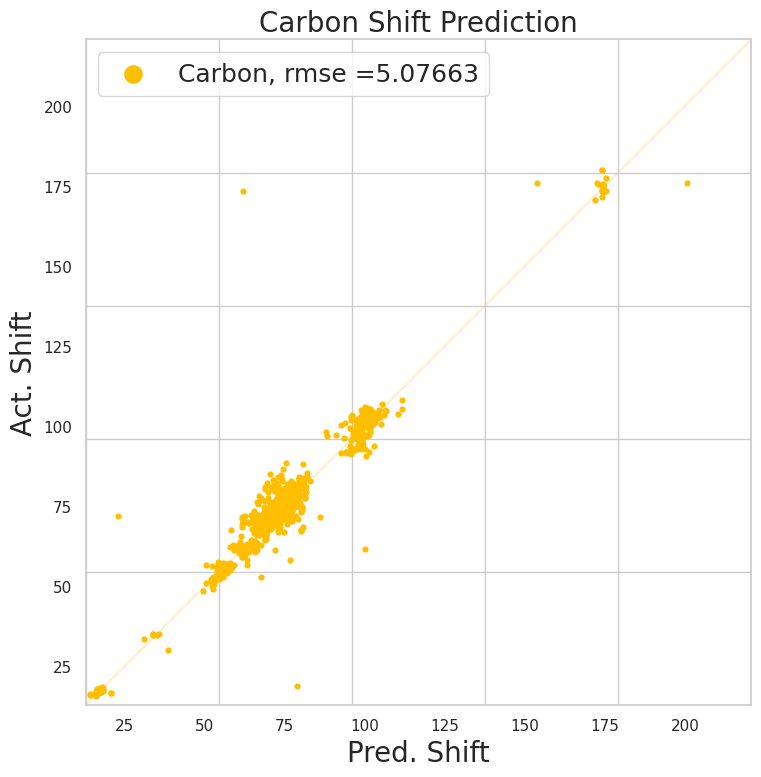

In [26]:
sns.set_theme(style="whitegrid", font_scale=1)

figure, axis = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=False)
# figure, axis = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=False)
# figure, axis = plt.subplots(3, 3, figsize=(8, 8))
figure.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad = 1, w_pad = 1)
##### For node features

plot_shift(df_visulize_v3, axis, i = 0, set_title_name = 'Carbon Shift Prediction', sep = 5, xlab_name = 'Pred. Shift', 
           ylab_name = 'Act. Shift', color = '#FFBF00', ms = 5)
# plot_shift(df_visulize_v2, axis, i = 0, set_title_name = 'Hydrogen shift prediction all type', sep = 5, xlab_name = 'Pred. Shift', 
#            ylab_name = 'Act. Shift', color = '#679399', ms = 5)

plt.show()

In [27]:
data_dir = 'experimental_data_combined/FullyAnnotatedPDB_pdb_labeled_combined/'
files_labels_list = os.listdir(data_dir)

##### Extract glycan name, atom type

In [28]:
# atom_test_list = []
# atom_name_test_list = []
# hydrogen_list_1_6 = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H61', 'H62']
# carbon_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# for i in range(len(files_labels_list)):
# #     if test_index[i]:
#     if not test_index[i]:
#         temp_df = pd.read_csv(os.path.join(data_dir, files_labels_list[i]))
# #         temp_atom_list = list(temp_df.loc[(temp_df['labels'] !=-1)]['Atom_Type'].values)
        
# #         temp_atom_list_hydrogen = [i for i in temp_atom_list if i in hydrogen_list_1_6]
# #         atom_test_list.extend(temp_atom_list_hydrogen)
        
#         temp_atom_list = list(temp_df.loc[(temp_df['labels'] !=-1) & ((temp_df['labels'] > 10))]['Atom_Type'].values)
#         temp_atom_list_carbon = [i for i in temp_atom_list if i in carbon_list]
#         atom_test_list.extend(temp_atom_list_carbon)
#         atom_name_test_list.extend(np.repeat(files_labels_list[i], len(temp_atom_list_carbon)))

In [29]:
# df_visulize['atom_type'] = atom_test_list
# df_visulize['glycan_name'] = atom_name_test_list

In [30]:
# df_visulize_outlier = df_visulize.loc[np.abs(df_visulize['0'].values - df_visulize['1'].values) > 5]
# df_visulize_outlier.index = range(len(df_visulize_outlier))

In [31]:
# len(atom_test_list), len(df_visulize)

In [32]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_hydrogen_training.csv', 
#                    index = False)

# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_hydrogen.csv', 
#                    index = False)

# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_carbon.csv', 
#                    index = False)


# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_carbon_training.csv', 
#                    index = False)

In [33]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_carbon_test.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_carbon_test_outlier.csv', 
#                    index = False)


In [34]:
# df_visulize.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_carbon_train.csv', 
#                    index = False)

# df_visulize_outlier.to_csv('experimental_data_combined/results_experiment_combined/labeled_results_all_carbon_train_outlier.csv', 
#                    index = False)